# Interactive Tambak Prediction

This notebook allows you to:
1. Select areas on an interactive map
2. Download satellite imagery from Google Earth
3. Run YOLO predictions on the imagery
4. Save results in GeoJSON format
5. Visualize predictions on a basemap
6. Export georeferenced images as GeoTIFF files

This notebook provides a streamlined pipeline for tambak detection:

🎯 **Main Features:**
1. **Coordinate Input**: Define analysis area with precise coordinates
2. **Preview Map**: Visualize your selected area before analysis
3. **YOLO Detection**: Run trained model on Google Earth imagery
4. **Geographic Results**: Save detections with WGS84 coordinates
5. **Interactive Maps**: View results on Google Hybrid basemap

📁 **Output Files:**
- `predictions/`: Original and predicted satellite imageries (GeoTIFF format) and predicted GeoJSON

🚀 **Quick Start:**
1. Define coordinates → Preview area → Run prediction → View results

**Happy detecting! 🛰️🦐**

## 1. Preparation

In [1]:
# # Install required packages
# %pip install folium ultralytics folium requests Pillow numpy opencv-python matplotlib ipywidgets rasterio odc-stac rasterio geopandas rioxarray pystac-client planetary-computer stackstac odc-stac folium osmnx -q
# %pip install --upgrade numpy -q

In [2]:
# Import required libraries
import base64
import cv2
import folium
import geopandas as gpd
import io
import ipywidgets as widgets
import json
import leafmap
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import osmnx as ox
import pandas as pd
import planetary_computer
import pystac_client
import rasterio
import rasterio.mask
import rasterio.warp
import requests
import warnings
import xarray as xr
from datetime import datetime
from folium import plugins
from io import BytesIO
from IPython.display import display, HTML
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
from pyproj import Transformer
from rasterio.crs import CRS
from rasterio.features import rasterize
from rasterio.transform import from_bounds, xy
from shapely.geometry import box, Point, Polygon
from ultralytics import YOLO
warnings.filterwarnings('ignore')

# Configure plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)

print("Libraries imported successfully!")

Libraries imported successfully!


In [3]:
# Configure notebook for trusted execution (for Folium maps)
import os
from IPython.display import display, HTML

# Auto-trust notebook settings
def trust_notebook():
    """Ensure notebook is trusted for HTML/JS content"""
    try:
        # This helps with Folium map display
        display(HTML("""
        <script>
        if (window.Jupyter) {
            Jupyter.notebook.trusted = true;
        }
        </script>
        """))
        print("✅ Notebook configured for trusted execution")
    except:
        print("⚠️ Please manually trust the notebook: File -> Trust Notebook")

trust_notebook()

✅ Notebook configured for trusted execution


## 2. Define Functions

In [4]:
# Google Earth Tile Downloading
def deg2num(lat_deg, lon_deg, zoom):
    """Convert lat/lon to tile numbers"""
    lat_rad = math.radians(lat_deg)
    n = 2.0 ** zoom
    xtile = int((lon_deg + 180.0) / 360.0 * n)
    ytile = int((1.0 - math.asinh(math.tan(lat_rad)) / math.pi) / 2.0 * n)
    return (xtile, ytile)

def num2deg(xtile, ytile, zoom):
    """Convert tile numbers to lat/lon"""
    n = 2.0 ** zoom
    lon_deg = xtile / n * 360.0 - 180.0
    lat_rad = math.atan(math.sinh(math.pi * (1 - 2 * ytile / n)))
    lat_deg = math.degrees(lat_rad)
    return (lat_deg, lon_deg)

def download_google_earth_image(north, south, east, west, zoom=18, tile_size=256):
    """Download satellite imagery from Google Earth for a bounding box"""
    
    # Validate coordinates
    if north <= south:
        raise ValueError(f"Invalid coordinates: North ({north}) must be > South ({south})")
    if east <= west:
        raise ValueError(f"Invalid coordinates: East ({east}) must be > West ({west})")
    
    # Convert bounding box to tile coordinates
    x_min, y_max = deg2num(north, west, zoom)
    x_max, y_min = deg2num(south, east, zoom)
    
    # Ensure proper ordering
    if x_min > x_max:
        x_min, x_max = x_max, x_min
    if y_min > y_max:
        y_min, y_max = y_max, y_min
    
    # Calculate actual geographic bounds of the downloaded tiles
    actual_north, actual_west = num2deg(x_min, y_min, zoom)
    actual_south, actual_east = num2deg(x_max + 1, y_max + 1, zoom)
    
    # Calculate image dimensions
    width = (x_max - x_min + 1) * tile_size
    height = (y_max - y_min + 1) * tile_size
    
    print(f"Requested bounds: N={north:.7f}, S={south:.7f}, E={east:.7f}, W={west:.7f}")
    print(f"Actual tile bounds: N={actual_north:.7f}, S={actual_south:.7f}, E={actual_east:.7f}, W={actual_west:.7f}")
    print(f"Tile range: X({x_min}-{x_max}), Y({y_min}-{y_max})")
    print(f"Image dimensions: {width}x{height}")
    
    # Create empty image
    if width <= 0 or height <= 0:
        raise ValueError(f"Invalid image dimensions: {width}x{height}")
    
    image = np.zeros((height, width, 3), dtype=np.uint8)
    
    # Headers to mimic browser request
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    
    print(f"Downloading {(x_max-x_min+1) * (y_max-y_min+1)} tiles...")
    
    # Download tiles
    for x in range(x_min, x_max + 1):
        for y in range(y_min, y_max + 1):
            # Google Earth tile URL (satellite imagery)
            url = f"https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={zoom}"
            
            try:
                response = requests.get(url, headers=headers)
                if response.status_code == 200:
                    tile_image = Image.open(BytesIO(response.content))
                    tile_array = np.array(tile_image)
                    
                    # Convert RGBA to RGB if necessary
                    if tile_array.shape[2] == 4:
                        tile_array = tile_array[:, :, :3]
                    
                    # Calculate position in the final image
                    x_pos = (x - x_min) * tile_size
                    y_pos = (y - y_min) * tile_size
                    
                    # Place tile in the image
                    image[y_pos:y_pos+tile_size, x_pos:x_pos+tile_size] = tile_array
                    
            except Exception as e:
                print(f"Error downloading tile {x},{y}: {e}")
    
    # Return image along with actual bounds for accurate coordinate conversion
    return image, {
        'actual_north': actual_north,
        'actual_south': actual_south,
        'actual_east': actual_east,
        'actual_west': actual_west,
        'requested_north': north,
        'requested_south': south,
        'requested_east': east,
        'requested_west': west
    }

In [5]:
# GeoTIFF Saving
def save_image_as_geotiff(image, bounds_info, output_path, description="Satellite Image"):
    """
    Save an image as a GeoTIFF file with proper coordinate reference system.
    
    Parameters:
    - image: numpy array (RGB format)
    - bounds_info: dictionary with geographic bounds
    - output_path: path where to save the GeoTIFF
    - description: description for the image
    """
    try:
        # Get actual tile bounds for accurate georeferencing
        west = bounds_info['actual_west']
        south = bounds_info['actual_south'] 
        east = bounds_info['actual_east']
        north = bounds_info['actual_north']
        
        # Get image dimensions
        height, width = image.shape[:2]
        
        # Create coordinate transformation matrix
        transform = from_bounds(west, south, east, north, width, height)
        
        # Define coordinate reference system (WGS84)
        crs = CRS.from_epsg(4326)
        
        print(f"🗺️ Saving GeoTIFF: {output_path}")
        print(f"   Bounds: W={west:.7f}, S={south:.7f}, E={east:.7f}, N={north:.7f}")
        print(f"   Size: {width}x{height} pixels")
        print(f"   CRS: {crs}")
        
        # Prepare image data - rasterio expects (bands, height, width)
        if len(image.shape) == 3:
            # RGB image - transpose to (bands, height, width)
            image_data = np.transpose(image, (2, 0, 1))
            count = 3  # RGB bands
        else:
            # Grayscale image
            image_data = image[np.newaxis, :, :]  # Add band dimension
            count = 1
        
        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        
        # Save as GeoTIFF
        with rasterio.open(
            output_path,
            'w',
            driver='GTiff',
            height=height,
            width=width,
            count=count,
            dtype=image_data.dtype,
            crs=crs,
            transform=transform,
            compress='lzw',  # Use LZW compression to reduce file size
            tiled=True,      # Use tiled format for better performance
            blockxsize=512,  # Tile size
            blockysize=512,
        ) as dst:
            # Write image data
            for band in range(count):
                dst.write(image_data[band], band + 1)
            
            # Add metadata
            dst.update_tags(
                description=description,
                software="Interactive Tambak Prediction",
                creation_time=datetime.now().isoformat(),
                coordinate_system="EPSG:4326 (WGS84)",
                bounds_source="Google Earth Tiles"
            )
        
        # Verify the file was created
        if os.path.exists(output_path):
            file_size_mb = os.path.getsize(output_path) / (1024*1024)
            print(f"✅ GeoTIFF saved successfully: {file_size_mb:.2f} MB")
            
            # Quick validation read
            with rasterio.open(output_path, 'r') as src:
                print(f"   Validation: {src.width}x{src.height}, {src.count} bands, CRS: {src.crs}")
                print(f"   Bounds: {src.bounds}")
            
            return True
        else:
            print("❌ Failed to create GeoTIFF file")
            return False
            
    except Exception as e:
        print(f"❌ Error saving GeoTIFF: {e}")
        return False

def validate_geotiff(geotiff_path):
    """Validate and display information about a GeoTIFF file"""
    try:
        with rasterio.open(geotiff_path, 'r') as src:
            print(f"\n📊 GeoTIFF Information: {os.path.basename(geotiff_path)}")
            print(f"   File size: {os.path.getsize(geotiff_path)/(1024*1024):.2f} MB")
            print(f"   Dimensions: {src.width} x {src.height}")
            print(f"   Bands: {src.count}")
            print(f"   Data type: {src.dtypes[0]}")
            print(f"   CRS: {src.crs}")
            print(f"   Transform: {src.transform}")
            print(f"   Bounds: {src.bounds}")
            
            # Check if coordinates are properly set
            if src.crs is not None:
                print("✅ Coordinate system properly defined")
            else:
                print("⚠️ No coordinate system found")
                
            return True
    except Exception as e:
        print(f"❌ Error validating GeoTIFF: {e}")
        return False

## 3. Define Analysis Area

**Interactive Map Selection with Leafmap**

**How to use:**
1. **📍 Locate your area** on the high-resolution satellite map below
2. **📐 Draw a rectangle** using the built-in drawing tools 
3. **📋 Click "Extract Coordinates"** to capture your selection
4. **✅ Coordinates update automatically** with area calculations

In [6]:
print("Draw a rectangle on the map below to define your analysis area")

# Enhanced coordinate storage with automatic leafmap integration
class LeafmapBoundingBox:
    def __init__(self):
        # No default coordinates - user must draw to set them
        self.north = None
        self.south = None
        self.west = None
        self.east = None
        
        # Create the interactive leafmap
        self.map = self.create_interactive_map()
        
        # Create coordinate display widget
        self.coords_display = widgets.HTML(value=self.get_coords_html())
        
        # Status display
        self.status_display = widgets.HTML(value="<p><i>ℹ️ Draw a rectangle on the map to define your analysis area</i></p>")
    
    def get_coords_html(self):
        """Generate HTML display of current coordinates"""
        if self.north is not None and self.south is not None:
            area_km2 = self.calculate_area()
            return f"""
            <div style="background-color: #e8f5e8; padding: 15px; border-radius: 8px; border-left: 4px solid #4CAF50;">
                <h4 style="color: #2E7D32; margin: 0 0 10px 0;">📍 Analysis Area Defined</h4>
                <div style="display: grid; grid-template-columns: 1fr 1fr; gap: 10px;">
                    <div><strong>North:</strong> {self.north:.6f}°</div>
                    <div><strong>South:</strong> {self.south:.6f}°</div>
                    <div><strong>East:</strong> {self.east:.6f}°</div>
                    <div><strong>West:</strong> {self.west:.6f}°</div>
                </div>
                <div style="margin-top: 10px; padding: 8px; background-color: #f1f8e9; border-radius: 4px;">
                    <strong>📏 Area:</strong> {area_km2:.2f} km² 
                    <span style="color: #666;">({abs(self.north-self.south)*111:.2f} × {abs(self.east-self.west)*111*math.cos(math.radians((self.north+self.south)/2)):.2f} km)</span>
                </div>
            </div>
            """
        else:
            return """
            <div style="background-color: #fff3e0; padding: 15px; border-radius: 8px; border-left: 4px solid #FF9800;">
                <h4 style="color: #E65100; margin: 0 0 10px 0;">📍 No Analysis Area Selected</h4>
                <p style="color: #BF360C; margin: 0;">Draw a rectangle on the map above to define your analysis area</p>
            </div>
            """
    
    def calculate_area(self):
        """Calculate area in km²"""
        if self.north is None or self.south is None:
            return 0
        
        lat_diff = abs(self.north - self.south) * 111  # km per degree latitude
        lon_diff = abs(self.east - self.west) * 111 * math.cos(math.radians((self.north + self.south) / 2))
        return lat_diff * lon_diff
    
    def update_from_drawing(self):
        """Extract coordinates from the most recent drawn rectangle"""
        try:
            if hasattr(self.map, 'draw_features') and self.map.draw_features:
                # Get the most recent drawn feature
                latest_feature = self.map.draw_features[-1]
                
                if latest_feature['geometry']['type'] == 'Polygon':
                    # Extract coordinates from polygon (rectangle)
                    coords = latest_feature['geometry']['coordinates'][0]
                    
                    # Get bounding box from polygon coordinates
                    lons = [coord[0] for coord in coords]
                    lats = [coord[1] for coord in coords]
                    
                    self.west = min(lons)
                    self.east = max(lons)
                    self.south = min(lats)
                    self.north = max(lats)
                    
                    # Update displays
                    self.coords_display.value = self.get_coords_html()
                    self.status_display.value = f"<p style='color: green;'><b>✅ Area updated!</b> {self.calculate_area():.2f} km² selected</p>"
                    
                    # Update backward compatibility widgets
                    sync_coordinates()
                    
                    return True
        except Exception as e:
            self.status_display.value = f"<p style='color: red;'>❌ Error extracting coordinates: {e}</p>"
        
        return False
    
    def create_interactive_map(self):
        """Create leafmap with drawing tools"""
        # Create map centered on Indonesia overview
        m = leafmap.Map(
            center=[-2.5, 115.0], 
            zoom=5,
            height="600px"
        )
        
        # Add satellite basemap (default for tambak analysis)
        m.add_basemap('SATELLITE')
        
        # Enable drawing tools (rectangle only for simplicity)
        # Note: leafmap automatically handles coordinate extraction
        
        return m

# Create the enhanced bounding box selector
bbox = LeafmapBoundingBox()

# Display the map
display(bbox.map)

# Add control button to extract coordinates from drawing
extract_button = widgets.Button(
    description='📐 Extract Coordinates', 
    style={'button_color': '#4CAF50'},
    layout={'width': '200px'}
)

def on_extract_click(button):
    """Extract coordinates from drawn features"""
    if bbox.update_from_drawing():
        print("✅ Coordinates extracted successfully!")
    else:
        print("⚠️ No rectangle found. Please draw a rectangle on the map first.")

extract_button.on_click(on_extract_click)

# Display controls and status
control_box = widgets.VBox([
    # widgets.HTML("<h4>📋 Controls</h4>"),
    extract_button,
    # widgets.HTML("<p><i>💡 After drawing a rectangle on the map, click 'Extract Coordinates' to capture the area</i></p>"),
    bbox.status_display
])

display(control_box)

# Display current coordinates
display(bbox.coords_display)

# For backward compatibility with existing code (including zoom_level)
lat_north = widgets.FloatText(value=bbox.north or 0.0, description='North:', disabled=True)
lat_south = widgets.FloatText(value=bbox.south or 0.0, description='South:', disabled=True)
lon_west = widgets.FloatText(value=bbox.west or 0.0, description='West:', disabled=True)
lon_east = widgets.FloatText(value=bbox.east or 0.0, description='East:', disabled=True)

# Add the missing zoom_level widget for satellite image download
zoom_level = widgets.IntSlider(
    value=18, 
    min=10, 
    max=20, 
    description='Zoom Level:', 
    style={'description_width': '100px'},
    layout={'width': '400px'}
)

# Display zoom control
# print("\n🔍 Satellite Image Settings:")
display(widgets.VBox([
    widgets.HTML("<b>Image Resolution Control:</b>"),
    zoom_level,
    widgets.HTML("<small><i>💡 Higher zoom = higher resolution but smaller area coverage</i></small>")
]))

def sync_coordinates():
    """Update backward compatibility variables"""
    lat_north.value = bbox.north or 0.0
    lat_south.value = bbox.south or 0.0
    lon_west.value = bbox.west or 0.0
    lon_east.value = bbox.east or 0.0

Draw a rectangle on the map below to define your analysis area


Map(center=[-2.5, 115.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

HTML(value='\n            <div style="background-color: #fff3e0; padding: 15px; border-radius: 8px; border-lef…

## 4. Run Prediction Pipeline

In [7]:
# Load the YOLOv8 model
try:
    model = YOLO(r'weights\best.pt')
    print("✅ YOLO model loaded successfully!")
    print(f"Model classes: {model.names}")
except FileNotFoundError:
    print("❌ Error: weights/best.pt not found!")
    print("Please ensure the model weights file exists in the weights directory.")
    model = None

✅ YOLO model loaded successfully!
Model classes: {0: 'Tambak', 1: 'TambakUdang'}


In [68]:
# Run the prediction
def run_prediction_pipeline():
    """Complete pipeline: download image, run prediction, save results with geographic coordinates"""
    
    if model is None:
        print("❌ No model loaded. Please check the model path.")
        return None
    
    # Get coordinates from widgets
    north = lat_north.value
    south = lat_south.value
    east = lon_east.value
    west = lon_west.value
    zoom = zoom_level.value
    
    # Validate coordinates
    if north <= south or east <= west:
        print("❌ Invalid coordinates! Check your input values.")
        return None
    
    print("-"*80)
    print(f"🎯 Analysis Area: {north:.6f}°N to {south:.6f}°N, {west:.6f}°E to {east:.6f}°E")
    print("-"*80)
    
    # Create timestamp and bbox string for filenames
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    bbox_str = f"{north}_{south}_{east}_{west}_z{zoom}"
    
    # Download satellite image
    # print("\n" + "-"*80)
    print("🛰️ Downloading satellite imagery...\n")
    try:
        image, bounds_info = download_google_earth_image(north, south, east, west, zoom)
        
        # Use actual tile bounds for accurate coordinate conversion
        actual_north = bounds_info['actual_north']
        actual_south = bounds_info['actual_south']
        actual_east = bounds_info['actual_east']
        actual_west = bounds_info['actual_west']
        
        print(f"🗺️ Using actual tile bounds for coordinate conversion:")
        print(f"   N={actual_north:.7f}, S={actual_south:.7f}, E={actual_east:.7f}, W={actual_west:.7f}")
        
        # Save original image as GeoTIFF
        os.makedirs('predictions', exist_ok=True)
        original_geotiff_path = f'predictions/original_{timestamp}_{bbox_str}.tif'
        save_image_as_geotiff(image, bounds_info, original_geotiff_path, "Original Satellite Image")

    except Exception as e:
        print(f"❌ Error downloading image: {e}")
        return None
    
    # Run YOLO prediction
    print("\n" + "-"*80)
    print("🤖 Running YOLO prediction...")
    try:
        image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        results = model.predict(image_bgr, save=False, imgsz=640, conf=0.4, device='cpu')
        
    except Exception as e:
        print(f"❌ Error during prediction: {e}")
        return None
    
    # Process results with geographic coordinates - GeoJSON format
    geojson_data = {
        'type': 'FeatureCollection',
        'crs': {
            'type': 'name',
            'properties': {
                'name': 'EPSG:4326'
            }
        },
        'properties': {
            'timestamp': timestamp,
            'analysis_bbox': {
                'north': north,
                'south': south, 
                'east': east,
                'west': west,
                'zoom': zoom
            },
            'actual_tile_bbox': {
                'north': actual_north,
                'south': actual_south,
                'east': actual_east,
                'west': actual_west
            },
            'image_info': {
                'width': image.shape[1],
                'height': image.shape[0]
            }
        },
        'features': []
    }
    
    total_detections = 0
    class_counts = {}
    
    # Process each detection
    for result in results:
        if result.boxes is not None:
            boxes = result.boxes
            
            for j in range(len(boxes)):
                x1, y1, x2, y2 = boxes.xyxy[j].cpu().numpy()
                confidence = float(boxes.conf[j].cpu().numpy())
                class_id = int(boxes.cls[j].cpu().numpy())
                class_name = model.names[class_id]
                
                # Calculate centroid in pixel coordinates
                center_x = float((x1 + x2) / 2)
                center_y = float((y1 + y2) / 2)
                
                # Convert pixel coordinates to geographic coordinates using ACTUAL tile bounds
                x_ratio = center_x / image.shape[1]
                y_ratio = center_y / image.shape[0]
                
                # Use actual tile bounds for accurate coordinate conversion
                centroid_lon = actual_west + (actual_east - actual_west) * x_ratio
                centroid_lat = actual_north - (actual_north - actual_south) * y_ratio
                
                # Debug: Print coordinate conversion details
                if total_detections < 3:  # Only for first few detections to avoid spam
                    print(f"🔍 Debug Detection {total_detections + 1}:")
                    print(f"   Pixel bbox: ({x1:.1f}, {y1:.1f}) to ({x2:.1f}, {y2:.1f})")
                    print(f"   Image size: {image.shape[1]}x{image.shape[0]}")
                    print(f"   Pixel centroid: ({center_x:.1f}, {center_y:.1f})")
                    print(f"   Ratios: x={x_ratio:.4f}, y={y_ratio:.4f}")
                    print(f"   Requested bounds: N={north:.7f}, S={south:.7f}, E={east:.7f}, W={west:.7f}")
                    print(f"   Actual tile bounds: N={actual_north:.7f}, S={actual_south:.7f}, E={actual_east:.7f}, W={actual_west:.7f}")
                    print(f"   Converted centroid: {centroid_lat:.7f}°N, {centroid_lon:.7f}°E")
                
                # Convert bounding box corners to geographic coordinates using actual bounds
                bbox_west_coord = actual_west + (actual_east - actual_west) * (x1 / image.shape[1])
                bbox_east_coord = actual_west + (actual_east - actual_west) * (x2 / image.shape[1])
                bbox_north_coord = actual_north - (actual_north - actual_south) * (y1 / image.shape[0])
                bbox_south_coord = actual_north - (actual_north - actual_south) * (y2 / image.shape[0])
                
                # Validate coordinate conversion using actual tile bounds
                if not (actual_west <= centroid_lon <= actual_east and actual_south <= centroid_lat <= actual_north):
                    print(f"⚠️ Warning: Detection {total_detections + 1} centroid outside actual tile bounds!")
                    print(f"   Centroid: {centroid_lat:.6f}°N, {centroid_lon:.6f}°E")
                    print(f"   Actual bounds: {actual_south:.6f}°N-{actual_north:.6f}°N, {actual_west:.6f}°E-{actual_east:.6f}°E")
                
                # Calculate geographic area (approximate)
                lat_diff = abs(bbox_north_coord - bbox_south_coord)
                lon_diff = abs(bbox_east_coord - bbox_west_coord)
                geographic_area_deg2 = lat_diff * lon_diff  # Square degrees
                
                # Count detections
                class_counts[class_name] = class_counts.get(class_name, 0) + 1
                total_detections += 1
                
                # Create GeoJSON feature with Point geometry (centroid) and complete bounding box data
                feature = {
                    'type': 'Feature',
                    'geometry': {
                        'type': 'Point',
                        'coordinates': [round(centroid_lon, 8), round(centroid_lat, 8)]  # GeoJSON standard: [longitude, latitude]
                    },
                    'properties': {
                        'id': total_detections,
                        'class_id': class_id,
                        'class_name': class_name,
                        'confidence': round(confidence, 4),
                        
                        # Geographic bounding box coordinates (accurate)
                        'bbox_geographic': {
                            'north': round(bbox_north_coord, 8),
                            'south': round(bbox_south_coord, 8),
                            'east': round(bbox_east_coord, 8),
                            'west': round(bbox_west_coord, 8)
                        },
                        
                        # Centroid coordinates (for easy access)
                        'centroid_coordinates': {
                            'latitude': round(centroid_lat, 8),
                            'longitude': round(centroid_lon, 8)
                        },
                        
                        # Original pixel data (for reference)
                        'bbox_pixels': {
                            'x1': round(float(x1), 2),
                            'y1': round(float(y1), 2),
                            'x2': round(float(x2), 2),
                            'y2': round(float(y2), 2),
                            'center_x': round(center_x, 2),
                            'center_y': round(center_y, 2)
                        },
                        
                        # Area measurements
                        'area': {
                            'pixels': round(float((x2-x1) * (y2-y1)), 2),
                            'geographic_deg2': round(geographic_area_deg2, 10)
                        },
                        
                        # Bounding box corner coordinates
                        'bbox_corners': {
                            'top_left': {
                                'lat': round(bbox_north_coord, 8),
                                'lon': round(bbox_west_coord, 8)
                            },
                            'top_right': {
                                'lat': round(bbox_north_coord, 8),
                                'lon': round(bbox_east_coord, 8)
                            },
                            'bottom_left': {
                                'lat': round(bbox_south_coord, 8),
                                'lon': round(bbox_west_coord, 8)
                            },
                            'bottom_right': {
                                'lat': round(bbox_south_coord, 8),
                                'lon': round(bbox_east_coord, 8)
                            }
                        }
                    }
                }
                
                geojson_data['features'].append(feature)
    
    # Add enhanced summary with coordinate validation
    geojson_data['properties']['summary'] = {
        'total_detections': total_detections,
        'class_counts': class_counts,
        'coordinate_validation': {
            'requested_bounds': {
                'north': north,
                'south': south,
                'east': east,
                'west': west
            },
            'actual_tile_bounds': {
                'north': actual_north,
                'south': actual_south,
                'east': actual_east,
                'west': actual_west
            },
            'all_centroids_within_actual_bounds': all([
                actual_south <= feature['geometry']['coordinates'][1] <= actual_north and
                actual_west <= feature['geometry']['coordinates'][0] <= actual_east
                for feature in geojson_data['features']
            ]),
            'coordinate_system': 'EPSG:4326 (WGS84)',
            'coordinate_format': '[longitude, latitude]'
        }
    }
    
    print("\n" + "-"*50)
    print(f"📊 Results: {total_detections} detections")
    for class_name, count in class_counts.items():
        print(f"    {class_name}: {count}")
    
    # Coordinate validation summary
    coord_validation = geojson_data['properties']['summary']['coordinate_validation']
    if coord_validation['all_centroids_within_actual_bounds']:
        print("✅ All centroids within actual tile bounds")
    else:
        print("⚠️ Some centroids outside actual tile bounds - check coordinate conversion")
    
    print("-"*50 + "\n")
    
    # Store results globally for later saving
    global recent_geojson
    recent_geojson = geojson_data
    print(f"📦 Detection results stored in 'recent_geojson' variable for later export")
    
    # Create and save visualization
    print("\n" + "-"*80)
    print("🎨 Creating visualization...\n")
    try:
        # Draw predictions on image
        vis_image = image.copy()
        
        for feature in geojson_data['features']:
            props = feature['properties']
            class_name = props['class_name']
            confidence = props['confidence']
            bbox_pixels = props['bbox_pixels']
            x1, y1, x2, y2 = bbox_pixels['x1'], bbox_pixels['y1'], bbox_pixels['x2'], bbox_pixels['y2']
            
            # Color by class - distinguish tambak vs tambak_udang
            if class_name.lower() == 'tambak':
                color = (230, 219, 60)  # Yellow for tambak (RGB format, #E6DB3C)
            elif 'udang' in class_name.lower():
                color = (0, 255, 0)  # Green for tambak_udang (RGB format)
            else:
                color = (0, 0, 255)  # Blue for other classes (RGB format)
            
            # Draw rectangle
            cv2.rectangle(vis_image, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)
            
            # Draw label with matching color background
            label = f"{class_name}: {confidence:.2f}"
            label_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)[0]
            cv2.rectangle(vis_image, (int(x1), int(y1-label_size[1]-10)), 
                         (int(x1+label_size[0]), int(y1)), color, -1)
            cv2.putText(vis_image, label, (int(x1), int(y1-5)), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
        
        # Save visualization as GeoTIFF (for GIS applications)
        vis_geotiff_path = f'predictions/visualized_{timestamp}_{bbox_str}.tif'
        save_image_as_geotiff(vis_image, bounds_info, vis_geotiff_path, "YOLO Predictions Visualization")
        print()
        
        # Display side-by-side comparison
        fig, axes = plt.subplots(1, 2, figsize=(20, 10))
        
        # Original image
        axes[0].imshow(image)
        axes[0].set_title(f'Original Satellite Image\nSize: {image.shape[1]}x{image.shape[0]} pixels', fontsize=14)
        axes[0].axis('off')
        
        # Prediction visualization
        axes[1].imshow(vis_image)
        axes[1].set_title(f'YOLO Predictions\nDetections: {total_detections} ({", ".join([f"{k}: {v}" for k, v in class_counts.items()])})', fontsize=14)
        axes[1].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        return geojson_data
        
    except Exception as e:
        print(f"❌ Error creating visualization: {e}")
        return geojson_data
    
    return geojson_data

# Quick run button for convenience
run_button = widgets.Button(
    description='🚀 Download Image & Run Prediction',
    button_style='success',
    layout=widgets.Layout(width='300px', height='40px')
)

output = widgets.Output()

def on_run_clicked(b):
    with output:
        output.clear_output()
        result = run_prediction_pipeline()

run_button.on_click(on_run_clicked)

display(run_button)
display(output)

Button(button_style='success', description='🚀 Download Image & Run Prediction', layout=Layout(height='40px', w…

Output()

# Water Quality Analysis for Shrimp Ponds

This notebook analyzes water quality parameters from satellite imagery for detected tambak locations.

**Current Parameters:**
- ✅ **Temperature** - Sentinel-3 SLSTR thermal bands
- ✅ **Turbidity** - Sentinel-2/3 turbidity indices (NDTI, etc.)
- ✅ **Water Color** - RGB analysis and water color classification
- ✅ **Chlorophyll-a** - Sentinel-3 OLCI ocean color algorithms
- ⚠️ **Salinity** - Indirect estimation using optical proxies
- ⚠️ **Dissolved Oxygen** - Estimated from chlorophyll and temperature

**Features:**
- ✅ **Temporal Analysis** - Customizable date ranges
- ✅ **Multi-satellite Sources** - Sentinel-2 & Sentinel-3
- ✅ **GeoJSON Integration** - Uses tambak detection results as input
- ✅ **Quality Standards** - Compares with JALA standards
- ✅ **Interactive Maps** - Temporal visualization
- ✅ **Export Options** - Enhanced GeoJSON with water quality data

**Data Sources:**
- Sentinel-2: 10m optical imagery for turbidity analysis
- Sentinel-3: 1km thermal imagery for temperature analysis
- Microsoft Planetary Computer API for satellite data access

## 5. Define Date Range & Cloud Cover


In [69]:
# # Define Date Range
# # date = "2024-01-01/2024-07-31"
# # date = "2024-07-01/2024-12-31"
# date = "2025-01-01/2025-08-31"

# # Define Cloud Cover Tolerance
# cc = 25

In [70]:
# Define Date Range and Cloud Cover
import datetime
from IPython.display import display
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

# print("📅 Dynamic Date & Cloud Cover Configuration")
# print("=" * 60)
print("\n💡 Usage Instructions:")
print("1. Use 'Quick Select' buttons for common date ranges")
print("2. Or manually select start/end dates using calendar pickers")
print("3. Adjust cloud cover tolerance with the slider")
print("4. Click 'Apply Settings' to update the global variables")
print("5. The configuration will be used in subsequent satellite data searches")
print("-" * 60)

# Create date range selector with calendar-style interface
start_date_picker = widgets.DatePicker(
    description='Start Date:',
    value=datetime.date(2025, 1, 1),
    style={'description_width': '100px'}
)

end_date_picker = widgets.DatePicker(
    description='End Date:',
    value=datetime.date(2025, 8, 31),
    style={'description_width': '100px'}
)

# Create cloud cover slider
cloud_cover_slider = widgets.IntSlider(
    value=10,
    min=0,
    max=100,
    step=5,
    description='Max Cloud Cover (%):',
    style={'description_width': '150px'},
    layout={'width': '400px'}
)

# Create preset date range buttons
preset_buttons = widgets.ToggleButtons(
    options=[
        ('Current Year', 'current_year'),
        ('Last 6 Months', '6_months'),
        ('Last 3 Months', '3_months'),
        ('Dry Season', 'dry_season'),
        ('Wet Season', 'wet_season'),
        ('Custom', 'custom')
    ],
    description='Quick Select:',
    value='custom',
    style={'description_width': '100px'},
    layout={'width': '100%'}
)

# Status display
status_display = widgets.HTML(value="")

def update_date_range(change):
    """Update date range based on preset selection"""
    today = datetime.date.today()
    
    if change['new'] == 'current_year':
        start_date_picker.value = datetime.date(today.year, 1, 1)
        end_date_picker.value = today
    elif change['new'] == '6_months':
        start_date_picker.value = today - datetime.timedelta(days=180)
        end_date_picker.value = today
    elif change['new'] == '3_months':
        start_date_picker.value = today - datetime.timedelta(days=90)
        end_date_picker.value = today
    elif change['new'] == 'dry_season':
        # Indonesian dry season (May - October)
        start_date_picker.value = datetime.date(today.year, 5, 1)
        end_date_picker.value = datetime.date(today.year, 10, 31)
    elif change['new'] == 'wet_season':
        # Indonesian wet season (November - April)
        if today.month >= 11:
            start_date_picker.value = datetime.date(today.year, 11, 1)
            end_date_picker.value = datetime.date(today.year + 1, 4, 30)
        else:
            start_date_picker.value = datetime.date(today.year - 1, 11, 1)
            end_date_picker.value = datetime.date(today.year, 4, 30)
    
    update_status()

def update_status(*args):
    """Update status display with current settings"""
    date_str = f"{start_date_picker.value.strftime('%Y-%m-%d')}/{end_date_picker.value.strftime('%Y-%m-%d')}"
    
    # Calculate date range duration
    duration = (end_date_picker.value - start_date_picker.value).days
    
    # Cloud cover interpretation
    if cloud_cover_slider.value <= 10:
        cc_status = "Very Clear (Minimal clouds)"
        cc_color = "green"
    elif cloud_cover_slider.value <= 25:
        cc_status = "Clear (Low clouds)"
        cc_color = "lightgreen"
    elif cloud_cover_slider.value <= 50:
        cc_status = "Moderate (Some clouds)"
        cc_color = "orange"
    else:
        cc_status = "Cloudy (High cloud tolerance)"
        cc_color = "red"
    
    status_html = f"""
    <div style="background-color: #f0f8ff; padding: 15px; border-radius: 8px; border-left: 4px solid #4CAF50; margin-top: 10px;">
        <h4 style="color: #2E7D32; margin: 0 0 10px 0;">📊 Current Configuration</h4>
        <div style="display: grid; grid-template-columns: 1fr 1fr; gap: 15px;">
            <div>
                <strong>🗓️ Date Range:</strong><br>
                <code>{date_str}</code><br>
                <small>{duration} days duration</small>
            </div>
            <div>
                <strong>☁️ Cloud Cover:</strong><br>
                <span style="color: {cc_color}; font-weight: bold;">{cloud_cover_slider.value}% maximum</span><br>
                <small>{cc_status}</small>
            </div>
        </div>
    </div>
    """
    status_display.value = status_html

# Set up event handlers
preset_buttons.observe(update_date_range, names='value')
start_date_picker.observe(lambda x: update_status(), names='value')
end_date_picker.observe(lambda x: update_status(), names='value')
cloud_cover_slider.observe(lambda x: update_status(), names='value')

# Create apply button
apply_button = widgets.Button(
    description='✅ Apply Settings',
    button_style='success',
    layout={'width': '200px', 'height': '40px'}
)

def apply_settings(button):
    """Apply the selected date and cloud cover settings"""
    global date, cc
    
    # Format date string for STAC API
    date = f"{start_date_picker.value.strftime('%Y-%m-%d')}/{end_date_picker.value.strftime('%Y-%m-%d')}"
    cc = cloud_cover_slider.value
    
    print("🎯 Settings Applied Successfully!")
    print(f"   📅 Date Range: {date}")
    print(f"   ☁️ Max Cloud Cover: {cc}%")
    print(f"   🔄 Ready for satellite data search")

apply_button.on_click(apply_settings)

# Display the interface
display(widgets.VBox([
    widgets.HTML("<h3>🌍 Satellite Data Configuration</h3>"),
    preset_buttons,
    widgets.HBox([start_date_picker, end_date_picker]),
    cloud_cover_slider,
    apply_button,
    status_display
]))

# Initialize status
update_status()


💡 Usage Instructions:
1. Use 'Quick Select' buttons for common date ranges
2. Or manually select start/end dates using calendar pickers
3. Adjust cloud cover tolerance with the slider
4. Click 'Apply Settings' to update the global variables
5. The configuration will be used in subsequent satellite data searches
------------------------------------------------------------


## 6. Access Satellite Data

In [71]:
# Connect to Microsoft Planetary Computer and search for data
print("Connecting to Microsoft Planetary Computer...")

# Initialize catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# =============================================================================
# COORDINATE SETUP
# =============================================================================

# Define bounding box from tambak detection area or coordinate widgets
if 'recent_geojson' in locals() and recent_geojson is not None:
    # Use tambak detection area bounds
    bbox_info = recent_geojson['properties']['actual_tile_bbox']
    left = bbox_info['west']
    bottom = bbox_info['south'] 
    right = bbox_info['east']
    top = bbox_info['north']
    print(f"📍 Using tambak detection area bounds:")
elif bbox.north is not None and bbox.south is not None:
    # Use coordinate widgets
    left = bbox.west
    bottom = bbox.south
    right = bbox.east
    top = bbox.north
    print(f"📍 Using coordinate widget bounds:")
else:
    print("❌ No coordinates available! Please define analysis area first.")
    left = bottom = right = top = None

if left is not None:
    print(f"   West: {left:.6f}°, South: {bottom:.6f}°, East: {right:.6f}°, North: {top:.6f}°")
    
    # Create AOI GeoDataFrame for later use
    from shapely.geometry import box
    aoi_polygon = box(left, bottom, right, top)
    aoi_gdf = gpd.GeoDataFrame([1], geometry=[aoi_polygon], crs='EPSG:4326')
else:
    print("❌ Cannot proceed without valid coordinates")

# =============================================================================
# TAMBAK GEODATAFRAME CREATION
# =============================================================================

# Create tambak GeoDataFrame from recent_geojson if available
if 'recent_geojson' in locals() and recent_geojson is not None:
    tambak_data = []
    for feature in recent_geojson['features']:
        coords = feature['geometry']['coordinates']  # [lon, lat]
        tambak_data.append({
            'id': feature['properties']['id'],
            'class_name': feature['properties']['class_name'],
            'confidence': feature['properties']['confidence'],
            'geometry': Point(coords[0], coords[1])  # Point(lon, lat)
        })
    
    tambak_gdf = gpd.GeoDataFrame(tambak_data, crs='EPSG:4326')
    print(f"📋 Created tambak GeoDataFrame with {len(tambak_gdf)} locations")
else:
    print("⚠️ No tambak detection data found - water quality analysis will be area-based only")
    tambak_gdf = None

# =============================================================================
# SENTINEL-2 DATA SEARCH
# =============================================================================

if left is not None:
    # Search for Sentinel-2 data (latest cloud-free image)
    print("\n🛰️ Searching for Sentinel-2 data...")
    search = catalog.search(
        collections=["sentinel-2-l2a"],
        bbox=[left, bottom, right, top],
        datetime=date,
        query={"eo:cloud_cover": {"lt": cc}},
        sortby=[{"field": "properties.datetime", "direction": "desc"}]
    )

    sentinel_items = list(search.get_items())
    print(f"Found {len(sentinel_items)} Sentinel-2 scenes")

    if sentinel_items:
        # Select the item with the least cloud cover
        item = min(sentinel_items, key=lambda i: i.properties.get('eo:cloud_cover', 100))
        print(f"Selected Sentinel-2 scene: {item.datetime}")
        print(f"Cloud cover: {item.properties.get('eo:cloud_cover', 'N/A')}%")
    else:
        print("❌ No suitable Sentinel-2 scenes found!")
        item = None
else:
    sentinel_items = []
    item = None

# =============================================================================
# LANDSAT DATA SEARCH
# =============================================================================

if left is not None:
    # Search for Landsat Collection 2 Level-2 (best for small water bodies)
    print("\n🛰️ Searching for Landsat data...")
    search_landsat = catalog.search(
        collections=["landsat-c2-l2"],
        bbox=[left, bottom, right, top],
        datetime=date,
        query={"eo:cloud_cover": {"lt": cc}},
        sortby=[{"field": "properties.datetime", "direction": "desc"}]
    )

    landsat_items = list(search_landsat.get_items())
    print(f"Found {len(landsat_items)} Landsat scenes")

    if landsat_items:
        landsat_item = landsat_items[0]
        print(f"Selected Landsat scene: {landsat_item.datetime}")
        print(f"Cloud cover: {landsat_item.properties.get('eo:cloud_cover', 'N/A')}%")
    else:
        print("❌ No suitable Landsat scenes found!")
        landsat_item = None
else:
    landsat_items = []
    landsat_item = None

Connecting to Microsoft Planetary Computer...
📍 Using tambak detection area bounds:
   West: 99.065094°, South: 3.584695°, East: 99.092560°, North: 3.612107°
📋 Created tambak GeoDataFrame with 120 locations

🛰️ Searching for Sentinel-2 data...
Found 7 Sentinel-2 scenes
Selected Sentinel-2 scene: 2025-08-23 03:35:51.025000+00:00
Cloud cover: 3.172657%

🛰️ Searching for Landsat data...
Found 2 Landsat scenes
Selected Landsat scene: 2025-08-12 03:34:49.585650+00:00
Cloud cover: 5.54%


## 7. Calculate Water Quality

### Temperature

🌡️ Processing Landsat LWIR11 thermal data...
   • Full image dimensions: 7731×7581 pixels
   • CRS: EPSG:32647
   • Resolution: 30.0m
   • Cropping to AOI window: 102×101 pixels
   • Converting DN to temperature (°C)...
   • Calculating geographic coordinates...

📊 Temperature Processing Results:
   • Loaded thermal data: (101, 102) pixels
   • Valid pixels: 1,190/10,302 (11.6%)
   • Temperature range: 33.5°C - 44.9°C
   • Mean temperature: 37.6°C ± 3.0°C
   • Geographic extent:
     - Longitude: 99.065227° to 99.092513°
     - Latitude: 3.584830° to 3.611974°
✅ Thermal data processing completed!
🗺️ Creating temperature visualization with tambak locations...
   📍 Plotting 120 tambak locations on temperature map
   🎨 Adding temperature-coded tambak markers


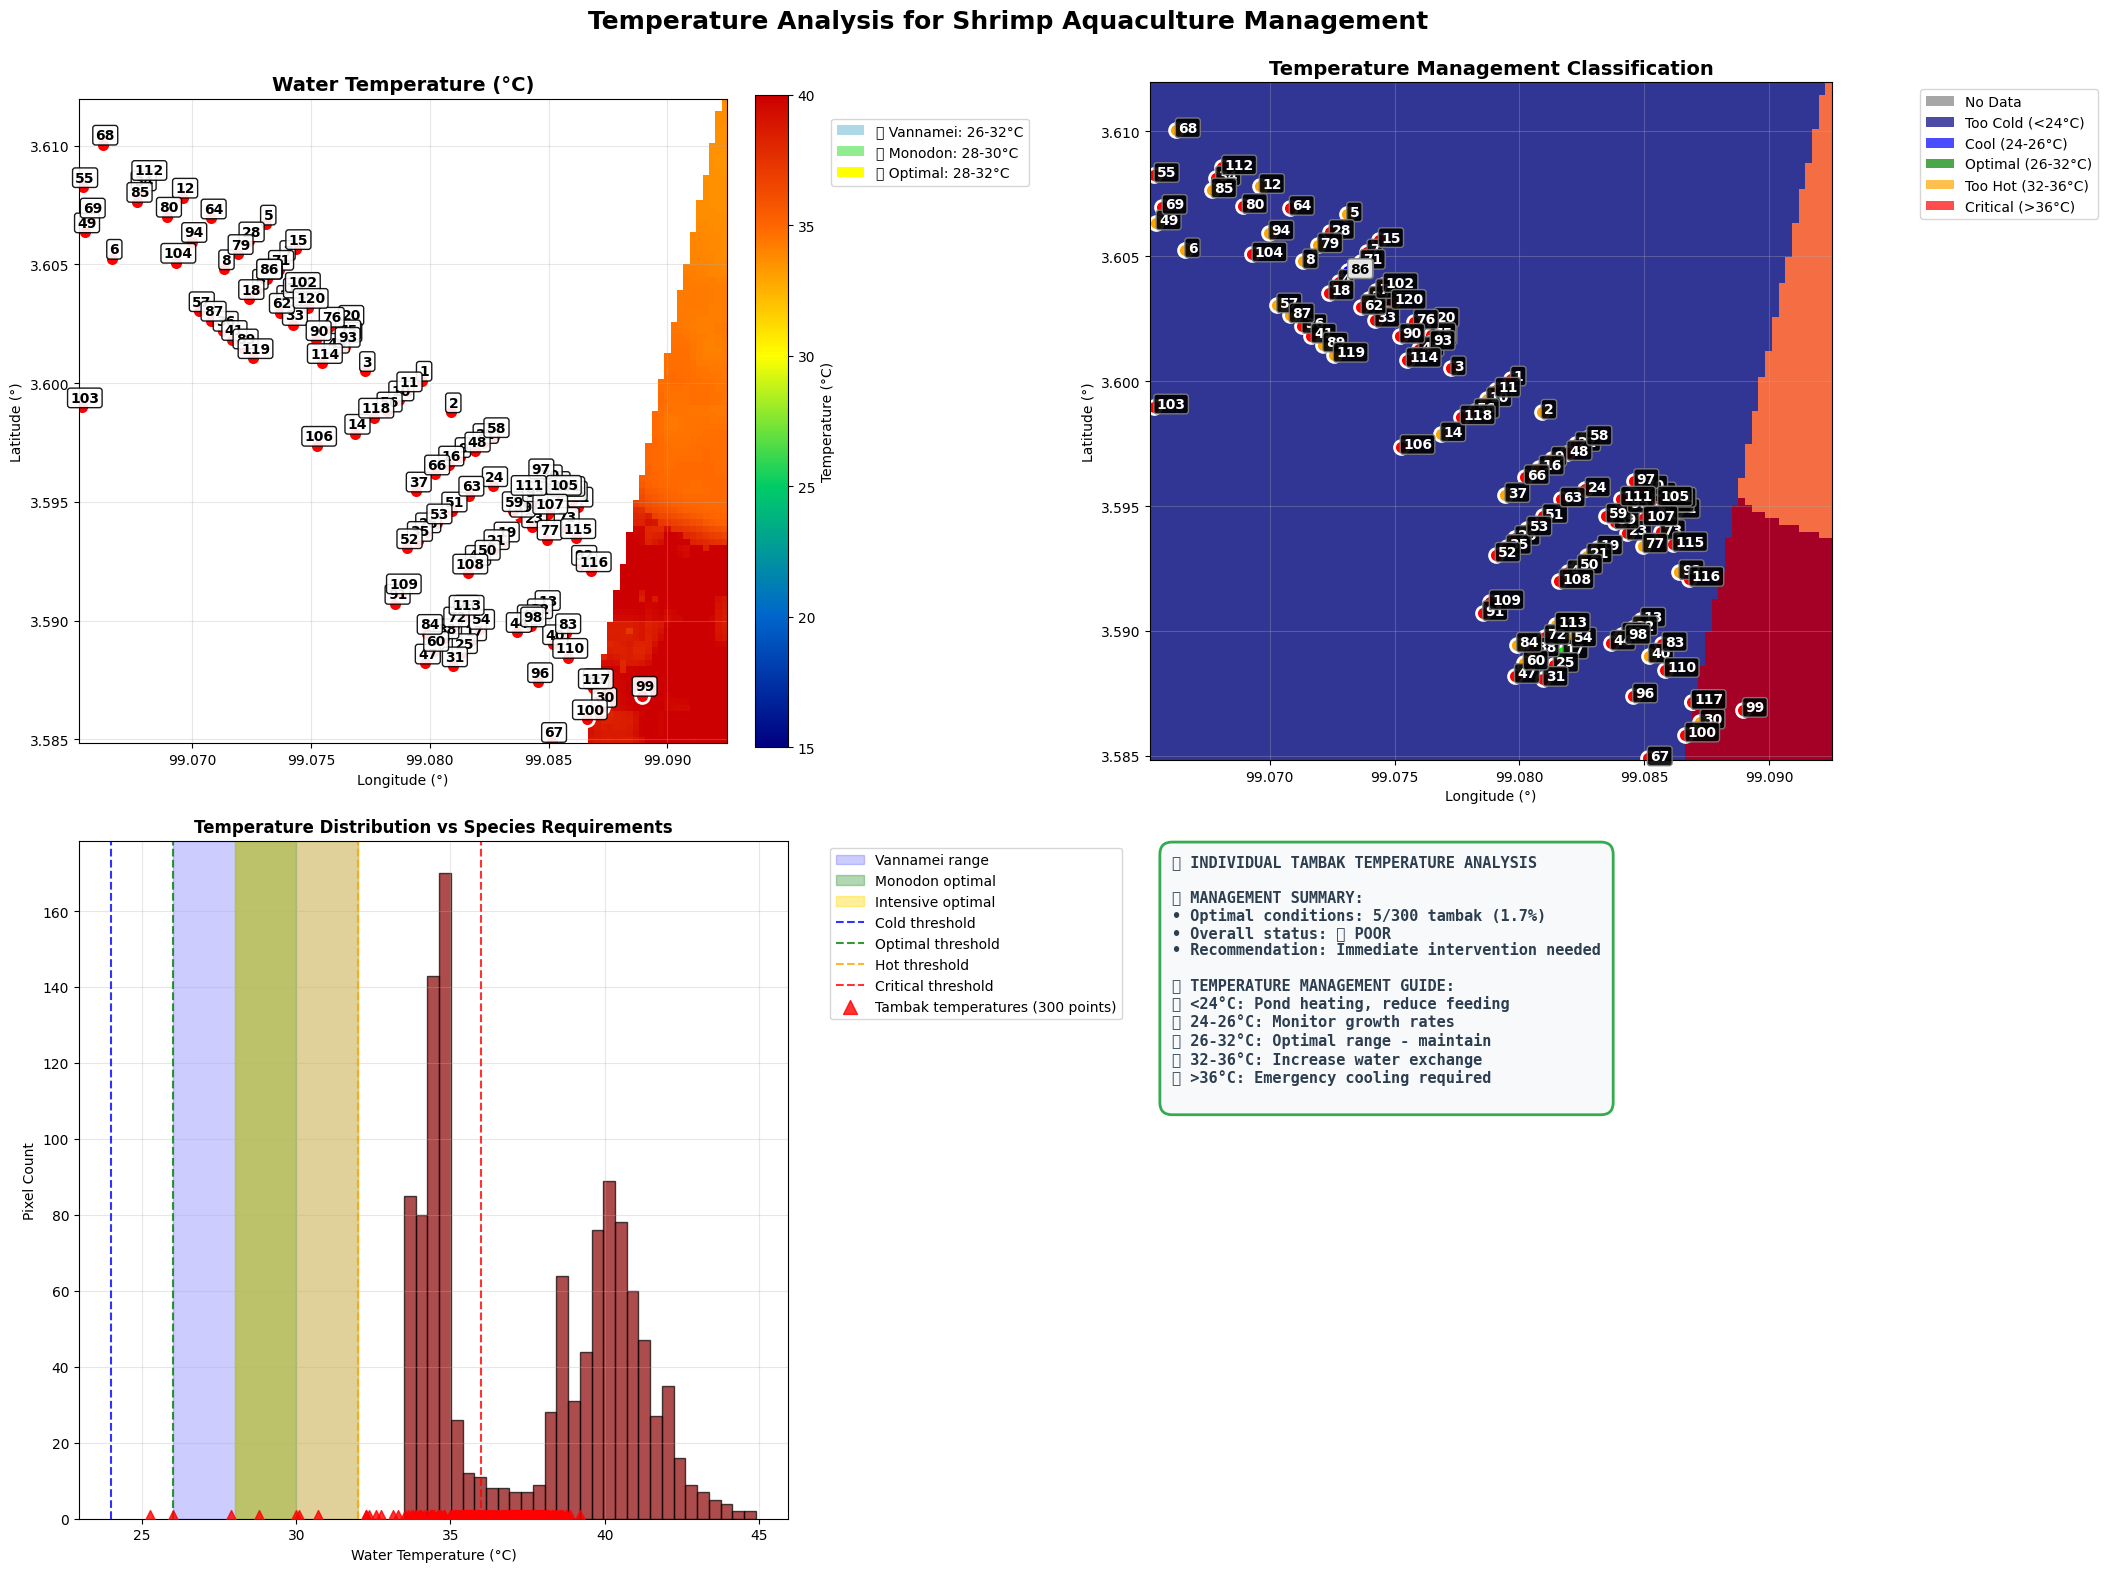

✅ Enhanced temperature visualization with tambak locations completed!

📊 Tambak Temperature Summary:
   • Total tambaks analyzed: 300
   • Critical (>36°C): 196 tambaks (65.3%)
   • Too Hot (32-36°C): 97 tambaks (32.3%)
   • Optimal (26-32°C): 5 tambaks (1.7%)
   • Cool (24-26°C): 2 tambaks (0.7%)

💾 Enhanced temperature analysis data saved to 'enhanced_temp_analysis'
🎯 Extracting temperature for 120 tambak locations...
   ⚪ Tambak 0: No data (nodata pixel)
   ⚪ Tambak 1: No data (nodata pixel)
   ⚪ Tambak 2: No data (nodata pixel)
   ⚪ Tambak 3: No data (nodata pixel)
   ⚪ Tambak 4: No data (nodata pixel)
   ⚪ Tambak 5: No data (nodata pixel)
   ⚪ Tambak 6: No data (nodata pixel)
   ⚪ Tambak 7: No data (nodata pixel)
   ⚪ Tambak 8: No data (nodata pixel)
   ⚪ Tambak 9: No data (nodata pixel)
   ⚪ Tambak 10: No data (nodata pixel)
   ⚪ Tambak 11: No data (nodata pixel)
   ⚪ Tambak 12: No data (nodata pixel)
   ⚪ Tambak 13: No data (nodata pixel)
   ⚪ Tambak 14: No data (nodata pixel)
 

In [72]:
# Step 1: Download and process Landsat thermal data for water quality prediction
if landsat_items:
    print("🌡️ Processing Landsat LWIR11 thermal data...")
    
    # Get LWIR11 band URL
    lwir11_href = planetary_computer.sign(landsat_item.assets["lwir11"].href)
    
    # Open the dataset and process thermal data
    with rasterio.open(lwir11_href) as src:
        print(f"   • Full image dimensions: {src.height}×{src.width} pixels")
        print(f"   • CRS: {src.crs}")
        print(f"   • Resolution: {src.res[0]:.1f}m")
        
        # Transform AOI to image CRS if needed
        if aoi_gdf.crs != src.crs:
            aoi_transformed = aoi_gdf.to_crs(src.crs)
        else:
            aoi_transformed = aoi_gdf.copy()
        
        # Create window from AOI bounds
        bounds_utm = rasterio.warp.transform_bounds(
            aoi_gdf.crs, src.crs, *aoi_gdf.total_bounds
        )
        
        try:
            window = rasterio.windows.from_bounds(*bounds_utm, src.transform)
            window = window.intersection(rasterio.windows.Window(0, 0, src.width, src.height))
            
            if window.width <= 0 or window.height <= 0:
                print("   ⚠️ AOI outside image bounds - using full image")
                window = None
            else:
                print(f"   • Cropping to AOI window: {window.width:.0f}×{window.height:.0f} pixels")
                
        except Exception as e:
            print(f"   ⚠️ Window creation failed: {e} - using full image")
            window = None
        
        # Read thermal data
        if window is not None:
            lwir11_data = src.read(1, window=window).astype(np.float32)
            transform = src.window_transform(window)
        else:
            lwir11_data = src.read(1).astype(np.float32)
            transform = src.transform
            
        profile = src.profile.copy()
        crs = src.crs
    
    # Convert DN to temperature
    print("   • Converting DN to temperature (°C)...")
    
    # LWIR11 scaling: Temperature(K) = DN * 0.00341802 + 149.0
    thermal_kelvin = np.where(
        lwir11_data > 0,  # Exclude nodata (0)
        lwir11_data * 0.00341802 + 149.0,
        np.nan
    )
    
    # Convert to Celsius and filter unrealistic values
    thermal_celsius = thermal_kelvin - 273.15
    thermal_celsius = np.where(
        (thermal_celsius < -10) | (thermal_celsius > 50),
        np.nan,
        thermal_celsius
    )
    
    # Calculate geographic coordinates
    print("   • Calculating geographic coordinates...")
    height, width = thermal_celsius.shape
    cols, rows = np.meshgrid(np.arange(width), np.arange(height))
    xs, ys = rasterio.transform.xy(transform, rows, cols)
    xs, ys = np.array(xs), np.array(ys)
    
    # Convert to lat/lon
    transformer = Transformer.from_crs(crs, 'EPSG:4326', always_xy=True)
    lons, lats = transformer.transform(xs, ys)
    
    # Calculate statistics
    valid_pixels = thermal_celsius[~np.isnan(thermal_celsius)]
    
    print(f"\n📊 Temperature Processing Results:")
    print(f"   • Loaded thermal data: {thermal_celsius.shape} pixels")
    print(f"   • Valid pixels: {len(valid_pixels):,}/{thermal_celsius.size:,} ({len(valid_pixels)/thermal_celsius.size*100:.1f}%)")
    if len(valid_pixels) > 0:
        print(f"   • Temperature range: {np.min(valid_pixels):.1f}°C - {np.max(valid_pixels):.1f}°C")
        print(f"   • Mean temperature: {np.mean(valid_pixels):.1f}°C ± {np.std(valid_pixels):.1f}°C")
    
    print(f"   • Geographic extent:")
    print(f"     - Longitude: {lons.min():.6f}° to {lons.max():.6f}°")
    print(f"     - Latitude: {lats.min():.6f}° to {lats.max():.6f}°")
    
    # # Display thermal image
    # fig, ax = plt.subplots(figsize=(12, 10))
    # extent = [lons.min(), lons.max(), lats.min(), lats.max()]
    
    # im = ax.imshow(thermal_celsius, cmap='RdYlBu_r', vmin=15, vmax=40, 
    #                extent=extent, origin='upper')
    
    # ax.set_title(f'Water Temperature (LWIR11)\n{landsat_item.datetime.strftime("%Y-%m-%d")} | 30m Resolution')
    # ax.set_xlabel('Longitude (°)')
    # ax.set_ylabel('Latitude (°)')
    # ax.grid(True, alpha=0.3)
    
    # # Add colorbar
    # cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    # cbar.set_label('Temperature (°C)', rotation=270, labelpad=20)
    
    # # Overlay tambak points if available
    # if 'tambak_gdf' in locals():
    #     tambak_subset_temp = tambak_gdf.cx[lons.min():lons.max(), lats.min():lats.max()]
    #     if not tambak_subset_temp.empty:
    #         tambak_colors = {'TambakUdang': 'red', 'TambakIkan': 'yellow'}
    #         for idx, row in tambak_subset_temp.iterrows():
    #             color = tambak_colors.get(row['class_name'], 'blue')
    #             ax.plot(row.geometry.x, row.geometry.y, 'o', color=color, 
    #                    markersize=8, markeredgecolor='white', markeredgewidth=1)
    
    # plt.tight_layout()
    # plt.show()
    
    # Store results for further analysis
    thermal_coords = {
        'longitude': lons,
        'latitude': lats,
        'x_proj': xs,
        'y_proj': ys,
        'temperature': thermal_celsius,
        'transform': transform,
        'crs': crs
    }
    
    print("✅ Thermal data processing completed!")
    
else:
    print("❌ No Landsat data available - skipping thermal processing")

# Step 2: Check if thermal data is available from previous processing
thermal_data_available = 'thermal_celsius' in locals() and thermal_celsius is not None

if thermal_data_available:
    print("🗺️ Creating temperature visualization with tambak locations...")
    
    # Create comprehensive visualization figure
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('Temperature Analysis for Shrimp Aquaculture Management\n', fontsize=18, fontweight='bold')
    
    # Define aquaculture-optimized colormap for temperature
    colors_temp = ['#000080', '#0066CC', '#00CC66', '#FFFF00', '#FF6600', '#CC0000']
    temp_cmap = LinearSegmentedColormap.from_list('temperature', colors_temp)
    
    # 1. Temperature concentration map with Tambak Markers
    ax1 = axes[0, 0]
    extent_temp = [lons.min(), lons.max(), lats.min(), lats.max()]
    
    im1 = ax1.imshow(thermal_celsius, cmap=temp_cmap, vmin=15, vmax=40, 
                     extent=extent_temp, origin='upper')
    ax1.set_title('Water Temperature (°C)', fontweight='bold', fontsize=14)
    ax1.set_xlabel('Longitude (°)')
    ax1.set_ylabel('Latitude (°)')
    ax1.grid(True, alpha=0.3)
    cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
    cbar1.set_label('Temperature (°C)')
    
    # Add species range annotations as legend
    from matplotlib.patches import Rectangle
    legend_elements = []
    species_names = ['🐟 Vannamei: 26-32°C', '🦐 Monodon: 28-30°C', '🏠 Optimal: 28-32°C']
    species_colors = ['lightblue', 'lightgreen', 'yellow']
    for name, color in zip(species_names, species_colors):
        legend_elements.append(Rectangle((0, 0), 1, 1, facecolor=color, alpha=1, label=name))
    ax1.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.15, 0.98))
    
    # Add tambak points with enhanced visibility
    if 'tambak_gdf' in locals() and tambak_gdf is not None:
        tambak_subset_temp = tambak_gdf.cx[lons.min():lons.max(), lats.min():lats.max()]
        if not tambak_subset_temp.empty:
            print(f"   📍 Plotting {len(tambak_subset_temp)} tambak locations on temperature map")
            for idx, row in tambak_subset_temp.iterrows():
                # Enhanced dot with white border for contrast
                ax1.plot(row.geometry.x, row.geometry.y, 'o', 
                        color='red', markersize=10, markeredgecolor='white', markeredgewidth=2)
                # Enhanced caption with background for better visibility
                ax1.text(row.geometry.x + 0.0001, row.geometry.y + 0.0001, f'{int(row.get("id", idx))}',
                        ha='center', va='bottom', fontsize=10, fontweight='bold',
                        color='black', 
                        bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.9, edgecolor='black', linewidth=1))
    
    # 2. Management classification map with Temperature-coded Tambak Markers
    ax2 = axes[0, 1]
    
    # Create temperature classification from data
    temp_class = np.full_like(thermal_celsius, 'No Data', dtype=object)
    valid_mask = ~np.isnan(thermal_celsius)
    temp_class[valid_mask & (thermal_celsius < 24)] = 'Too Cold'
    temp_class[valid_mask & (thermal_celsius >= 24) & (thermal_celsius < 26)] = 'Cool'
    temp_class[valid_mask & (thermal_celsius >= 26) & (thermal_celsius <= 32)] = 'Optimal'
    temp_class[valid_mask & (thermal_celsius > 32) & (thermal_celsius <= 36)] = 'Too Hot'
    temp_class[valid_mask & (thermal_celsius > 36)] = 'Critical'
    
    # Map classifications to numeric values
    class_colors = {'No Data': 0, 'Too Cold': 1, 'Cool': 2, 'Optimal': 3, 'Too Hot': 4, 'Critical': 5}
    temperature_numeric = np.full_like(thermal_celsius, 0, dtype=int)
    for class_name, class_val in class_colors.items():
        mask = (temp_class == class_name)
        temperature_numeric[mask] = class_val
    
    class_cmap = plt.cm.get_cmap('RdYlBu_r', 6)
    im2 = ax2.imshow(temperature_numeric, cmap=class_cmap, vmin=0, vmax=5,
                     extent=extent_temp, origin='upper')
    ax2.set_title('Temperature Management Classification', fontweight='bold', fontsize=14)
    ax2.set_xlabel('Longitude (°)')
    ax2.set_ylabel('Latitude (°)')
    ax2.grid(True, alpha=0.3)
    # Custom legend for classification
    legend_elements = []
    class_names = ['No Data', 'Too Cold (<24°C)', 'Cool (24-26°C)', 'Optimal (26-32°C)', 'Too Hot (32-36°C)', 'Critical (>36°C)']
    class_colors_rgb = ['gray', 'navy', 'blue', 'green', 'orange', 'red']
    for i, (name, color) in enumerate(zip(class_names, class_colors_rgb)):
        legend_elements.append(Rectangle((0, 0), 1, 1, facecolor=color, alpha=0.7, label=name))
    ax2.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.4, 1))
    
    # Enhanced tambak markers with temperature-coded colors
    if not tambak_subset_temp.empty:
        print(f"   🎨 Adding temperature-coded tambak markers")
        for idx, row in tambak_subset_temp.iterrows():
            # Get tambak temperature if available
            tambak_id = int(row.get('id', idx)) - 1  # Convert to 0-based index
            
            if 'tambak_temperatures' in locals() and tambak_id < len(tambak_temperatures):
                temp_val = tambak_temperatures[tambak_id]
                
                # Color code based on temperature classification
                if temp_val < 24:  # Too Cold
                    marker_color = 'navy'
                elif 24 <= temp_val < 26:  # Cool
                    marker_color = 'blue'
                elif 26 <= temp_val <= 32:  # Optimal
                    marker_color = 'lime'
                elif 32 < temp_val <= 36:  # Too Hot
                    marker_color = 'orange'
                else:  # Critical
                    marker_color = 'red'
            else:
                marker_color = 'gray'
            
            # Enhanced dot with white border
            ax2.plot(row.geometry.x, row.geometry.y, 'o', 
                    color=marker_color, markersize=10, markeredgecolor='white', markeredgewidth=2)
            
            # Enhanced caption with contrasting background
            caption_bg_color = 'white' if marker_color in ['navy', 'blue'] else 'black'
            caption_text_color = 'black' if caption_bg_color == 'white' else 'white'
            
            ax2.text(row.geometry.x + 0.0001, row.geometry.y + 0.0001, f'{int(row.get("id", idx))}',
                    ha='left', va='center', fontsize=10, fontweight='bold',
                    color=caption_text_color,
                    bbox=dict(boxstyle='round,pad=0.2', facecolor=caption_bg_color, alpha=0.9, edgecolor='gray', linewidth=1))
    
    # 3. Histogram with species tolerance ranges
    ax3 = axes[1, 0]
    valid_temp = thermal_celsius[~np.isnan(thermal_celsius)]
    
    if len(valid_temp) > 0:
        n, bins, patches = ax3.hist(valid_temp, bins=30, alpha=0.7, color='darkred', edgecolor='black')
        
        # Add species tolerance ranges
        ax3.axvspan(26, 32, alpha=0.2, color='blue', label='Vannamei range')
        ax3.axvspan(28, 30, alpha=0.3, color='green', label='Monodon optimal')  
        ax3.axvspan(28, 32, alpha=0.4, color='gold', label='Intensive optimal')
        
        # Add threshold lines
        ax3.axvline(24, color='blue', linestyle='--', alpha=0.8, label='Cold threshold')
        ax3.axvline(26, color='green', linestyle='--', alpha=0.8, label='Optimal threshold')
        ax3.axvline(32, color='orange', linestyle='--', alpha=0.8, label='Hot threshold')
        ax3.axvline(36, color='red', linestyle='--', alpha=0.8, label='Critical threshold')
        
        ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Add tambak temperature overlay if available
        if 'tambak_temperatures' in locals():
            valid_tambak_temps = [t for t in tambak_temperatures if not np.isnan(t)]
            if valid_tambak_temps:
                ax3.scatter(valid_tambak_temps, [0.5] * len(valid_tambak_temps), 
                           color='red', s=100, marker='^', alpha=0.8, 
                           label=f'Tambak temperatures ({len(valid_tambak_temps)} points)', zorder=5)
                ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
    else:
        ax3.text(0.5, 0.5, 'No valid temperature data for histogram', 
                transform=ax3.transAxes, ha='center', va='center', fontsize=12)
    
    ax3.set_xlabel('Water Temperature (°C)')
    ax3.set_ylabel('Pixel Count')
    ax3.set_title('Temperature Distribution vs Species Requirements', fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    # 4. Individual Tambak Temperature Report
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    # Create comprehensive tambak-by-tambak analysis
    tambak_analysis_text = "🏊 INDIVIDUAL TAMBAK TEMPERATURE ANALYSIS\n\n"
    
    # if 'tambak_temperatures' in locals() and 'tambak_temp_status' in locals():
    #     for i, (temp_val, temp_status) in enumerate(zip(tambak_temperatures, tambak_temp_status)):
    #         if i >= 10:  # Limit to first 10 tambaks for space
    #             tambak_analysis_text += f"... and {len(tambak_temperatures) - 10} more tambak(s)\n"
    #             break
                
    #         tambak_id = i + 1
            
    #         if np.isnan(temp_val) if isinstance(temp_val, (int, float)) else temp_status == 'No Data':
    #             status_icon = "❓"
    #             status_text = "No Data Available"
    #             recommendation = "Field verification needed"
    #         elif temp_val < 24:  # Too Cold
    #             status_icon = "🧊"
    #             status_text = f"Too Cold ({temp_val:.1f}°C)"
    #             recommendation = "Consider pond heating systems"
    #         elif temp_val < 26:  # Cool
    #             status_icon = "🔵"
    #             status_text = f"Cool ({temp_val:.1f}°C)"
    #             recommendation = "Monitor growth rates"
    #         elif 26 <= temp_val <= 32:  # Optimal
    #             status_icon = "🟢"
    #             status_text = f"Optimal ({temp_val:.1f}°C)"
    #             recommendation = "Maintain current practices"
    #         elif 32 < temp_val <= 36:  # Too Hot
    #             status_icon = "🔶"
    #             status_text = f"Too Hot ({temp_val:.1f}°C)"
    #             recommendation = "Increase water exchange"
    #         else:  # Critical
    #             status_icon = "🔴"
    #             status_text = f"Critical ({temp_val:.1f}°C)"
    #             recommendation = "URGENT cooling needed"
            
    #         tambak_analysis_text += f"{status_icon} Tambak #{tambak_id}: {status_text}\n"
    #         tambak_analysis_text += f"    Action: {recommendation}\n\n"
    # else:
    #     tambak_analysis_text += "No individual tambak temperature data available.\n"
    #     tambak_analysis_text += "Run temperature extraction step first.\n\n"
    
    # Add aquaculture management insights
    if 'tambak_temperatures' in locals():
        valid_tambak_temps = [t for t in tambak_temperatures if not np.isnan(t)]
        if valid_tambak_temps:
            optimal_tambaks = sum(1 for t in valid_tambak_temps if 26 <= t <= 32)
            total_valid_tambaks = len(valid_tambak_temps)
            optimal_percentage = (optimal_tambaks / total_valid_tambaks) * 100 if total_valid_tambaks > 0 else 0
            
            tambak_analysis_text += f"📊 MANAGEMENT SUMMARY:\n"
            tambak_analysis_text += f"• Optimal conditions: {optimal_tambaks}/{total_valid_tambaks} tambak ({optimal_percentage:.1f}%)\n"
            
            if optimal_percentage > 70:
                overall_status = "🟢 EXCELLENT"
                management_action = "Continue current management practices"
            elif optimal_percentage > 50:
                overall_status = "🟡 GOOD"
                management_action = "Minor adjustments needed"
            elif optimal_percentage > 30:
                overall_status = "🟠 FAIR"
                management_action = "Significant improvements required"
            else:
                overall_status = "🔴 POOR"
                management_action = "Immediate intervention needed"
            
            tambak_analysis_text += f"• Overall status: {overall_status}\n"
            tambak_analysis_text += f"• Recommendation: {management_action}\n"
    
    # Add temperature management guide
    tambak_analysis_text += f"\n💡 TEMPERATURE MANAGEMENT GUIDE:\n"
    tambak_analysis_text += f"🧊 <24°C: Pond heating, reduce feeding\n"
    tambak_analysis_text += f"🔵 24-26°C: Monitor growth rates\n"
    tambak_analysis_text += f"🟢 26-32°C: Optimal range - maintain\n"
    tambak_analysis_text += f"🔶 32-36°C: Increase water exchange\n"
    tambak_analysis_text += f"🔴 >36°C: Emergency cooling required\n"
    
    ax4.text(0.05, 0.98, tambak_analysis_text, transform=ax4.transAxes, 
        fontsize=11, verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round,pad=0.8', facecolor='#f8f9fa', alpha=0.95, 
             edgecolor='#28a745', linewidth=2),
        color='#2c3e50', weight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Enhanced temperature visualization with tambak locations completed!")
    
    # Display summary statistics
    if 'tambak_temperatures' in locals() and 'tambak_temp_status' in locals():
        print(f"\n📊 Tambak Temperature Summary:")
        print(f"   • Total tambaks analyzed: {len(tambak_temperatures)}")
        
        # Count each temperature class
        temp_counts = {}
        for temp_val, temp_status in zip(tambak_temperatures, tambak_temp_status):
            if not np.isnan(temp_val):
                if temp_val < 24:
                    temp_class = 'Too Cold (<24°C)'
                elif temp_val < 26:
                    temp_class = 'Cool (24-26°C)'
                elif 26 <= temp_val <= 32:
                    temp_class = 'Optimal (26-32°C)'
                elif 32 < temp_val <= 36:
                    temp_class = 'Too Hot (32-36°C)'
                else:
                    temp_class = 'Critical (>36°C)'
            else:
                temp_class = 'No Data'
            temp_counts[temp_class] = temp_counts.get(temp_class, 0) + 1
        
        for temp_class, count in temp_counts.items():
            percentage = (count / len(tambak_temperatures)) * 100
            print(f"   • {temp_class}: {count} tambaks ({percentage:.1f}%)")
    
    # Store enhanced analysis data
    enhanced_temp_analysis = {
        'temperature_celsius': thermal_celsius,
        'temperature_classification': temp_class,
        'tambak_temp_data': {
            'tambak_temperatures': tambak_temperatures if 'tambak_temperatures' in locals() else None,
            'tambak_temp_status': tambak_temp_status if 'tambak_temp_status' in locals() else None,
        },
        'spatial_extent': extent_temp,
        'analysis_date': landsat_item.datetime.strftime("%Y-%m-%d") if 'landsat_item' in locals() else "Unknown",
        'resolution': '30m',
        'data_source': 'Landsat LWIR11'
    }
    
    print(f"\n💾 Enhanced temperature analysis data saved to 'enhanced_temp_analysis'")
    
else:
    print("❌ No temperature data available for enhanced visualization")
    print("🔄 Please run the temperature calculation cells first")

# Step 3: Extract Temperature for Each Tambak Location  
if thermal_data_available and 'tambak_gdf' in locals():
    print(f"🎯 Extracting temperature for {len(tambak_gdf)} tambak locations...")
    
    tambak_temperatures = []
    tambak_temp_status = []
    
    # Transform tambak coordinates to Landsat thermal image CRS if needed
    if tambak_gdf.crs != crs:
        tambak_projected_temp = tambak_gdf.to_crs(crs)
    else:
        tambak_projected_temp = tambak_gdf.copy()
    
    for idx, tambak in tambak_projected_temp.iterrows():
        # Get tambak coordinates (use centroid for all geometry types)
        if tambak.geometry.geom_type == 'Point':
            x, y = tambak.geometry.x, tambak.geometry.y
        else:
            x, y = tambak.geometry.centroid.x, tambak.geometry.centroid.y
        
        # Convert geographic coordinates to pixel indices
        col, row = ~transform * (x, y)
        col, row = int(round(col)), int(round(row))
        
        # Extract temperature if pixel is within image bounds
        if (0 <= row < thermal_celsius.shape[0] and 0 <= col < thermal_celsius.shape[1]):
            temp_value = thermal_celsius[row, col]
            
            if not np.isnan(temp_value):
                tambak_temperatures.append(temp_value)
                
                # Classify temperature status based on JALA standards (26-32°C optimal)
                if 26 <= temp_value <= 32:
                    status = 'Optimal'
                    status_icon = "🟢"
                elif temp_value < 26:
                    status = 'Too Cold'
                    status_icon = "🔵"
                else:
                    status = 'Too Hot'
                    status_icon = "🔴"
                
                tambak_temp_status.append(status)
                print(f"   {status_icon} Tambak {idx}: {temp_value:.1f}°C ({status})")
                
            else:
                tambak_temperatures.append(np.nan)
                tambak_temp_status.append('No Data')
                print(f"   ⚪ Tambak {idx}: No data (nodata pixel)")
        else:
            tambak_temperatures.append(np.nan)
            tambak_temp_status.append('Outside Coverage')
            print(f"   ❌ Tambak {idx}: Outside thermal image coverage")
    
    # Add temperature data to tambak GeoDataFrame
    tambak_gdf['temperature_celsius'] = tambak_temperatures
    tambak_gdf['temp_status'] = tambak_temp_status
    
    # Calculate summary statistics for valid temperatures
    valid_tambak_temps = [t for t in tambak_temperatures if not np.isnan(t)]
    
    if valid_tambak_temps:
        print(f"\n🦐 JALA AQUACULTURE STANDARDS ANALYSIS:")
        optimal_count = sum(1 for t in valid_tambak_temps if 26 <= t <= 32)
        cold_count = sum(1 for t in valid_tambak_temps if t < 26)
        hot_count = sum(1 for t in valid_tambak_temps if t > 32)
        
        print(f"   🔵 Too cold (<26°C): {cold_count}/{len(valid_tambak_temps)} tambaks ({cold_count/len(valid_tambak_temps)*100:.1f}%)")
        print(f"   🟢 Optimal (26-32°C): {optimal_count}/{len(valid_tambak_temps)} tambaks ({optimal_count/len(valid_tambak_temps)*100:.1f}%)")
        print(f"   🔴 Too hot (>32°C): {hot_count}/{len(valid_tambak_temps)} tambaks ({hot_count/len(valid_tambak_temps)*100:.1f}%)")
        print(f"   📊 Average tambak temperature: {np.mean(valid_tambak_temps):.1f}°C")
        
        tambaks_with_temp = True
    else:
        print("\n❌ No valid temperature measurements found for any tambak!")
        tambaks_with_temp = False
else:
    tambaks_with_temp = False

### Turbidity

Turbidity is a key water quality parameter for aquaculture that measures water clarity and suspended particle concentration. High turbidity can reduce light penetration, affect dissolved oxygen levels, and impact shrimp health.

**Method Used**: NDTI (Normalized Difference Turbidity Index)
- **Formula**: `NDTI = (Red - Green) / (Red + Green)`
- **Data Source**: Sentinel-2 L2A (B04-Red, B03-Green)
- **Optimal Range**: 15-40 cm Secchi depth for shrimp ponds
- **Interpretation**: Higher NDTI values indicate higher turbidity

🌊 Processing Sentinel-2 data for turbidity analysis...
   • Selected scene: 2025-08-23
   • Cloud cover: 3.172657%
   • Cropping to AOI: 305×303 pixels
✅ Sentinel-2 bands loaded successfully!

🧮 Calculating NDTI (Normalized Difference Turbidity Index)...
   • Applying NDTI formula: (Red - Green) / (Red + Green)

🌊 NDTI Statistics:
   • Valid pixels: 92,415/92,415 (100.0%)
   • NDTI range: -0.284 to 0.187
   • Mean NDTI: -0.038
   • Std deviation: 0.064

📊 Turbidity Classification:
   • Low turbidity (NDTI < -0.1): 19,448 pixels (21.0%)
   • Medium turbidity (-0.1 ≤ NDTI ≤ 0.1): 72,717 pixels (78.7%)
   • High turbidity (NDTI > 0.1): 250 pixels (0.3%)

📍 NDTI Geographic Coverage:
   • Longitude range: 99.065137° to 99.092513°
   • Latitude range: 3.584740° to 3.612064°
   • Resolution: 10m (Sentinel-2)

🗺️ Creating enhanced turbidity visualization with tambak locations...


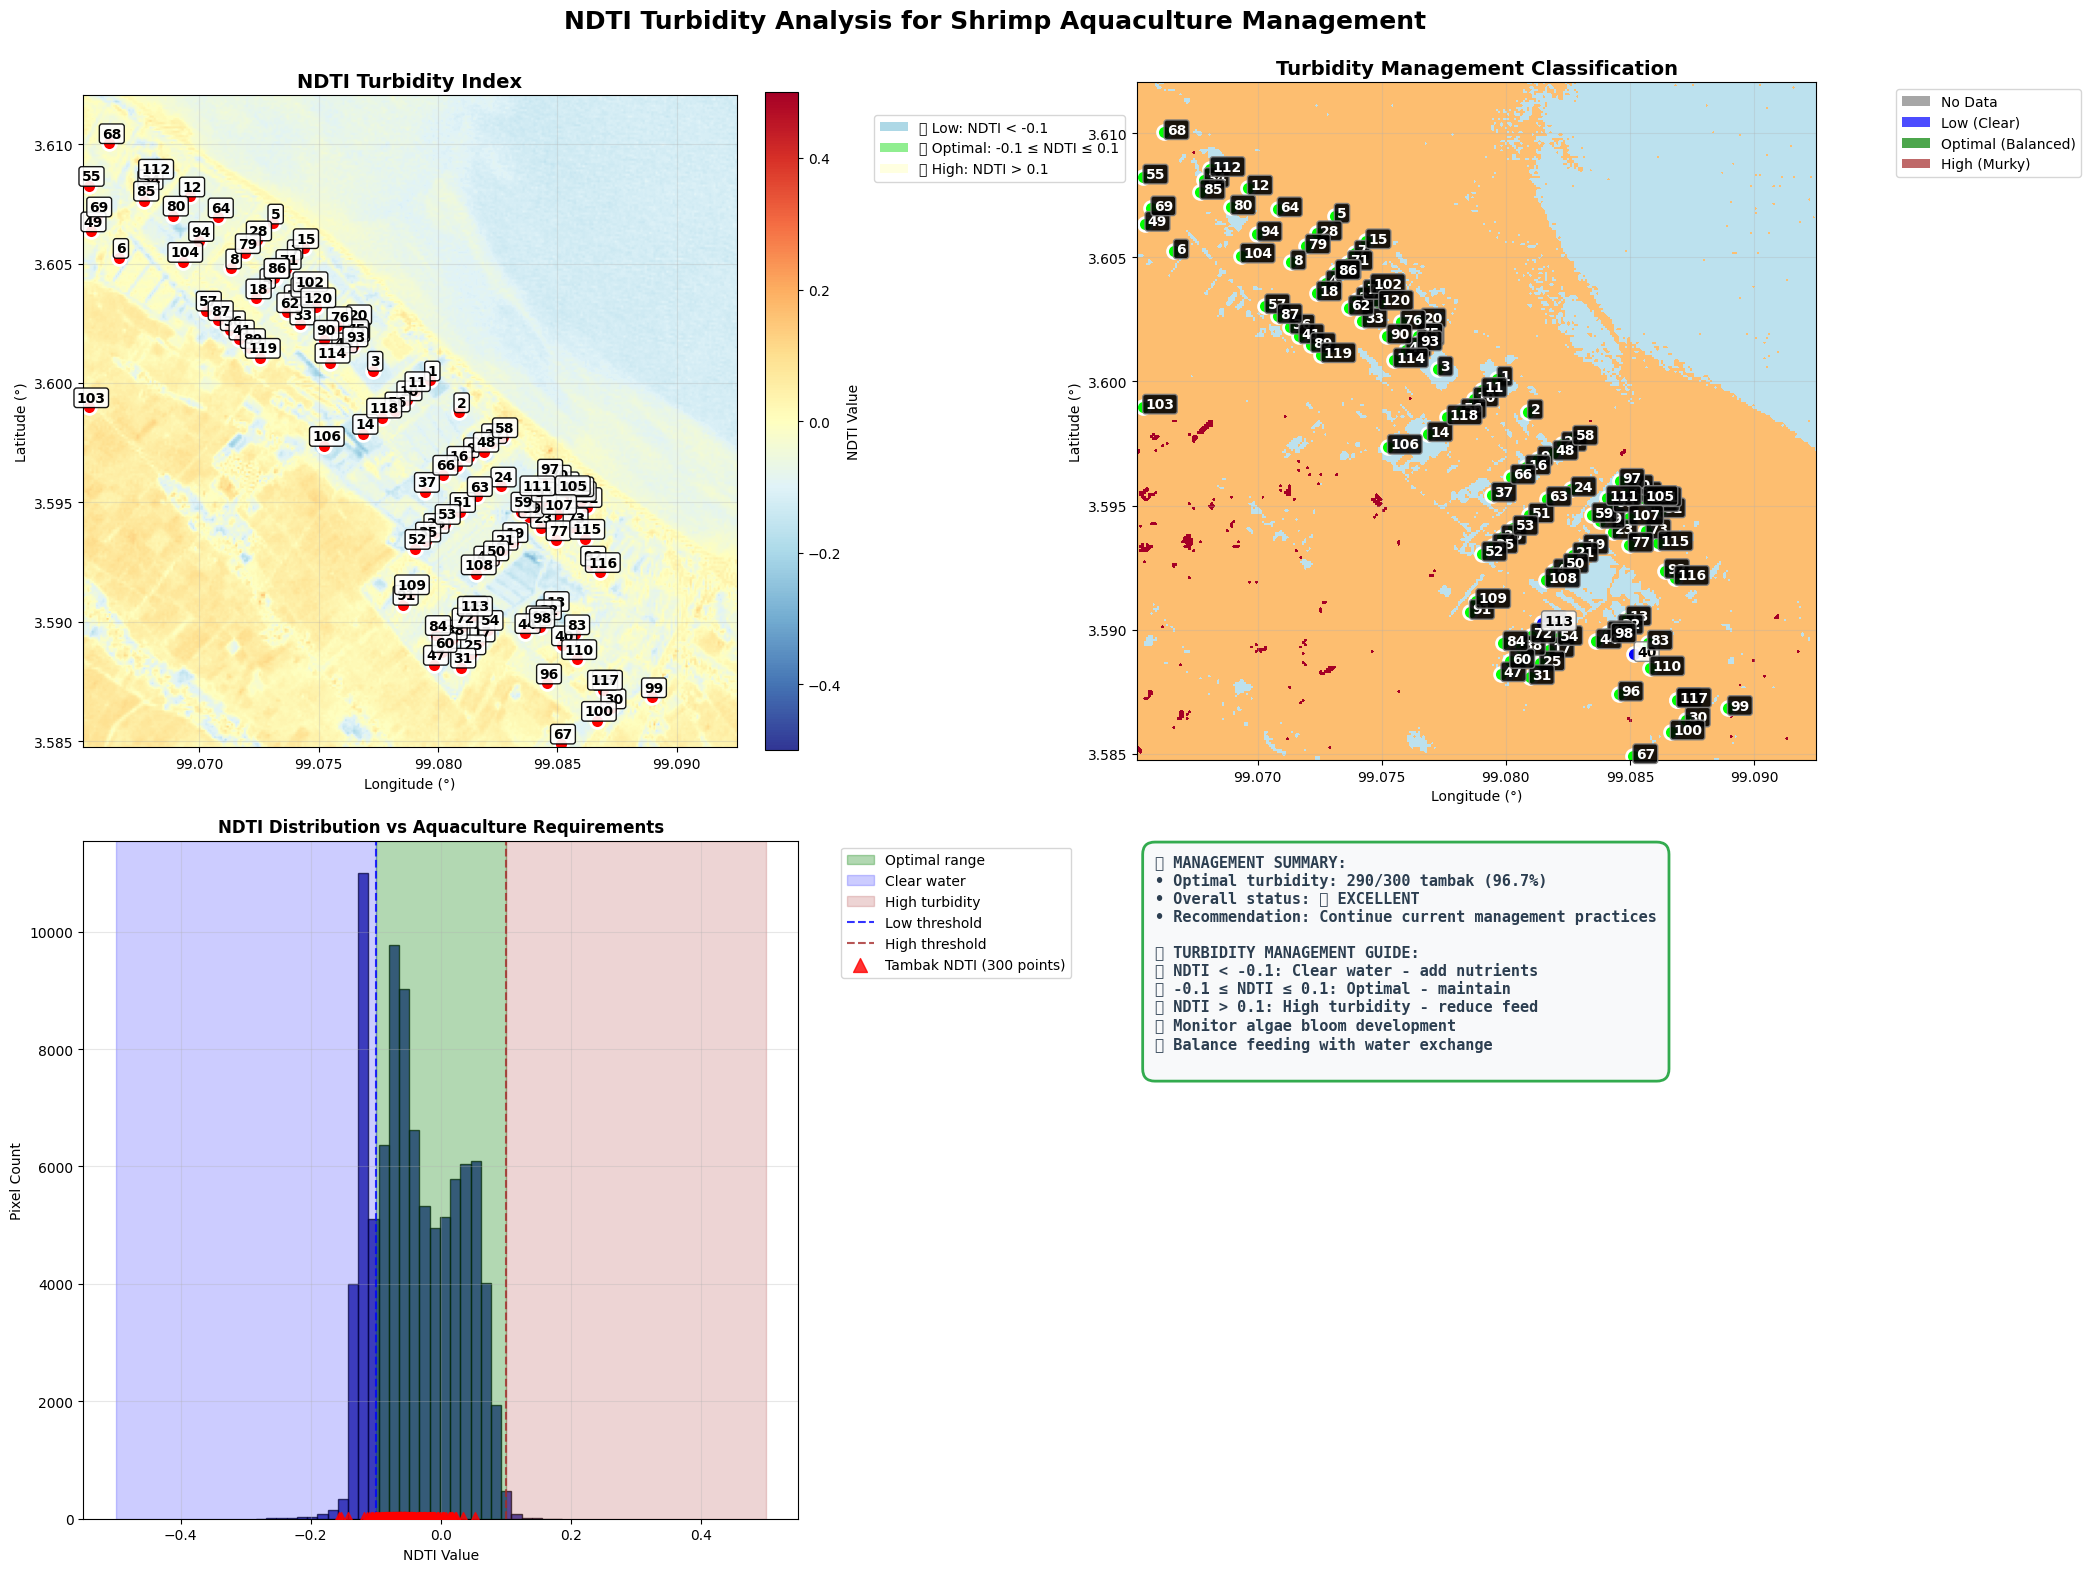

✅ Enhanced turbidity visualization with tambak locations completed!

📊 Tambak Turbidity Summary:
   • Total tambaks analyzed: 300
   • Optimal Turbidity: 290 tambaks (96.7%)
   • Clear Water: 10 tambaks (3.3%)

💾 Enhanced turbidity analysis data saved to 'enhanced_turb_analysis'
🎯 Extracting NDTI turbidity for 120 tambak locations...
   🔵 Tambak 0: -0.142 (Clear water - may lack nutrients)
   🟢 Tambak 1: -0.098 (Optimal - good algae balance)
   🔵 Tambak 2: -0.124 (Clear water - may lack nutrients)
   🟢 Tambak 3: -0.096 (Optimal - good algae balance)
   🟢 Tambak 4: -0.083 (Optimal - good algae balance)
   🟢 Tambak 5: 0.006 (Optimal - good algae balance)
   🟢 Tambak 6: -0.052 (Optimal - good algae balance)
   🟢 Tambak 7: -0.067 (Optimal - good algae balance)
   🟢 Tambak 8: -0.061 (Optimal - good algae balance)
   🟢 Tambak 9: -0.076 (Optimal - good algae balance)
   🟢 Tambak 10: -0.070 (Optimal - good algae balance)
   🟢 Tambak 11: -0.071 (Optimal - good algae balance)
   🔵 Tambak 12: -0.

In [73]:
# Step 1: Download and Process Sentinel-2 Data for Turbidity Analysis
if sentinel_items:
    print("🌊 Processing Sentinel-2 data for turbidity analysis...")
    
    # Get Red (B04) and Green (B03) band URLs
    red_href = planetary_computer.sign(item.assets["B04"].href)
    green_href = planetary_computer.sign(item.assets["B03"].href)
    
    print(f"   • Selected scene: {item.datetime.strftime('%Y-%m-%d')}")
    print(f"   • Cloud cover: {item.properties.get('eo:cloud_cover', 'N/A')}%")
    
    # Initialize data variables
    red_data = None
    green_data = None
    transform_s2 = None
    crs_s2 = None
    
    # Process Red band (B04 - 10m resolution) with robust error handling
    try:
        with rasterio.open(red_href) as src_red:
            # print(f"   • Red band (B04) - Resolution: {src_red.res[0]}m")
            
            # Transform AOI to image CRS if needed
            if aoi_gdf.crs != src_red.crs:
                aoi_transformed_s2 = aoi_gdf.to_crs(src_red.crs)
            else:
                aoi_transformed_s2 = aoi_gdf.copy()
            
            # Get bounds and create window
            # STANDARDIZED BOUNDS - Same as Salinity and Temperature
            bounds_utm = rasterio.warp.transform_bounds(
                aoi_gdf.crs, src_red.crs, *aoi_gdf.total_bounds
            )
            window_red = None
            
            try:
                # Create window from bounds with validation
                window_red = rasterio.windows.from_bounds(*bounds_utm, src_red.transform)
                window_red = window_red.intersection(rasterio.windows.Window(0, 0, src_red.width, src_red.height))
                
                # Validate window dimensions
                if (window_red.width <= 0 or window_red.height <= 0 or 
                    window_red.col_off < 0 or window_red.row_off < 0 or
                    window_red.col_off + window_red.width > src_red.width or
                    window_red.row_off + window_red.height > src_red.height):
                    print("   ⚠️ Invalid window parameters - using full image")
                    window_red = None
                else:
                    print(f"   • Cropping to AOI: {window_red.width:.0f}×{window_red.height:.0f} pixels")
                    
            except Exception as e:
                print(f"   ⚠️ Window creation failed: {e} - using full image")
                window_red = None
            
            # Read Red band data with multiple fallback strategies
            read_success = False
            
            # Strategy 1: Try reading with window
            if window_red is not None and not read_success:
                try:
                    # print("   • Attempting windowed read...")
                    red_data = src_red.read(1, window=window_red).astype(np.float32)
                    transform_s2 = src_red.window_transform(window_red)
                    read_success = True
                    # print("   ✅ Windowed read successful")
                except Exception as e:
                    print(f"   ⚠️ Windowed read failed: {type(e).__name__}")
            
            # Strategy 2: Try reading full image and then crop
            if not read_success:
                try:
                    print("   • Attempting full image read with post-crop...")
                    full_data = src_red.read(1).astype(np.float32)
                    
                    if window_red is not None:
                        # Manually crop the data
                        row_start = max(0, int(window_red.row_off))
                        row_end = min(full_data.shape[0], int(window_red.row_off + window_red.height))
                        col_start = max(0, int(window_red.col_off))
                        col_end = min(full_data.shape[1], int(window_red.col_off + window_red.width))
                        
                        red_data = full_data[row_start:row_end, col_start:col_end]
                        transform_s2 = src_red.window_transform(window_red)
                    else:
                        red_data = full_data
                        transform_s2 = src_red.transform
                    
                    read_success = True
                    print("   ✅ Full image read with crop successful")
                    
                except Exception as e:
                    print(f"   ❌ Full image read failed: {type(e).__name__}")
            
            # Strategy 3: Try reading with reduced window or different approach
            if not read_success and window_red is not None:
                try:
                    print("   • Attempting reduced window read...")
                    # Try with a smaller, centered window
                    center_row = window_red.row_off + window_red.height // 2
                    center_col = window_red.col_off + window_red.width // 2
                    reduced_size = min(window_red.width, window_red.height) // 2
                    
                    reduced_window = rasterio.windows.Window(
                        center_col - reduced_size // 2,
                        center_row - reduced_size // 2,
                        reduced_size,
                        reduced_size
                    )
                    
                    red_data = src_red.read(1, window=reduced_window).astype(np.float32)
                    transform_s2 = src_red.window_transform(reduced_window)
                    read_success = True
                    print(f"   ✅ Reduced window read successful: {reduced_size}×{reduced_size} pixels")
                    
                except Exception as e:
                    print(f"   ⚠️ Reduced window read failed: {type(e).__name__}")
            
            if read_success:
                crs_s2 = src_red.crs
                # print(f"   • Red band shape: {red_data.shape}")
                # print(f"   • Red data range: {red_data.min():.0f} - {red_data.max():.0f}")
            else:
                print("   ❌ All red band read strategies failed")
                
    except Exception as e:
        print(f"   ❌ Failed to open red band file: {type(e).__name__}: {e}")
        red_data = None
    
    # Process Green band (B03 - 10m resolution) if red band succeeded
    if red_data is not None:
        try:
            with rasterio.open(green_href) as src_green:
                # print(f"   • Green band (B03) - Resolution: {src_green.res[0]}m")
                
                # Use same window strategy as red band
                green_read_success = False
                
                # Try windowed read first if we have a valid window
                if window_red is not None:
                    try:
                        # STANDARDIZED BOUNDS - Same as Red band
                        bounds_utm = rasterio.warp.transform_bounds(
                            aoi_gdf.crs, src_green.crs, *aoi_gdf.total_bounds
                        )
                        window_green = rasterio.windows.from_bounds(*bounds_utm, src_green.transform)
                        window_green = window_green.intersection(rasterio.windows.Window(0, 0, src_green.width, src_green.height))
                        
                        if (window_green.width > 0 and window_green.height > 0 and
                            window_green.col_off >= 0 and window_green.row_off >= 0):
                            green_data = src_green.read(1, window=window_green).astype(np.float32)
                            green_read_success = True
                            # print("   ✅ Green windowed read successful")
                    except Exception as e:
                        print(f"   ⚠️ Green windowed read failed: {type(e).__name__}")
                
                # Fallback to full image read
                if not green_read_success:
                    try:
                        full_green = src_green.read(1).astype(np.float32)
                        if red_data.shape != full_green.shape:
                            # Crop green to match red data shape
                            green_data = full_green[:red_data.shape[0], :red_data.shape[1]]
                        else:
                            green_data = full_green
                        green_read_success = True
                        print("   ✅ Green full image read successful")
                    except Exception as e:
                        print(f"   ❌ Green full image read failed: {type(e).__name__}")
                
                # if green_read_success:
                #     print(f"   • Green band shape: {green_data.shape}")
                #     print(f"   • Green data range: {green_data.min():.0f} - {green_data.max():.0f}")
                # else:
                #     print("   ❌ All green band read strategies failed")
                #     green_data = None
                    
        except Exception as e:
            print(f"   ❌ Failed to open green band file: {type(e).__name__}: {e}")
            green_data = None
    
    if red_data is not None and green_data is not None:
        print("✅ Sentinel-2 bands loaded successfully!")
    elif red_data is not None:
        print("⚠️ Only red band loaded - green band failed")
    else:
        print("❌ Failed to load Sentinel-2 bands")
    
else:
    print("❌ No Sentinel-2 data available - skipping turbidity analysis")
    red_data = None
    green_data = None

# Step 2: Calculate NDTI (Normalized Difference Turbidity Index)
if red_data is not None and green_data is not None:
    print("\n🧮 Calculating NDTI (Normalized Difference Turbidity Index)...")
    
    # Ensure both arrays have the same shape
    if red_data.shape != green_data.shape:
        print(f"   ⚠️ Shape mismatch: Red {red_data.shape} vs Green {green_data.shape}")
        # Resize to match (simple approach - could be improved)
        min_height = min(red_data.shape[0], green_data.shape[0])
        min_width = min(red_data.shape[1], green_data.shape[1])
        red_data = red_data[:min_height, :min_width]
        green_data = green_data[:min_height, :min_width]
        print(f"   ✅ Resized to common shape: {red_data.shape}")
    
    # Calculate NDTI = (Red - Green) / (Red + Green)
    print("   • Applying NDTI formula: (Red - Green) / (Red + Green)")
    
    # Avoid division by zero and handle invalid values
    denominator = red_data + green_data
    numerator = red_data - green_data
    
    # Apply NDTI calculation with masking for valid pixels
    ndti = np.where(
        (denominator > 0) & (red_data > 0) & (green_data > 0),  # Valid data condition
        numerator / denominator,
        np.nan  # Invalid pixels
    )
    
    # Filter extreme values (NDTI should be between -1 and 1)
    ndti = np.where((ndti < -1) | (ndti > 1), np.nan, ndti)
    
    # Calculate statistics
    valid_ndti = ndti[~np.isnan(ndti)]
    
    print(f"\n🌊 NDTI Statistics:")
    print(f"   • Valid pixels: {len(valid_ndti):,}/{ndti.size:,} ({len(valid_ndti)/ndti.size*100:.1f}%)")
    if len(valid_ndti) > 0:
        print(f"   • NDTI range: {np.min(valid_ndti):.3f} to {np.max(valid_ndti):.3f}")
        print(f"   • Mean NDTI: {np.mean(valid_ndti):.3f}")
        print(f"   • Std deviation: {np.std(valid_ndti):.3f}")
        
        # Classify turbidity levels
        Low = np.sum(valid_ndti < -0.1)
        Medium = np.sum((-0.1 <= valid_ndti) & (valid_ndti <= 0.1))
        High = np.sum(valid_ndti > 0.1)

        print(f"\n📊 Turbidity Classification:")
        print(f"   • Low turbidity (NDTI < -0.1): {Low:,} pixels ({Low/len(valid_ndti)*100:.1f}%)")
        print(f"   • Medium turbidity (-0.1 ≤ NDTI ≤ 0.1): {Medium:,} pixels ({Medium/len(valid_ndti)*100:.1f}%)")
        print(f"   • High turbidity (NDTI > 0.1): {High:,} pixels ({High/len(valid_ndti)*100:.1f}%)")

    # Calculate geographic coordinates for NDTI data
    height_s2, width_s2 = ndti.shape
    cols_s2, rows_s2 = np.meshgrid(np.arange(width_s2), np.arange(height_s2))
    xs_s2, ys_s2 = rasterio.transform.xy(transform_s2, rows_s2, cols_s2)
    xs_s2 = np.array(xs_s2)
    ys_s2 = np.array(ys_s2)
    
    # Convert to lat/lon coordinates
    transformer_s2 = Transformer.from_crs(crs_s2, 'EPSG:4326', always_xy=True)
    lons_s2, lats_s2 = transformer_s2.transform(xs_s2, ys_s2)
    
    print(f"\n📍 NDTI Geographic Coverage:")
    print(f"   • Longitude range: {lons_s2.min():.6f}° to {lons_s2.max():.6f}°")
    print(f"   • Latitude range: {lats_s2.min():.6f}° to {lats_s2.max():.6f}°")
    print(f"   • Resolution: 10m (Sentinel-2)\n")
    
    turbidity_data_available = True
    
else:
    print("❌ No Sentinel-2 data available - skipping NDTI calculation")
    turbidity_data_available = False

# Step 3: Enhanced Turbidity Visualization for Aquaculture Management with Tambak Locations

# Check if turbidity data is available from previous processing
turbidity_data_available = 'ndti' in locals() and ndti is not None

if turbidity_data_available:
    print("🗺️ Creating enhanced turbidity visualization with tambak locations...")
    
    # Create comprehensive visualization figure
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('NDTI Turbidity Analysis for Shrimp Aquaculture Management\n', fontsize=18, fontweight='bold')
    
    # Define aquaculture-optimized colormap for turbidity
    colors_turb = ['#000080', '#0066CC', '#00CC66', '#FFFF00', '#FF6600', '#CC0000']
    turb_cmap = LinearSegmentedColormap.from_list('turbidity', colors_turb)
    
    # 1. NDTI concentration map with Tambak Markers
    ax1 = axes[0, 0]
    extent_turb = [lons_s2.min(), lons_s2.max(), lats_s2.min(), lats_s2.max()]
    
    im1 = ax1.imshow(ndti, cmap='RdYlBu_r', vmin=-0.5, vmax=0.5, 
                     extent=extent_turb, origin='upper')
    ax1.set_title('NDTI Turbidity Index', fontweight='bold', fontsize=14)
    ax1.set_xlabel('Longitude (°)')
    ax1.set_ylabel('Latitude (°)')
    ax1.grid(True, alpha=0.3)
    cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
    cbar1.set_label('NDTI Value')
    
    # Add turbidity range annotations as legend
    legend_elements = []
    turb_names = ['🔵 Low: NDTI < -0.1', '🟢 Optimal: -0.1 ≤ NDTI ≤ 0.1', '🟤 High: NDTI > 0.1']
    turb_colors = ['lightblue', 'lightgreen', 'lightyellow']
    for name, color in zip(turb_names, turb_colors):
        legend_elements.append(Rectangle((0, 0), 1, 1, facecolor=color, alpha=1, label=name))
    ax1.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.2, 0.98))
    
    # Add tambak points with enhanced visibility
    if 'tambak_gdf' in locals() and tambak_gdf is not None:
        tambak_subset_turb = tambak_gdf.cx[lons_s2.min():lons_s2.max(), lats_s2.min():lats_s2.max()]
        if not tambak_subset_turb.empty:
            # print(f"   📍 Plotting {len(tambak_subset_turb)} tambak locations on turbidity map")
            for idx, row in tambak_subset_turb.iterrows():
                # Enhanced dot with white border for contrast
                ax1.plot(row.geometry.x, row.geometry.y, 'o', 
                        color='red', markersize=10, markeredgecolor='white', markeredgewidth=2)
                # Enhanced caption with background for better visibility
                ax1.text(row.geometry.x + 0.0001, row.geometry.y + 0.0001, f'{int(row.get("id", idx))}',
                        ha='center', va='bottom', fontsize=10, fontweight='bold',
                        color='black', 
                        bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.9, edgecolor='black', linewidth=1))
    
    # 2. Management classification map with Turbidity-coded Tambak Markers
    ax2 = axes[0, 1]
    
    # Create turbidity classification from data
    turb_class = np.full_like(ndti, 'No Data', dtype=object)
    valid_mask = ~np.isnan(ndti)
    turb_class[valid_mask & (ndti < -0.1)] = 'Low'
    turb_class[valid_mask & (ndti >= -0.1) & (ndti <= 0.1)] = 'Optimal'
    turb_class[valid_mask & (ndti > 0.1)] = 'High'
    
    # Map classifications to numeric values
    class_colors = {'No Data': 0, 'Low': 1, 'Optimal': 2, 'High': 3}
    turbidity_numeric = np.full_like(ndti, 0, dtype=int)
    for class_name, class_val in class_colors.items():
        mask = (turb_class == class_name)
        turbidity_numeric[mask] = class_val
    
    class_cmap = plt.cm.get_cmap('RdYlBu_r', 4)
    im2 = ax2.imshow(turbidity_numeric, cmap=class_cmap, vmin=0, vmax=3,
                     extent=extent_turb, origin='upper')
    ax2.set_title('Turbidity Management Classification', fontweight='bold', fontsize=14)
    ax2.set_xlabel('Longitude (°)')
    ax2.set_ylabel('Latitude (°)')
    ax2.grid(True, alpha=0.3)
    
    # Custom legend for classification
    from matplotlib.patches import Rectangle
    legend_elements = []
    class_names = ['No Data', 'Low (Clear)', 'Optimal (Balanced)', 'High (Murky)']
    class_colors_rgb = ['gray', 'blue', 'green', 'brown']
    for i, (name, color) in enumerate(zip(class_names, class_colors_rgb)):
        legend_elements.append(Rectangle((0, 0), 1, 1, facecolor=color, alpha=0.7, label=name))
    ax2.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.4, 1))
    
    # Enhanced tambak markers with turbidity-coded colors
    if not tambak_subset_turb.empty:
        # print(f"   🎨 Adding turbidity-coded tambak markers")
        for idx, row in tambak_subset_turb.iterrows():
            # Get tambak turbidity if available
            tambak_id = int(row.get('id', idx)) - 1  # Convert to 0-based index
            
            if 'tambak_ndti_values' in locals() and tambak_id < len(tambak_ndti_values):
                ndti_val = tambak_ndti_values[tambak_id]
                
                # Color code based on turbidity classification
                if np.isnan(ndti_val):
                    marker_color = 'gray'
                elif ndti_val < -0.1:  # Low
                    marker_color = 'blue'
                elif -0.1 <= ndti_val <= 0.1:  # Optimal
                    marker_color = 'lime'
                else:  # High
                    marker_color = 'brown'
            else:
                marker_color = 'gray'
            
            # Enhanced dot with white border
            ax2.plot(row.geometry.x, row.geometry.y, 'o', 
                    color=marker_color, markersize=10, markeredgecolor='white', markeredgewidth=2)
            
            # Enhanced caption with contrasting background
            caption_bg_color = 'white' if marker_color in ['blue', 'brown'] else 'black'
            caption_text_color = 'black' if caption_bg_color == 'white' else 'white'
            
            ax2.text(row.geometry.x + 0.0001, row.geometry.y + 0.0001, f'{int(row.get("id", idx))}',
                    ha='left', va='center', fontsize=10, fontweight='bold',
                    color=caption_text_color,
                    bbox=dict(boxstyle='round,pad=0.2', facecolor=caption_bg_color, alpha=0.9, edgecolor='gray', linewidth=1))

    # 3. Histogram with aquaculture tolerance ranges
    ax3 = axes[1, 0]
    valid_ndti = ndti[~np.isnan(ndti)]
    
    if len(valid_ndti) > 0:
        n, bins, patches = ax3.hist(valid_ndti, bins=30, alpha=0.7, color='darkblue', edgecolor='black')
        
        # Add turbidity management zones
        ax3.axvspan(-0.1, 0.1, alpha=0.3, color='green', label='Optimal range')
        ax3.axvspan(-0.5, -0.1, alpha=0.2, color='blue', label='Clear water')  
        ax3.axvspan(0.1, 0.5, alpha=0.2, color='brown', label='High turbidity')
        
        # Add threshold lines
        ax3.axvline(-0.1, color='blue', linestyle='--', alpha=0.8, label='Low threshold')
        ax3.axvline(0.1, color='brown', linestyle='--', alpha=0.8, label='High threshold')
        
        ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Add tambak turbidity overlay if available
        if 'tambak_ndti_values' in locals():
            valid_tambak_ndti = [t for t in tambak_ndti_values if not np.isnan(t)]
            if valid_tambak_ndti:
                ax3.scatter(valid_tambak_ndti, [0.5] * len(valid_tambak_ndti), 
                           color='red', s=100, marker='^', alpha=0.8, 
                           label=f'Tambak NDTI ({len(valid_tambak_ndti)} points)', zorder=5)
                ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
    else:
        ax3.text(0.5, 0.5, 'No valid turbidity data for histogram', 
                transform=ax3.transAxes, ha='center', va='center', fontsize=12)
    
    ax3.set_xlabel('NDTI Value')
    ax3.set_ylabel('Pixel Count')
    ax3.set_title('NDTI Distribution vs Aquaculture Requirements', fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    # 4. Individual Tambak Turbidity Report
    ax4 = axes[1, 1]
    ax4.axis('off')

    # Create management summary directly
    tambak_analysis_text = ""

    # Add aquaculture management insights
    if 'tambak_ndti_values' in locals():
        valid_tambak_ndti = [t for t in tambak_ndti_values if not np.isnan(t)]
        if valid_tambak_ndti:
            optimal_tambaks = sum(1 for t in valid_tambak_ndti if -0.1 <= t <= 0.1)
            total_valid_tambaks = len(valid_tambak_ndti)
            optimal_percentage = (optimal_tambaks / total_valid_tambaks) * 100 if total_valid_tambaks > 0 else 0
            
            tambak_analysis_text += f"📊 MANAGEMENT SUMMARY:\n"
            tambak_analysis_text += f"• Optimal turbidity: {optimal_tambaks}/{total_valid_tambaks} tambak ({optimal_percentage:.1f}%)\n"
            
            if optimal_percentage > 70:
                overall_status = "🟢 EXCELLENT"
                management_action = "Continue current management practices"
            elif optimal_percentage > 50:
                overall_status = "🟡 GOOD"
                management_action = "Minor adjustments needed"
            elif optimal_percentage > 30:
                overall_status = "🟠 FAIR"
                management_action = "Significant improvements required"
            else:
                overall_status = "🔴 POOR"
                management_action = "Immediate intervention needed"
            
            tambak_analysis_text += f"• Overall status: {overall_status}\n"
            tambak_analysis_text += f"• Recommendation: {management_action}\n"
    else:
        tambak_analysis_text += "No individual tambak turbidity data available.\n"
        tambak_analysis_text += "Run turbidity extraction step first.\n\n"

    # Add turbidity management guide
    tambak_analysis_text += f"\n💡 TURBIDITY MANAGEMENT GUIDE:\n"
    tambak_analysis_text += f"🔵 NDTI < -0.1: Clear water - add nutrients\n"
    tambak_analysis_text += f"🟢 -0.1 ≤ NDTI ≤ 0.1: Optimal - maintain\n"
    tambak_analysis_text += f"🟤 NDTI > 0.1: High turbidity - reduce feed\n"
    tambak_analysis_text += f"📊 Monitor algae bloom development\n"
    tambak_analysis_text += f"🌊 Balance feeding with water exchange\n"

    # ax4.text(0.05, 0.98, tambak_analysis_text, transform=ax4.transAxes, 
    #         fontsize=10, verticalalignment='top', fontfamily='monospace',
    #         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightcyan', alpha=0.8))
    
    ax4.text(0.05, 0.98, tambak_analysis_text, transform=ax4.transAxes, 
        fontsize=11, verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round,pad=0.8', facecolor='#f8f9fa', alpha=0.95, 
             edgecolor='#28a745', linewidth=2),
        color='#2c3e50', weight='bold')

    plt.tight_layout()
    plt.show()

    print("✅ Enhanced turbidity visualization with tambak locations completed!")

    # Display summary statistics
    if 'tambak_ndti_values' in locals() and 'tambak_turbidity_status' in locals():
        print(f"\n📊 Tambak Turbidity Summary:")
        print(f"   • Total tambaks analyzed: {len(tambak_ndti_values)}")
        
        # Count each turbidity class
        turb_counts = {}
        for ndti_val, turb_status in zip(tambak_ndti_values, tambak_turbidity_status):
            if not np.isnan(ndti_val):
                if ndti_val < -0.1:
                    turb_class = 'Clear Water'
                elif -0.1 <= ndti_val <= 0.1:
                    turb_class = 'Optimal Turbidity'
                else:
                    turb_class = 'High Turbidity'
            else:
                turb_class = 'No Data'
            turb_counts[turb_class] = turb_counts.get(turb_class, 0) + 1
        
        for turb_class, count in turb_counts.items():
            percentage = (count / len(tambak_ndti_values)) * 100
            print(f"   • {turb_class}: {count} tambaks ({percentage:.1f}%)")

    # Store enhanced analysis data
    enhanced_turb_analysis = {
        'ndti_values': ndti,
        'turbidity_classification': turb_class,
        'tambak_turb_data': {
            'tambak_ndti_values': tambak_ndti_values if 'tambak_ndti_values' in locals() else None,
            'tambak_turbidity_status': tambak_turbidity_status if 'tambak_turbidity_status' in locals() else None,
        },
        'spatial_extent': extent_turb,
        'analysis_date': item.datetime.strftime("%Y-%m-%d") if 'item' in locals() else "Unknown",
        'resolution': '10m',
        'data_source': 'Sentinel-2 NDTI'
    }

    print(f"\n💾 Enhanced turbidity analysis data saved to 'enhanced_turb_analysis'")
    
# Step 4: Extract Turbidity for Each Tambak Location
if turbidity_data_available and 'tambak_gdf' in locals() and tambak_gdf is not None:
    print(f"🎯 Extracting NDTI turbidity for {len(tambak_gdf)} tambak locations...")
    
    tambak_ndti_values = []
    tambak_turbidity_status = []
    
    # Transform tambak coordinates to Sentinel-2 image CRS if needed
    if tambak_gdf.crs != crs_s2:
        tambak_projected_turb = tambak_gdf.to_crs(crs_s2)
    else:
        tambak_projected_turb = tambak_gdf.copy()

    for idx, tambak in tambak_projected_turb.iterrows():
        # Get tambak coordinates (use centroid for all geometry types)
        if tambak.geometry.geom_type == 'Point':
            x, y = tambak.geometry.x, tambak.geometry.y
        else:
            x, y = tambak.geometry.centroid.x, tambak.geometry.centroid.y
        
        # Convert geographic coordinates to pixel indices
        col, row = ~transform_s2 * (x, y)
        col, row = int(round(col)), int(round(row))
        
        # Extract NDTI if pixel is within image bounds
        if (0 <= row < ndti.shape[0] and 0 <= col < ndti.shape[1]):
            ndti_value = ndti[row, col]
            
            if not np.isnan(ndti_value):
                tambak_ndti_values.append(ndti_value)
                
                # Classify turbidity status based on NDTI thresholds
                if ndti_value < -0.1:
                    status = 'Low'
                    status_icon = "🔵"  # Blue - clear water
                    interpretation = "Clear water - may lack nutrients"
                elif -0.1 <= ndti_value <= 0.1:
                    status = 'Optimal'
                    status_icon = "🟢"  # Green - optimal
                    interpretation = "Optimal - good algae balance"
                else:
                    status = 'High'
                    status_icon = "🟤"  # Brown - murky water
                    interpretation = "High turbidity - may reduce oxygen"
                
                tambak_turbidity_status.append(status)
                print(f"   {status_icon} Tambak {idx}: {ndti_value:.3f} ({interpretation})")
                
            else:
                tambak_ndti_values.append(np.nan)
                tambak_turbidity_status.append('no_data')
                print(f"   ⚪ Tambak {idx}: No data (invalid pixel)")
        else:
            tambak_ndti_values.append(np.nan)
            tambak_turbidity_status.append('Outside Coverage')
            print(f"   ❌ Tambak {idx}: Outside Sentinel-2 image coverage")
    
    # Add turbidity data to tambak GeoDataFrame
    tambak_gdf['ndti_turbidity'] = tambak_ndti_values
    tambak_gdf['turbidity_status'] = tambak_turbidity_status
    
    # Calculate summary statistics for valid turbidity measurements
    valid_tambak_ndti = [t for t in tambak_ndti_values if not np.isnan(t)]
    
    if valid_tambak_ndti:
        print(f"\n🦐 AQUACULTURE TURBIDITY ANALYSIS:")
        low_count = sum(1 for t in valid_tambak_ndti if t < -0.1)
        optimal_count = sum(1 for t in valid_tambak_ndti if -0.1 <= t <= 0.1)
        high_count = sum(1 for t in valid_tambak_ndti if t > 0.1)
        
        print(f"   🔵 Low turbidity (NDTI < -0.1): {low_count}/{len(valid_tambak_ndti)} tambaks ({low_count/len(valid_tambak_ndti)*100:.1f}%)")
        print(f"   🟢 Optimal turbidity (-0.1 ≤ NDTI ≤ 0.1): {optimal_count}/{len(valid_tambak_ndti)} tambaks ({optimal_count/len(valid_tambak_ndti)*100:.1f}%)")
        print(f"   🟤 High turbidity (NDTI > 0.1): {high_count}/{len(valid_tambak_ndti)} tambaks ({high_count/len(valid_tambak_ndti)*100:.1f}%)")
        print(f"   📊 Average tambak NDTI: {np.mean(valid_tambak_ndti):.3f}")
        
        tambaks_with_turbidity = True
    else:
        print("\n❌ No valid turbidity measurements found for any tambak!")
        tambaks_with_turbidity = False
        
else:
    tambaks_with_turbidity = False
    print("❌ No turbidity data or tambak locations available")

### Water Color

Water color is a crucial visual indicator for aquaculture management that reflects phytoplankton populations, nutrient levels, and overall pond health. Different water colors indicate different conditions for shrimp farming.

**Method Used**: RGB Color Analysis with Aquaculture Classification
- **Data Source**: Sentinel-2 L2A (B04-Red, B03-Green, B02-Blue)
- **Resolution**: 10m - Perfect for individual pond analysis
- **Color Categories**:
  - 🔵 **Clear/Blue**: Nutrient-poor water (concerning for growth)
  - 🟢 **Green**: Healthy algae population (optimal for shrimp)
  - 🟤 **Brown**: High sediment/organic matter (monitor feeding)
  - ⚫ **Dark**: Potential water quality issues (investigate)

**Optimal for Shrimp**: Light to medium green indicating healthy phytoplankton bloom

🎨 Processing Sentinel-2 data for water color analysis...
   • Creating RGB composite...

🌈 RGB Composite Statistics:
   • Red: 92,415 valid pixels, range 0.000 - 1.000
   • Green: 92,415 valid pixels, range 0.000 - 1.000
   • Blue: 92,412 valid pixels, range 0.000 - 1.000

🔍 Analyzing water color characteristics...
   • Calculating color dominance...
   • Calculating color ratios...
   • Classifying water colors for aquaculture...

🎨 Water Color Classification Results:
   🔵 Clear/Blue water: 1,221 pixels (1.9%)
   🟢 Green water (optimal): 23,028 pixels (36.7%)
   🟤 Brown/Muddy water: 38,486 pixels (61.3%)
   ⚫ Dark water: 0 pixels (0.0%)

🦐 Aquaculture Assessment: 🟡 Good - Adequate green water with some variations

📊 Average Color Characteristics:
   • Red dominance: 0.316 ± 0.105
   • Green dominance: 0.357 ± 0.110
   • Blue dominance: 0.327 ± 0.081
   • Green/Red ratio: 1.384 ± 2.915

🖼️ Creating water color visualizations with tambak locations...


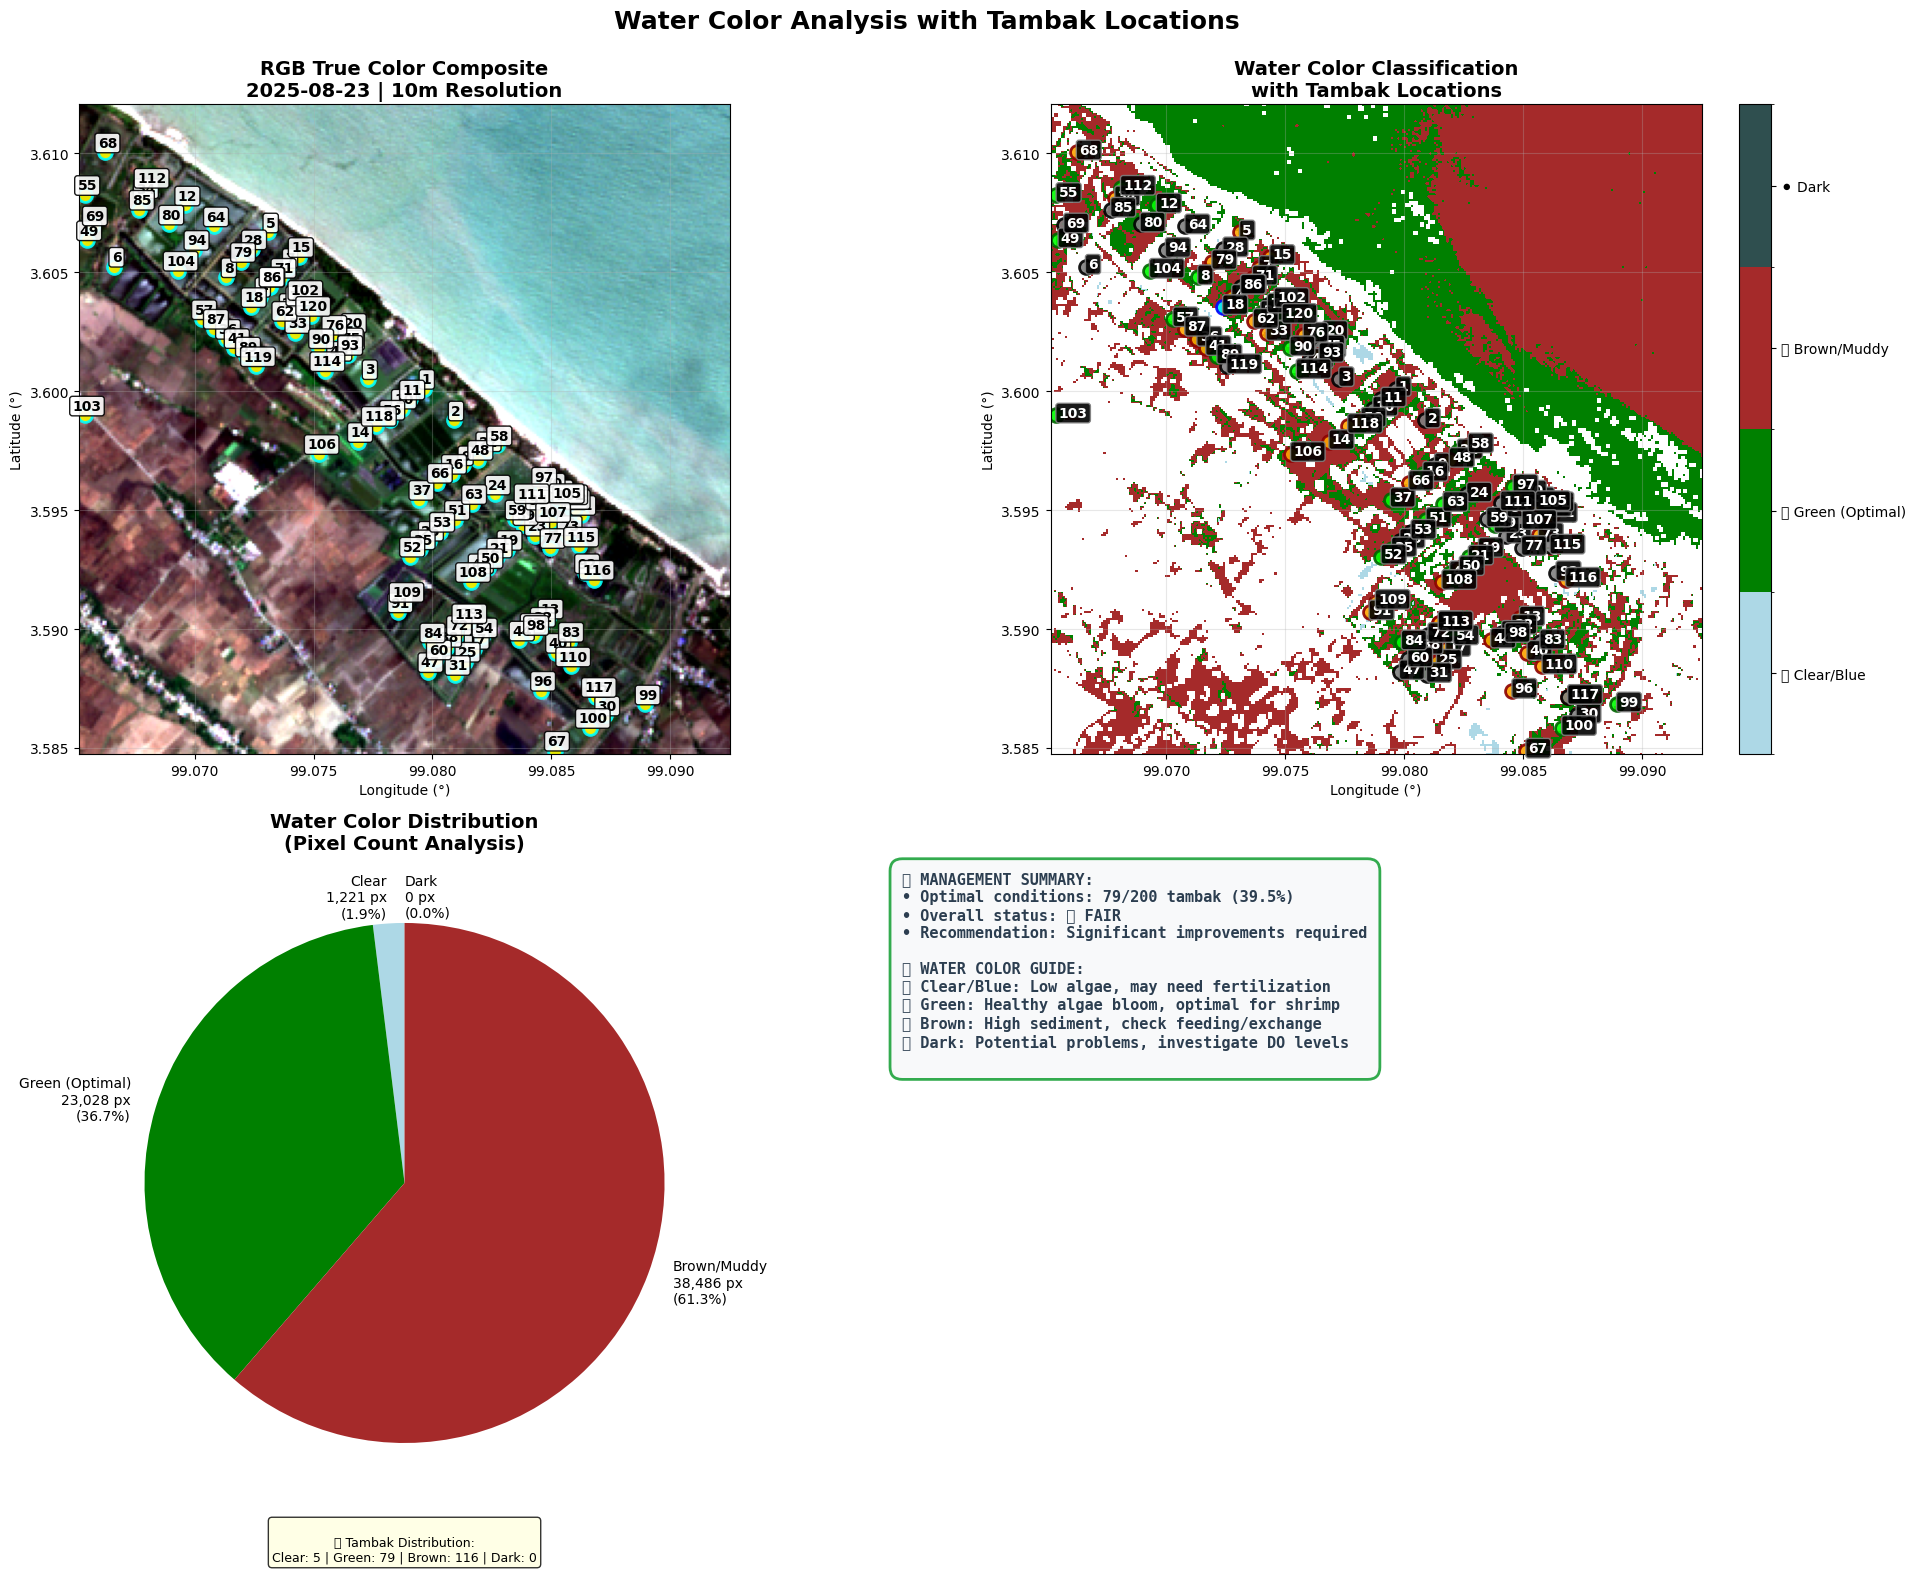


📊 Tambak Water Color Summary:
   • Total tambaks analyzed: 300
   • No Data: 100 tambaks (33.3%)
   • Brown/Muddy: 116 tambaks (38.7%)
   • Green (Optimal): 79 tambaks (26.3%)
   • Clear/Blue: 5 tambaks (1.7%)
🎯 Extracting water color characteristics for 120 tambak locations...
   🟤 Tambak 0: Brown/Muddy - High sediment, monitor feeding
   🟤 Tambak 1: Brown/Muddy - High sediment, monitor feeding
   🟤 Tambak 2: Brown/Muddy - High sediment, monitor feeding
   🟤 Tambak 3: Brown/Muddy - High sediment, monitor feeding
   🟢 Tambak 4: Green - Optimal for shrimp growth
   ⚪ Tambak 5: No color data (invalid pixel)
   🟢 Tambak 6: Green - Optimal for shrimp growth
   🟤 Tambak 7: Brown/Muddy - High sediment, monitor feeding
   ⚪ Tambak 8: No color data (invalid pixel)
   🟢 Tambak 9: Green - Optimal for shrimp growth
   ⚪ Tambak 10: No color data (invalid pixel)
   🟢 Tambak 11: Green - Optimal for shrimp growth
   🟤 Tambak 12: Brown/Muddy - High sediment, monitor feeding
   🟤 Tambak 13: Brown/Mudd

In [74]:
# Step 1: Download Blue Band and Create RGB Composite
if sentinel_items and 'red_data' in locals() and 'green_data' in locals():
    print("🎨 Processing Sentinel-2 data for water color analysis...")
    
    # Get Blue (B02) band URL
    blue_href = planetary_computer.sign(item.assets["B02"].href)
    
    # print(f"   • Using existing Red and Green bands from turbidity analysis")
    # print(f"   • Downloading Blue band (B02) for RGB composite")
    
    # Process Blue band (B02 - 10m resolution)
    with rasterio.open(blue_href) as src_blue:
        # print(f"   • Blue band (B02) - Resolution: {src_blue.res[0]}m")
        
        # Use same window as Red and Green bands for consistency
        if 'window_red' in locals() and window_red is not None:
            # Use same window bounds for consistency
            # STANDARDIZED BOUNDS - Same as other bands
            bounds_utm = rasterio.warp.transform_bounds(
                aoi_gdf.crs, src_blue.crs, *aoi_gdf.total_bounds
            )
            window_blue = rasterio.windows.from_bounds(*bounds_utm, src_blue.transform)
            window_blue = window_blue.intersection(rasterio.windows.Window(0, 0, src_blue.width, src_blue.height))
            blue_data = src_blue.read(1, window=window_blue).astype(np.float32)
        else:
            blue_data = src_blue.read(1).astype(np.float32)
            
        # print(f"   • Blue band shape: {blue_data.shape}")
        # print(f"   • Blue data range: {blue_data.min():.0f} - {blue_data.max():.0f}")
    
    # Ensure all bands have the same shape
    if not (red_data.shape == green_data.shape == blue_data.shape):
        print(f"   ⚠️ Band shape mismatch - Red: {red_data.shape}, Green: {green_data.shape}, Blue: {blue_data.shape}")
        # Resize to match the smallest common shape
        min_height = min(red_data.shape[0], green_data.shape[0], blue_data.shape[0])
        min_width = min(red_data.shape[1], green_data.shape[1], blue_data.shape[1])
        red_data_rgb = red_data[:min_height, :min_width]
        green_data_rgb = green_data[:min_height, :min_width]
        blue_data_rgb = blue_data[:min_height, :min_width]
        print(f"   ✅ Resized all bands to common shape: {red_data_rgb.shape}")
    else:
        red_data_rgb = red_data.copy()
        green_data_rgb = green_data.copy()
        blue_data_rgb = blue_data.copy()
        # print(f"   ✅ All bands have matching shape: {red_data_rgb.shape}")
    
    # Create RGB composite
    print("   • Creating RGB composite...")
    
    # Stack bands into RGB array [Height, Width, 3]
    rgb_raw = np.stack([red_data_rgb, green_data_rgb, blue_data_rgb], axis=-1)
    
    # Remove invalid pixels (values <= 0)
    rgb_valid = np.where(rgb_raw > 0, rgb_raw, np.nan)
    
    # Normalize RGB values for better visualization
    # Apply percentile-based contrast enhancement
    def normalize_band(band, percentiles=(2, 98)):
        valid_pixels = band[~np.isnan(band)]
        if len(valid_pixels) > 0:
            p_low, p_high = np.percentile(valid_pixels, percentiles)
            normalized = np.clip((band - p_low) / (p_high - p_low), 0, 1)
            return normalized
        return band
    
    # Normalize each band independently
    rgb_normalized = np.zeros_like(rgb_valid)
    rgb_normalized[:,:,0] = normalize_band(rgb_valid[:,:,0])  # Red
    rgb_normalized[:,:,1] = normalize_band(rgb_valid[:,:,1])  # Green
    rgb_normalized[:,:,2] = normalize_band(rgb_valid[:,:,2])  # Blue
    
    print(f"\n🌈 RGB Composite Statistics:")
    for i, color in enumerate(['Red', 'Green', 'Blue']):
        valid_vals = rgb_normalized[:,:,i][~np.isnan(rgb_normalized[:,:,i])]
        if len(valid_vals) > 0:
            print(f"   • {color}: {len(valid_vals):,} valid pixels, range {valid_vals.min():.3f} - {valid_vals.max():.3f}")
    
    color_data_available = True
    
else:
    print("❌ No Sentinel-2 data available or missing RGB bands - skipping water color analysis")
    color_data_available = False
# Step 2: Analyze Water Color Characteristics
if color_data_available:
    print("\n🔍 Analyzing water color characteristics...")
    
    # Calculate color dominance (relative contribution of each band)
    print("   • Calculating color dominance...")
    rgb_sum = rgb_normalized.sum(axis=-1)
    rgb_sum = np.where(rgb_sum > 0, rgb_sum, np.nan)  # Avoid division by zero
    
    red_dominance = np.where(~np.isnan(rgb_sum), rgb_normalized[:,:,0] / rgb_sum, np.nan)
    green_dominance = np.where(~np.isnan(rgb_sum), rgb_normalized[:,:,1] / rgb_sum, np.nan)
    blue_dominance = np.where(~np.isnan(rgb_sum), rgb_normalized[:,:,2] / rgb_sum, np.nan)
    
    # Calculate color ratios for water type classification
    print("   • Calculating color ratios...")
    green_red_ratio = np.where((rgb_normalized[:,:,0] > 0) & (~np.isnan(rgb_normalized[:,:,0])), 
                              rgb_normalized[:,:,1] / rgb_normalized[:,:,0], np.nan)
    blue_green_ratio = np.where((rgb_normalized[:,:,1] > 0) & (~np.isnan(rgb_normalized[:,:,1])), 
                               rgb_normalized[:,:,2] / rgb_normalized[:,:,1], np.nan)
    
    # Classify water color for aquaculture
    print("   • Classifying water colors for aquaculture...")
    
    def classify_water_color(red_dom, green_dom, blue_dom, gr_ratio):
        """Classify water color based on spectral characteristics"""
        # Initialize classification array
        color_class = np.full_like(red_dom, np.nan)
        
        # Clear/Blue water (high blue dominance, low green/red ratio)
        clear_mask = (blue_dom > 0.4) & (gr_ratio < 0.8)
        color_class[clear_mask] = 1
        
        # Green water (high green dominance, good green/red ratio)
        green_mask = (green_dom > 0.35) & (gr_ratio > 0.9) & (gr_ratio < 1.5)
        color_class[green_mask] = 2
        
        # Brown/Muddy water (balanced RGB but high overall reflectance, high green/red ratio)
        brown_mask = (gr_ratio > 1.5) | ((red_dom > 0.35) & (green_dom > 0.3))
        color_class[brown_mask] = 3
        
        # Dark water (low overall reflectance)
        rgb_brightness = red_dom + green_dom + blue_dom
        dark_mask = rgb_brightness < 0.3
        color_class[dark_mask] = 4
        
        return color_class
    
    water_color_class = classify_water_color(red_dominance, green_dominance, blue_dominance, green_red_ratio)
    
    # Calculate statistics for each color class
    valid_color_pixels = ~np.isnan(water_color_class)
    if np.any(valid_color_pixels):
        clear_count = np.sum(water_color_class == 1)
        green_count = np.sum(water_color_class == 2)
        brown_count = np.sum(water_color_class == 3)
        dark_count = np.sum(water_color_class == 4)
        total_valid = np.sum(valid_color_pixels)
        
        print(f"\n🎨 Water Color Classification Results:")
        print(f"   🔵 Clear/Blue water: {clear_count:,} pixels ({clear_count/total_valid*100:.1f}%)")
        print(f"   🟢 Green water (optimal): {green_count:,} pixels ({green_count/total_valid*100:.1f}%)")
        print(f"   🟤 Brown/Muddy water: {brown_count:,} pixels ({brown_count/total_valid*100:.1f}%)")
        print(f"   ⚫ Dark water: {dark_count:,} pixels ({dark_count/total_valid*100:.1f}%)")
        
        # Overall water quality assessment
        if green_count/total_valid > 0.5:
            overall_assessment = "🟢 Excellent - Predominantly green water ideal for shrimp"
        elif green_count/total_valid > 0.3:
            overall_assessment = "🟡 Good - Adequate green water with some variations"
        elif clear_count/total_valid > 0.4:
            overall_assessment = "🔵 Concerning - Too much clear water, may lack nutrients"
        elif brown_count/total_valid > 0.4:
            overall_assessment = "🟤 Monitor - High turbidity, check feeding practices"
        else:
            overall_assessment = "⚠️ Mixed - Diverse water conditions, needs attention"
        
        print(f"\n🦐 Aquaculture Assessment: {overall_assessment}")
    
    # Calculate average color characteristics
    valid_red = red_dominance[~np.isnan(red_dominance)]
    valid_green = green_dominance[~np.isnan(green_dominance)]
    valid_blue = blue_dominance[~np.isnan(blue_dominance)]
    valid_gr_ratio = green_red_ratio[~np.isnan(green_red_ratio)]
    
    if len(valid_red) > 0:
        print(f"\n📊 Average Color Characteristics:")
        print(f"   • Red dominance: {np.mean(valid_red):.3f} ± {np.std(valid_red):.3f}")
        print(f"   • Green dominance: {np.mean(valid_green):.3f} ± {np.std(valid_green):.3f}")
        print(f"   • Blue dominance: {np.mean(valid_blue):.3f} ± {np.std(valid_blue):.3f}")
        print(f"   • Green/Red ratio: {np.mean(valid_gr_ratio):.3f} ± {np.std(valid_gr_ratio):.3f}")
    
    # print("✅ Water color analysis completed!")
    
else:
    print("❌ No RGB data available for water color analysis")

# Step 3: Visualize Water Color Results with Enhanced Tambak Plotting
if color_data_available:
    print("\n🖼️ Creating water color visualizations with tambak locations...")
    
    # Create comprehensive figure with tambak location plotting
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('Water Color Analysis with Tambak Locations\n', fontsize=18, fontweight='bold')
    
    # Plot 1: RGB True Color Composite with Tambak Markers
    ax1 = axes[0, 0]
    rgb_display = rgb_normalized.copy()
    rgb_display[np.isnan(rgb_display)] = 0  # Set NaN to black for display
    
    # Create extent for proper geographic plotting
    extent_s2 = [lons_s2.min(), lons_s2.max(), lats_s2.min(), lats_s2.max()]
    
    ax1.imshow(rgb_display, extent=extent_s2, origin='upper')
    ax1.set_title(f'RGB True Color Composite\n{item.datetime.strftime("%Y-%m-%d")} | 10m Resolution', fontweight='bold', fontsize=14)
    ax1.set_xlabel('Longitude (°)')
    ax1.set_ylabel('Latitude (°)')
    ax1.grid(True, alpha=0.3)
    
    # Add tambak points with detailed color coding
    if 'tambak_gdf' in locals() and tambak_gdf is not None:
        tambak_subset_rgb = tambak_gdf.cx[lons_s2.min():lons_s2.max(), lats_s2.min():lats_s2.max()]
        if not tambak_subset_rgb.empty:
            # print(f"   📍 Plotting {len(tambak_subset_rgb)} tambak locations on RGB composite")
            for idx, row in tambak_subset_rgb.iterrows():
                # Enhanced marker styling for better visibility
                ax1.plot(row.geometry.x, row.geometry.y, 'o', 
                        color='white', markersize=10, markeredgecolor='cyan', markeredgewidth=2,
                        markerfacecolor='yellow', alpha=0.9)
                # Add tambak ID labels (same style as temperature visualization)
                ax1.text(row.geometry.x + 0.0001, row.geometry.y + 0.0001, f'{int(row.get("id", idx))}',
                        ha='center', va='bottom', fontsize=10, fontweight='bold',
                        color='black', 
                        bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.9, edgecolor='black', linewidth=1))
    
    # Plot 2: Water Color Classification with Enhanced Tambak Display
    ax2 = axes[0, 1]
    from matplotlib.colors import ListedColormap, BoundaryNorm
    
    colors = ['lightblue', 'green', 'brown', 'darkslategray']  # Clear, Green, Brown, Dark
    cmap_custom = ListedColormap(colors)
    bounds = [0.5, 1.5, 2.5, 3.5, 4.5]
    norm = BoundaryNorm(bounds, cmap_custom.N)
    
    im2 = ax2.imshow(water_color_class, cmap=cmap_custom, norm=norm,
                     extent=extent_s2, origin='upper')
    ax2.set_title('Water Color Classification\nwith Tambak Locations', fontweight='bold', fontsize=14)
    ax2.set_xlabel('Longitude (°)')
    ax2.set_ylabel('Latitude (°)')
    ax2.grid(True, alpha=0.3)
    
    # Add colorbar for classification
    cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
    cbar2.set_ticks([1, 2, 3, 4])
    cbar2.set_ticklabels(['🔵 Clear/Blue', '🟢 Green (Optimal)', '🟤 Brown/Muddy', '⚫ Dark'])
    cbar2.ax.tick_params(labelsize=10)
    
    # Enhanced tambak markers with color-coded status
    if not tambak_subset_rgb.empty:
        # print(f"   🎨 Adding color-coded tambak markers based on water color analysis")
        for idx, row in tambak_subset_rgb.iterrows():
            # Get tambak color classification if available
            tambak_id = int(row.get('id', idx)) - 1  # Convert to 0-based index
            
            if 'tambak_color_class' in locals() and tambak_id < len(tambak_color_class):
                color_class = tambak_color_class[tambak_id]
                
                # Color code based on water color classification
                if color_class == 1:  # Clear/Blue
                    marker_color = 'cyan'
                    edge_color = 'blue'
                    status_text = 'Clear'
                elif color_class == 2:  # Green (Optimal)
                    marker_color = 'lime'
                    edge_color = 'darkgreen'
                    status_text = 'Optimal'
                elif color_class == 3:  # Brown/Muddy
                    marker_color = 'orange'
                    edge_color = 'darkred'
                    status_text = 'Muddy'
                elif color_class == 4:  # Dark
                    marker_color = 'red'
                    edge_color = 'darkred'
                    status_text = 'Dark'
                else:
                    marker_color = 'gray'
                    edge_color = 'black'
                    status_text = 'Unknown'
            else:
                marker_color = 'yellow'
                edge_color = 'black'
                status_text = 'No Data'
            
            # Plot enhanced marker
            ax2.plot(row.geometry.x, row.geometry.y, 'o', 
                    color=marker_color, markersize=10, markeredgecolor=edge_color, 
                    markeredgewidth=2, alpha=0.9)
            
            # Enhanced caption with contrasting background
            caption_bg_color = 'white' if marker_color in ['navy', 'blue'] else 'black'
            caption_text_color = 'black' if caption_bg_color == 'white' else 'white'
            
            ax2.text(row.geometry.x + 0.0001, row.geometry.y + 0.0001, f'{int(row.get("id", idx))}',
                    ha='left', va='center', fontsize=10, fontweight='bold',
                    color=caption_text_color,
                    bbox=dict(boxstyle='round,pad=0.2', facecolor=caption_bg_color, alpha=0.9, edgecolor='gray', linewidth=1))

    # Plot 3: Water Color Distribution Analysis
    ax3 = axes[1, 0]
    
    # Calculate detailed color statistics
    valid_color_pixels = ~np.isnan(water_color_class)
    if np.any(valid_color_pixels):
        clear_count = np.sum(water_color_class == 1)
        green_count = np.sum(water_color_class == 2)
        brown_count = np.sum(water_color_class == 3)
        dark_count = np.sum(water_color_class == 4)
        total_valid = np.sum(valid_color_pixels)
        
        # Create pie chart
        sizes = [clear_count, green_count, brown_count, dark_count]
        labels = [f'Clear\n{clear_count:,} px\n({clear_count/total_valid*100:.1f}%)',
                  f'Green (Optimal)\n{green_count:,} px\n({green_count/total_valid*100:.1f}%)',
                  f'Brown/Muddy\n{brown_count:,} px\n({brown_count/total_valid*100:.1f}%)',
                  f'Dark\n{dark_count:,} px\n({dark_count/total_valid*100:.1f}%)']
        colors_pie = ['lightblue', 'green', 'brown', 'darkslategray']
        
        wedges, texts, autotexts = ax3.pie(sizes, labels=labels, colors=colors_pie, autopct='',
                                          startangle=90, textprops={'fontsize': 10})
        ax3.set_title('Water Color Distribution\n(Pixel Count Analysis)', fontweight='bold', fontsize=14)
        
        # Add tambak distribution overlay
        if 'tambak_color_class' in locals():
            tambak_clear = sum(1 for c in tambak_color_class if c == 1)
            tambak_green = sum(1 for c in tambak_color_class if c == 2)
            tambak_brown = sum(1 for c in tambak_color_class if c == 3)
            tambak_dark = sum(1 for c in tambak_color_class if c == 4)
            
            tambak_text = f"\n🏊 Tambak Distribution:\nClear: {tambak_clear} | Green: {tambak_green} | Brown: {tambak_brown} | Dark: {tambak_dark}"
            ax3.text(0, -1.3, tambak_text, ha='center', va='top', fontsize=9, 
                    bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    else:
        ax3.text(0.5, 0.5, 'No valid water color data for analysis', 
                ha='center', va='center', fontsize=12)
    
    # Plot 4: Individual Tambak Water Color Report
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    # Create comprehensive tambak-by-tambak analysis
    tambak_analysis_text = ""
    
    # Add aquaculture management insights
    if 'tambak_color_class' in locals():
        valid_tambak_colors = [c for c in tambak_color_class if (not np.isnan(c) if isinstance(c, (int, float)) else c != 'No Data')]
        if valid_tambak_colors:
            optimal_tambaks = sum(1 for c in valid_tambak_colors if c == 2)
            total_valid_tambaks = len(valid_tambak_colors)
            optimal_percentage = (optimal_tambaks / total_valid_tambaks) * 100 if total_valid_tambaks > 0 else 0
            
            tambak_analysis_text += f"📊 MANAGEMENT SUMMARY:\n"
            tambak_analysis_text += f"• Optimal conditions: {optimal_tambaks}/{total_valid_tambaks} tambak ({optimal_percentage:.1f}%)\n"
            
            if optimal_percentage > 70:
                overall_status = "🟢 EXCELLENT"
                management_action = "Continue current management practices"
            elif optimal_percentage > 50:
                overall_status = "🟡 GOOD"
                management_action = "Minor adjustments needed"
            elif optimal_percentage > 30:
                overall_status = "🟠 FAIR"
                management_action = "Significant improvements required"
            else:
                overall_status = "🔴 POOR"
                management_action = "Immediate intervention needed"
            
            tambak_analysis_text += f"• Overall status: {overall_status}\n"
            tambak_analysis_text += f"• Recommendation: {management_action}\n"
    
    # Add interpretation guide
    tambak_analysis_text += f"\n💡 WATER COLOR GUIDE:\n"
    tambak_analysis_text += f"🔵 Clear/Blue: Low algae, may need fertilization\n"
    tambak_analysis_text += f"🟢 Green: Healthy algae bloom, optimal for shrimp\n"
    tambak_analysis_text += f"🟤 Brown: High sediment, check feeding/exchange\n"
    tambak_analysis_text += f"⚫ Dark: Potential problems, investigate DO levels\n"
    
    # ax4.text(0.05, 0.95, tambak_analysis_text, transform=ax4.transAxes, 
    #         fontsize=10, verticalalignment='top', fontfamily='monospace',
    #         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', alpha=0.8))

    ax4.text(0.05, 0.98, tambak_analysis_text, transform=ax4.transAxes, 
        fontsize=11, verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round,pad=0.8', facecolor='#f8f9fa', alpha=0.95, 
             edgecolor='#28a745', linewidth=2),
        color='#2c3e50', weight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # print("✅ Enhanced water color visualization with tambak locations completed!")
    
    # Display summary statistics
    if 'tambak_color_class' in locals() and 'tambak_color_status' in locals():
        print(f"\n📊 Tambak Water Color Summary:")
        print(f"   • Total tambaks analyzed: {len(tambak_color_class)}")
        
        # Count each color class
        color_counts = {}
        for color_class in tambak_color_class:
            if isinstance(color_class, (int, float)) and not np.isnan(color_class):
                color_name = {1: 'Clear/Blue', 2: 'Green (Optimal)', 3: 'Brown/Muddy', 4: 'Dark'}.get(int(color_class), 'Unknown')
            else:
                color_name = 'No Data'
            color_counts[color_name] = color_counts.get(color_name, 0) + 1
        
        for color_name, count in color_counts.items():
            percentage = (count / len(tambak_color_class)) * 100
            print(f"   • {color_name}: {count} tambaks ({percentage:.1f}%)")
    
    # Store enhanced analysis data
    enhanced_color_analysis = {
        'rgb_composite': rgb_normalized,
        'color_classification': water_color_class,
        'tambak_color_data': {
            'tambak_color_class': tambak_color_class if 'tambak_color_class' in locals() else None,
            'tambak_color_status': tambak_color_status if 'tambak_color_status' in locals() else None,
        },
        'spatial_extent': extent_s2,
        'analysis_date': item.datetime.strftime("%Y-%m-%d"),
        'resolution': '10m',
        'data_source': 'Sentinel-2 L2A'
    }
    
    # print(f"\n💾 Enhanced color analysis data saved to 'enhanced_color_analysis'")
    
else:
    print("❌ No color data available for enhanced visualization")
    print("🔄 Please run the water color calculation steps first")

# Step 4: Extract Water Color for Each Tambak Location
if color_data_available and 'tambak_gdf' in locals() and tambak_gdf is not None:
    print(f"🎯 Extracting water color characteristics for {len(tambak_gdf)} tambak locations...")
    
    tambak_color_class = []
    tambak_color_status = []
    tambak_red_dominance = []
    tambak_green_dominance = []
    tambak_blue_dominance = []
    tambak_green_red_ratio = []
    
    # Color class labels for interpretation
    color_labels = {
        1: 'clear_blue',
        2: 'green_optimal', 
        3: 'brown_muddy',
        4: 'dark'
    }
    
    color_descriptions = {
        1: 'Clear/Blue - Low productivity, may need nutrients',
        2: 'Green - Optimal for shrimp growth',
        3: 'Brown/Muddy - High sediment, monitor feeding',
        4: 'Dark - Potential water quality issues'
    }
    
    color_icons = {
        1: '🔵',
        2: '🟢',
        3: '🟤', 
        4: '⚫'
    }
    
    # Use same projection as Sentinel-2 data
    if tambak_gdf.crs != crs_s2:
        tambak_projected_color = tambak_gdf.to_crs(crs_s2)
    else:
        tambak_projected_color = tambak_gdf.copy()
    
    for idx, tambak in tambak_projected_color.iterrows():
        # Get tambak coordinates (use centroid for all geometry types)
        if tambak.geometry.geom_type == 'Point':
            x, y = tambak.geometry.x, tambak.geometry.y
        else:
            x, y = tambak.geometry.centroid.x, tambak.geometry.centroid.y
        
        # Convert geographic coordinates to pixel indices
        col, row = ~transform_s2 * (x, y)
        col, row = int(round(col)), int(round(row))
        
        # Extract color characteristics if pixel is within image bounds
        if (0 <= row < water_color_class.shape[0] and 0 <= col < water_color_class.shape[1]):
            color_class_val = water_color_class[row, col]
            red_dom_val = red_dominance[row, col]
            green_dom_val = green_dominance[row, col]
            blue_dom_val = blue_dominance[row, col]
            gr_ratio_val = green_red_ratio[row, col]
            
            if not np.isnan(color_class_val):
                color_class_int = int(color_class_val)
                tambak_color_class.append(color_class_int)
                tambak_color_status.append(color_labels.get(color_class_int, 'unknown'))
                tambak_red_dominance.append(red_dom_val if not np.isnan(red_dom_val) else None)
                tambak_green_dominance.append(green_dom_val if not np.isnan(green_dom_val) else None)
                tambak_blue_dominance.append(blue_dom_val if not np.isnan(blue_dom_val) else None)
                tambak_green_red_ratio.append(gr_ratio_val if not np.isnan(gr_ratio_val) else None)
                
                icon = color_icons.get(color_class_int, '❓')
                description = color_descriptions.get(color_class_int, 'Unknown')
                print(f"   {icon} Tambak {idx}: {description}")
                # print(f"      → RGB dominance: R={red_dom_val:.3f}, G={green_dom_val:.3f}, B={blue_dom_val:.3f}")
                
            else:
                tambak_color_class.append(np.nan)
                tambak_color_status.append('no_data')
                tambak_red_dominance.append(None)
                tambak_green_dominance.append(None) 
                tambak_blue_dominance.append(None)
                tambak_green_red_ratio.append(None)
                print(f"   ⚪ Tambak {idx}: No color data (invalid pixel)")
        else:
            tambak_color_class.append(np.nan)
            tambak_color_status.append('Outside Coverage')
            tambak_red_dominance.append(None)
            tambak_green_dominance.append(None)
            tambak_blue_dominance.append(None)
            tambak_green_red_ratio.append(None)
            print(f"   ❌ Tambak {idx}: Outside Sentinel-2 color coverage")
    
    # Add color data to tambak GeoDataFrame
    tambak_gdf['color_class'] = tambak_color_class
    tambak_gdf['color_status'] = tambak_color_status
    tambak_gdf['red_dominance'] = tambak_red_dominance
    tambak_gdf['green_dominance'] = tambak_green_dominance
    tambak_gdf['blue_dominance'] = tambak_blue_dominance
    tambak_gdf['green_red_ratio'] = tambak_green_red_ratio
    
    # Calculate summary statistics for valid color measurements
    valid_color_classes = [c for c in tambak_color_class if not np.isnan(c)]
    
    if valid_color_classes:
        print(f"\n🦐 AQUACULTURE WATER COLOR SUMMARY:")
        clear_tambaks = sum(1 for c in valid_color_classes if c == 1)
        green_tambaks = sum(1 for c in valid_color_classes if c == 2)
        brown_tambaks = sum(1 for c in valid_color_classes if c == 3)
        dark_tambaks = sum(1 for c in valid_color_classes if c == 4)
        total_valid = len(valid_color_classes)
        
        print(f"   🔵 Clear/Blue water: {clear_tambaks}/{total_valid} tambaks ({clear_tambaks/total_valid*100:.1f}%)")
        print(f"   🟢 Green water (optimal): {green_tambaks}/{total_valid} tambaks ({green_tambaks/total_valid*100:.1f}%)")
        print(f"   🟤 Brown/Muddy water: {brown_tambaks}/{total_valid} tambaks ({brown_tambaks/total_valid*100:.1f}%)")
        print(f"   ⚫ Dark water: {dark_tambaks}/{total_valid} tambaks ({dark_tambaks/total_valid*100:.1f}%)")
        
        # Management recommendations
        if green_tambaks/total_valid > 0.7:
            recommendation = "✅ Excellent water color conditions - maintain current practices"
        elif green_tambaks/total_valid > 0.5:
            recommendation = "🟡 Good conditions with room for improvement"
        elif clear_tambaks/total_valid > 0.5:
            recommendation = "🔵 Consider nutrient supplementation to boost algae growth"
        elif brown_tambaks/total_valid > 0.5:
            recommendation = "🟤 Monitor feeding rates and consider water exchange"
        else:
            recommendation = "⚠️ Mixed conditions - individual pond management needed"
        
        print(f"\n💡 Management Recommendation: {recommendation}")
        
        tambaks_with_color = True
    else:
        print("\n❌ No valid color measurements found for any tambak!")
        tambaks_with_color = False
        
else:
    tambaks_with_color = False
    print("❌ No color data or tambak locations available for analysis")

### Chlorophyll-a

Chlorophyll-a is a critical indicator of phytoplankton biomass and primary productivity in aquaculture systems. It directly relates to oxygen production, food availability, and overall pond ecosystem health.

**Method Used**: Two-Band Red/Green Ratio Algorithm
- **Formula**: `Chl-a = a * (Red/Green)^b + c`
- **Data Source**: Sentinel-2 L2A (B03-Green, B04-Red)
- **Resolution**: 10m spatial resolution
- **Advantage**: Robust for turbid aquaculture waters, less sensitive to atmospheric effects

**Optimal Ranges for Shrimp**:
- 🔵 **Low (< 5 μg/L)**: Nutrient-poor, concerning for growth
- 🟢 **Optimal (5-20 μg/L)**: Ideal for shrimp farming
- 🟡 **Moderate (20-50 μg/L)**: High productivity, monitor oxygen levels
- 🔴 **High (> 50 μg/L)**: Algae bloom risk, manage carefully

🌊 Setting up Chlorophyll-a Analysis...

🎯 Using Two-Band Chlorophyll-a Algorithm (Red/Green ratio)

🧮 Calculating Chlorophyll-a using Two-Band Algorithm...

📈 Chlorophyll-a Statistics:
   • Min: 9.13 μg/L
   • Max: 41.38 μg/L
   • Mean: 20.43 μg/L
   • Median: 20.78 μg/L
   • Std: 3.97 μg/L

🎯 Chlorophyll-a Classification:
   • Moderate: 51,528 pixels (55.8%)
   • No Data: 19 pixels (0.0%)
   • Optimal: 40,868 pixels (44.2%)

🗺️ Creating enhanced chlorophyll-a visualization with tambak locations...


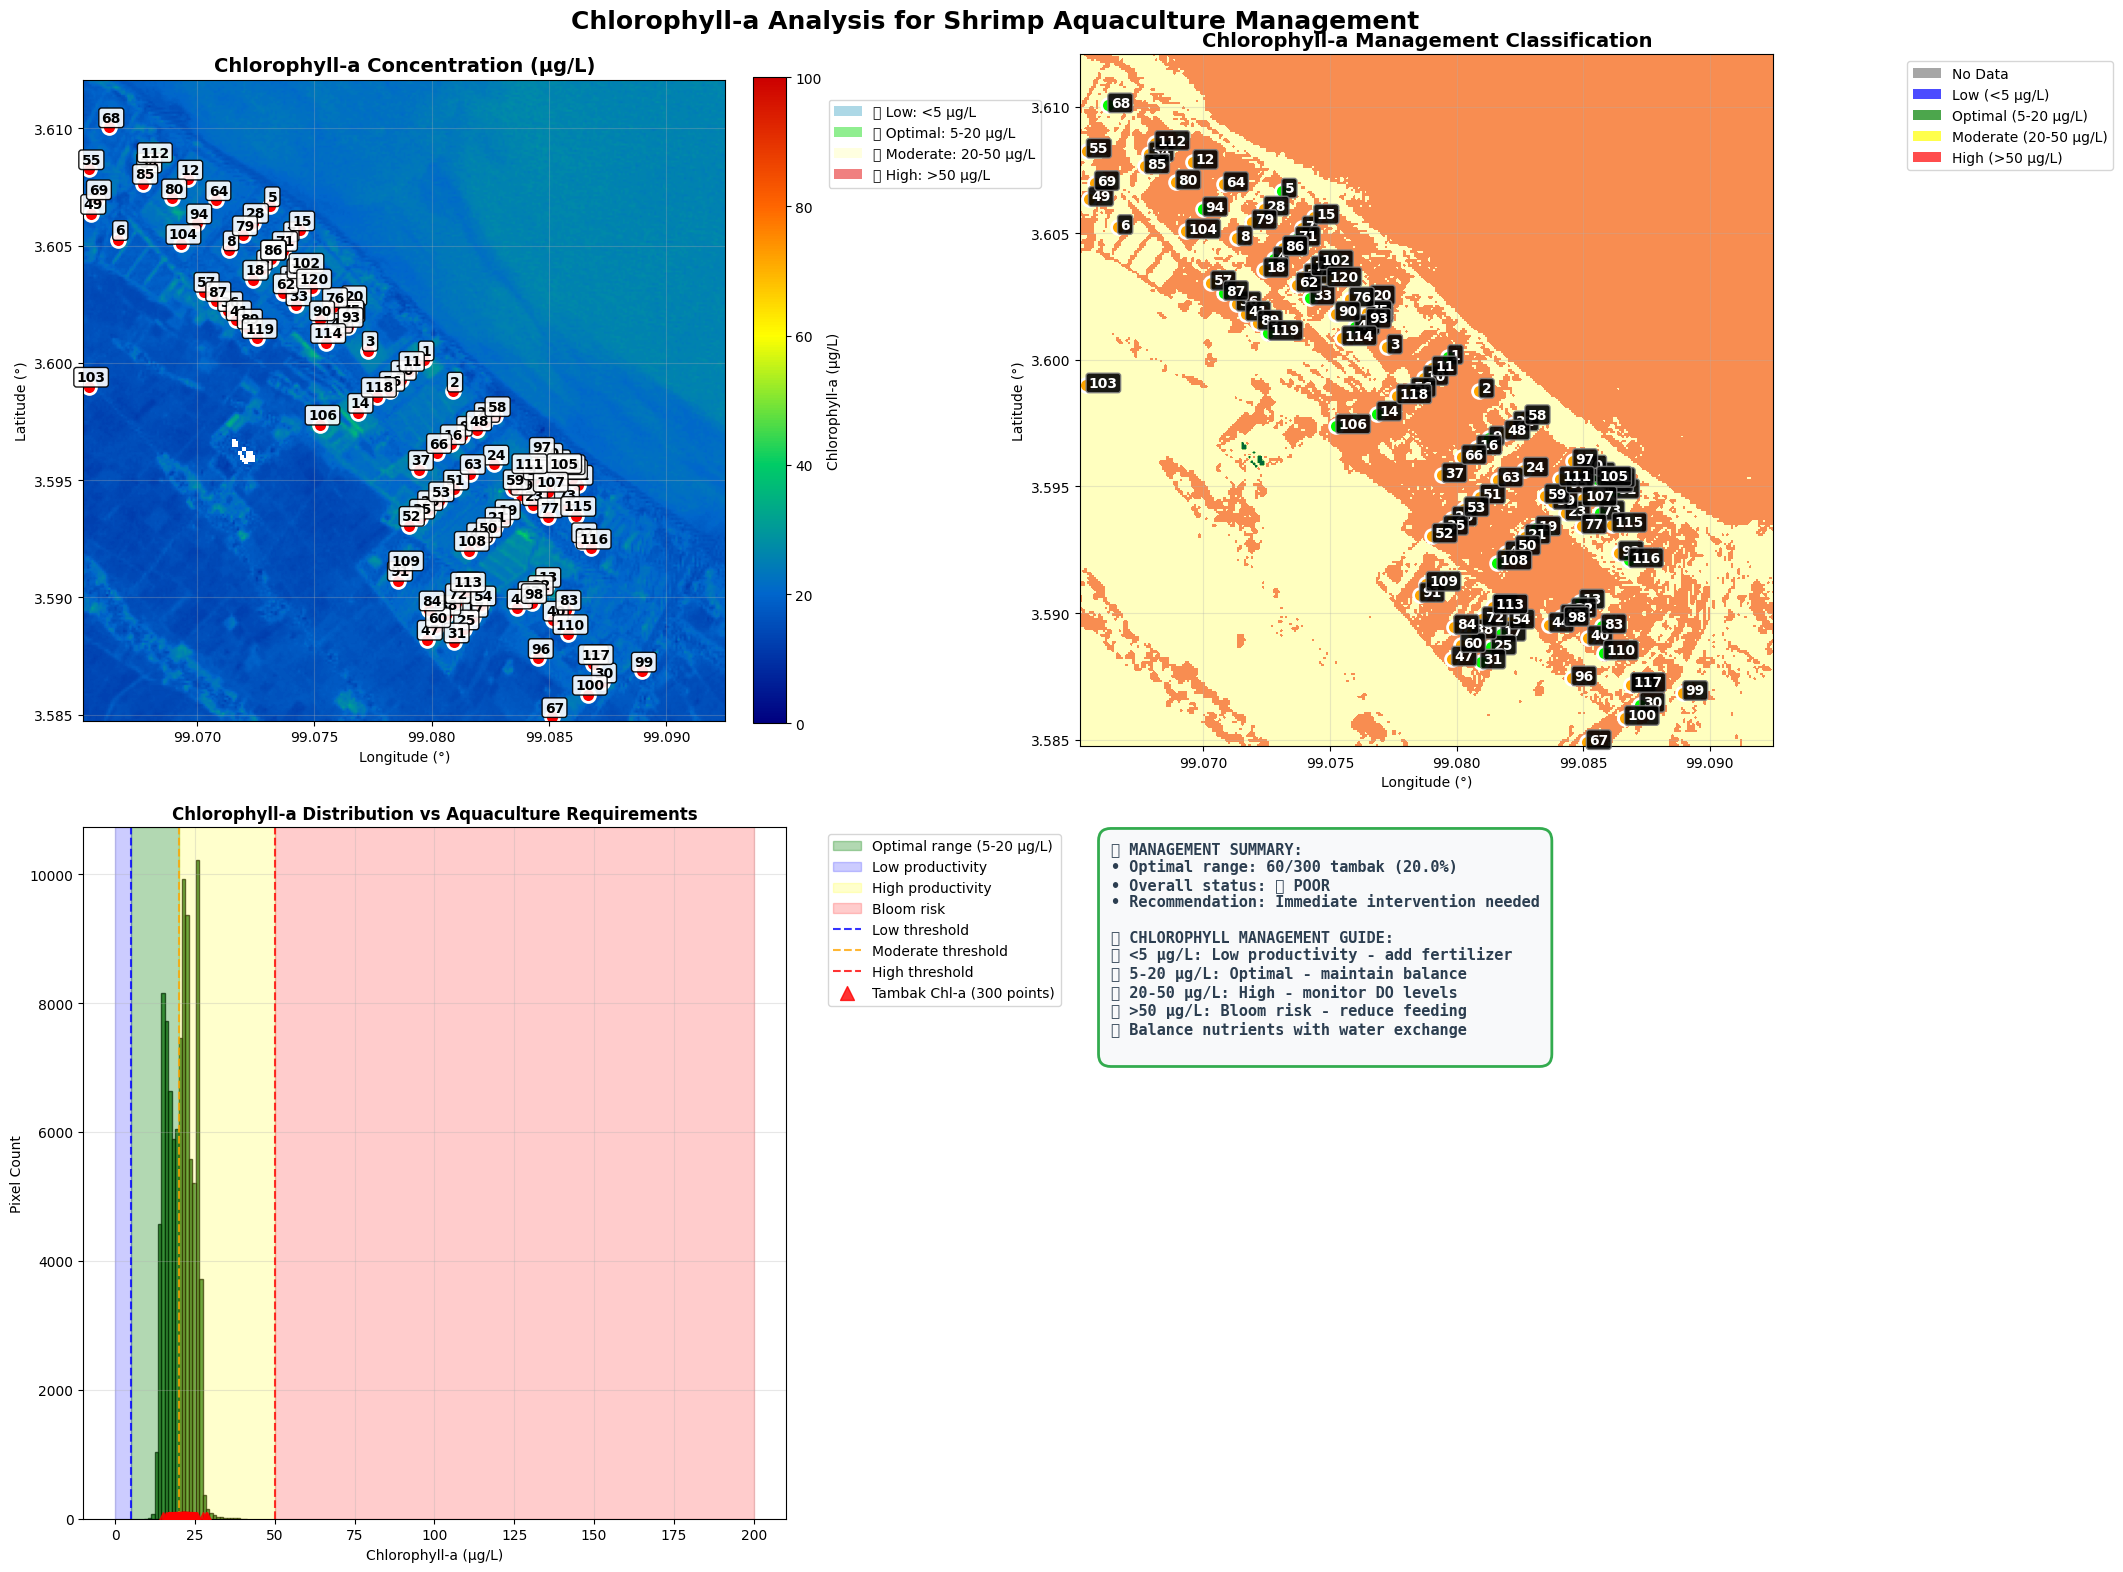


📊 Tambak Chlorophyll-a Summary:
   • Total tambaks analyzed: 300
   • Optimal: 60 tambaks (20.0%)
   • High Productivity: 240 tambaks (80.0%)

🎯 Extracting chlorophyll-a for 120 tambak locations...
   🟡 Tambak 0: 27.5 μg/L (High productivity - monitor oxygen)
   🟡 Tambak 1: 24.2 μg/L (High productivity - monitor oxygen)
   🟡 Tambak 2: 26.1 μg/L (High productivity - monitor oxygen)
   🟡 Tambak 3: 24.0 μg/L (High productivity - monitor oxygen)
   🟡 Tambak 4: 23.1 μg/L (High productivity - monitor oxygen)
   🟢 Tambak 5: 17.6 μg/L (Optimal - ideal for shrimp growth)
   🟡 Tambak 6: 21.1 μg/L (High productivity - monitor oxygen)
   🟡 Tambak 7: 22.0 μg/L (High productivity - monitor oxygen)
   🟡 Tambak 8: 21.6 μg/L (High productivity - monitor oxygen)
   🟡 Tambak 9: 22.6 μg/L (High productivity - monitor oxygen)
   🟡 Tambak 10: 22.2 μg/L (High productivity - monitor oxygen)
   🟡 Tambak 11: 22.3 μg/L (High productivity - monitor oxygen)
   🟡 Tambak 12: 29.6 μg/L (High productivity - monitor o

In [75]:
# Step 1: Load and Process Sentinel-2 Bands for Chlorophyll-a
import numpy as np
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt

# Define band names for chlorophyll-a analysis
chlorophyll_bands = ['B03', 'B04', 'B05']  # Green, Red, RedEdge1
print("🌊 Setting up Chlorophyll-a Analysis...")
# print(f"Required Bands: {chlorophyll_bands}")

# Check if we have the required bands from Sentinel-2
# print("✅ Found Sentinel-2 red and green bands")

# Use existing loaded bands
if 'red_data' in locals() and 'green_data' in locals():
    chlorophyll_data = {
        'green': green_data,  # Green band (B03)
        'red': red_data       # Red band (B04)
    }
    
    print(f"\n🎯 Using Two-Band Chlorophyll-a Algorithm (Red/Green ratio)")
    # print(f"Green band shape: {green_data.shape}")
    # print(f"Red band shape: {red_data.shape}")
    
    # Get dimensions
    height, width = green_data.shape
    # print(f"Image dimensions: {width} x {height}")
    
    # Sample some pixel values
    if height > 0 and width > 0:
        center_y, center_x = height // 2, width // 2
        sample_area = slice(max(0, center_y-2), min(height, center_y+3)), slice(max(0, center_x-2), min(width, center_x+3))
        
        # # print("\n📊 Sample pixel values (center area):")
        # for band_name, band_data in chlorophyll_data.items():
        #     if band_data.size > 0:
        #         sample_vals = band_data[sample_area]
        #         if sample_vals.size > 0:
        #             print(f"   • {band_name.upper()}: min={sample_vals.min():.0f}, max={sample_vals.max():.0f}, mean={sample_vals.mean():.0f}")
        #         else:
        #             print(f"   • {band_name.upper()}: No valid data in sample area")
        #     else:
        #         print(f"   • {band_name.upper()}: Empty band data")

        # print("✅ Ready for two-band chlorophyll-a calculation!")
    else:
        print("❌ Invalid band dimensions")
        chlorophyll_data = {}
else:
    print("❌ No Sentinel-2 bands available for chlorophyll analysis")
    chlorophyll_data = {}

# Step 2: Calculate Chlorophyll-a using Two-Band Red/Green Algorithm
if len(chlorophyll_data) >= 2:
    print("\n🧮 Calculating Chlorophyll-a using Two-Band Algorithm...")
    
    # Extract band arrays
    green = chlorophyll_data['green'].astype(np.float32)
    red = chlorophyll_data['red'].astype(np.float32)
    
    # Convert to reflectance (scale factor for Sentinel-2 L2A is 0.0001)
    green_refl = green * 0.0001
    red_refl = red * 0.0001
    
    # Apply masks to avoid division by zero and invalid values
    valid_mask = (green_refl > 0) & (red_refl > 0) & (green_refl < 1) & (red_refl < 1)
    
    # print(f"Valid pixels: {valid_mask.sum():,} / {valid_mask.size:,} ({100*valid_mask.sum()/valid_mask.size:.1f}%)")
    
    # Initialize chlorophyll array
    chlorophyll_a = np.full_like(green_refl, np.nan)
    
    # Two-band algorithm optimized for inland/coastal waters (Case 2 waters)
    # Using empirical relationship: Chl-a = a * (Red/Green)^b + c
    # Based on Gitelson et al. (2008) for turbid productive waters
    a_coeff = 25.28   # Empirical coefficient
    b_coeff = -1.124  # Power coefficient
    c_coeff = -7.38   # Offset
    
    # Alternative: Simple ratio approach for aquaculture
    # Chl-a = 10 * (Red/Green - 0.7) for typical pond conditions
    
    # Calculate where data is valid
    if valid_mask.any():
        # Calculate red/green ratio
        ratio = red_refl[valid_mask] / green_refl[valid_mask]
        
        # Apply two-band algorithm
        # Method 1: Power law relationship (more sophisticated)
        chlorophyll_a[valid_mask] = a_coeff * (ratio ** b_coeff) + c_coeff
        
        # Apply realistic bounds for chlorophyll-a (0-200 μg/L)
        chlorophyll_a = np.clip(chlorophyll_a, 0, 200)
        
        # For very low values, apply alternative simple ratio
        low_chl_mask = (chlorophyll_a < 1) & valid_mask
        if low_chl_mask.any():
            simple_ratio = red_refl[low_chl_mask] / green_refl[low_chl_mask]
            chlorophyll_a[low_chl_mask] = np.maximum(0, 15 * (simple_ratio - 0.65))
        
        # Calculate statistics
        valid_chl = chlorophyll_a[~np.isnan(chlorophyll_a)]
        print(f"\n📈 Chlorophyll-a Statistics:")
        print(f"   • Min: {valid_chl.min():.2f} μg/L")
        print(f"   • Max: {valid_chl.max():.2f} μg/L")
        print(f"   • Mean: {valid_chl.mean():.2f} μg/L")
        print(f"   • Median: {np.median(valid_chl):.2f} μg/L")
        print(f"   • Std: {valid_chl.std():.2f} μg/L")

        # Classify chlorophyll levels
        chlorophyll_class = np.full_like(chlorophyll_a, 'No Data', dtype=object)
        chlorophyll_class[(chlorophyll_a >= 0) & (chlorophyll_a < 5)] = 'Low'
        chlorophyll_class[(chlorophyll_a >= 5) & (chlorophyll_a <= 20)] = 'Optimal'
        chlorophyll_class[(chlorophyll_a > 20) & (chlorophyll_a <= 50)] = 'Moderate'
        chlorophyll_class[chlorophyll_a > 50] = 'High'
        
        print(f"\n🎯 Chlorophyll-a Classification:")
        unique, counts = np.unique(chlorophyll_class, return_counts=True)
        for cls, count in zip(unique, counts):
            pct = 100 * count / chlorophyll_class.size
            print(f"   • {cls}: {count:,} pixels ({pct:.1f}%)")
        
        # print("✅ Chlorophyll-a calculation completed!")
    else:
        print("❌ No valid pixels found for chlorophyll calculation")
else:
    print("❌ Cannot calculate chlorophyll-a - missing required bands")

# Step 3: Enhanced Chlorophyll-a Visualization for Aquaculture Management with Tambak Locations

# Check if chlorophyll data is available from previous processing
chlorophyll_data_available = 'chlorophyll_a' in locals() and chlorophyll_a is not None

if chlorophyll_data_available:
    print("\n🗺️ Creating enhanced chlorophyll-a visualization with tambak locations...")
    
    # Create comprehensive visualization figure
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('Chlorophyll-a Analysis for Shrimp Aquaculture Management', fontsize=18, fontweight='bold')
    
    # Define aquaculture-optimized colormap for chlorophyll
    colors_chl = ['#000080', '#0066CC', '#00CC66', '#FFFF00', '#FF6600', '#CC0000']
    chl_cmap = LinearSegmentedColormap.from_list('chlorophyll', colors_chl)
    
    # 1. Chlorophyll-a concentration map with Tambak Markers
    ax1 = axes[0, 0]
    extent_chl = [lons_s2.min(), lons_s2.max(), lats_s2.min(), lats_s2.max()]
    
    im1 = ax1.imshow(chlorophyll_a, cmap=chl_cmap, vmin=0, vmax=100, 
                     extent=extent_chl, origin='upper')
    ax1.set_title('Chlorophyll-a Concentration (μg/L)', fontweight='bold', fontsize=14)
    ax1.set_xlabel('Longitude (°)')
    ax1.set_ylabel('Latitude (°)')
    ax1.grid(True, alpha=0.3)
    cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
    cbar1.set_label('Chlorophyll-a (μg/L)')
    
    # Add chlorophyll range annotations as legend
    legend_elements = []
    chl_names = ['🔵 Low: <5 μg/L', '🟢 Optimal: 5-20 μg/L', '🟡 Moderate: 20-50 μg/L', '🔴 High: >50 μg/L']
    chl_colors = ['lightblue', 'lightgreen', 'lightyellow', 'lightcoral']
    for name, color in zip(chl_names, chl_colors):
        legend_elements.append(Rectangle((0, 0), 1, 1, facecolor=color, alpha=1, label=name))
    ax1.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.15, 0.98))
    
    # Add tambak points with enhanced visibility
    if 'tambak_gdf' in locals() and tambak_gdf is not None:
        tambak_subset_chl = tambak_gdf.cx[lons_s2.min():lons_s2.max(), lats_s2.min():lats_s2.max()]
        if not tambak_subset_chl.empty:
            # print(f"   📍 Plotting {len(tambak_subset_chl)} tambak locations on chlorophyll map")
            for idx, row in tambak_subset_chl.iterrows():
                # Enhanced dot with white border for contrast
                ax1.plot(row.geometry.x, row.geometry.y, 'o', 
                        color='red', markersize=10, markeredgecolor='white', markeredgewidth=2)
                # Enhanced caption with background for better visibility
                ax1.text(row.geometry.x + 0.0001, row.geometry.y + 0.0001, f'{int(row.get("id", idx))}',
                        ha='center', va='bottom', fontsize=10, fontweight='bold',
                        color='black', 
                        bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.9, edgecolor='black', linewidth=1))
    
    # 2. Management classification map with Chlorophyll-coded Tambak Markers
    ax2 = axes[0, 1]
    
    # Create chlorophyll classification from data
    chl_class = np.full_like(chlorophyll_a, 'No Data', dtype=object)
    valid_mask = ~np.isnan(chlorophyll_a)
    chl_class[valid_mask & (chlorophyll_a < 5)] = 'Low'
    chl_class[valid_mask & (chlorophyll_a >= 5) & (chlorophyll_a <= 20)] = 'Optimal'
    chl_class[valid_mask & (chlorophyll_a > 20) & (chlorophyll_a <= 50)] = 'Moderate'
    chl_class[valid_mask & (chlorophyll_a > 50)] = 'High'
    
    # Map classifications to numeric values
    class_colors = {'No Data': 0, 'Low': 1, 'Optimal': 2, 'Moderate': 3, 'High': 4}
    chlorophyll_numeric = np.full_like(chlorophyll_a, 0, dtype=int)
    for class_name, class_val in class_colors.items():
        mask = (chl_class == class_name)
        chlorophyll_numeric[mask] = class_val
    
    class_cmap = plt.cm.get_cmap('RdYlGn_r', 5)
    im2 = ax2.imshow(chlorophyll_numeric, cmap=class_cmap, vmin=0, vmax=4,
                     extent=extent_chl, origin='upper')
    ax2.set_title('Chlorophyll-a Management Classification', fontweight='bold', fontsize=14)
    ax2.set_xlabel('Longitude (°)')
    ax2.set_ylabel('Latitude (°)')
    ax2.grid(True, alpha=0.3)
    
    # Custom legend for classification
    legend_elements = []
    class_names = ['No Data', 'Low (<5 μg/L)', 'Optimal (5-20 μg/L)', 'Moderate (20-50 μg/L)', 'High (>50 μg/L)']
    class_colors_rgb = ['gray', 'blue', 'green', 'yellow', 'red']
    for i, (name, color) in enumerate(zip(class_names, class_colors_rgb)):
        legend_elements.append(Rectangle((0, 0), 1, 1, facecolor=color, alpha=0.7, label=name))
    ax2.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.5, 1))
    
    # Enhanced tambak markers with chlorophyll-coded colors
    if not tambak_subset_chl.empty:
        # print(f"   🎨 Adding chlorophyll-coded tambak markers")
        for idx, row in tambak_subset_chl.iterrows():
            # Get tambak chlorophyll if available
            tambak_id = int(row.get('id', idx)) - 1  # Convert to 0-based index
            
            if 'tambak_chl_values' in locals() and tambak_id < len(tambak_chl_values):
                chl_val = tambak_chl_values[tambak_id]
                
                # Color code based on chlorophyll classification
                if np.isnan(chl_val):
                    marker_color = 'gray'
                elif chl_val < 5:  # Low
                    marker_color = 'blue'
                elif 5 <= chl_val <= 20:  # Optimal
                    marker_color = 'lime'
                elif 20 < chl_val <= 50:  # Moderate
                    marker_color = 'orange'
                else:  # High
                    marker_color = 'red'
            else:
                marker_color = 'gray'
            
            # Enhanced dot with white border
            ax2.plot(row.geometry.x, row.geometry.y, 'o', 
                    color=marker_color, markersize=10, markeredgecolor='white', markeredgewidth=2)
            
            # Enhanced caption with contrasting background
            caption_bg_color = 'white' if marker_color in ['blue'] else 'black'
            caption_text_color = 'black' if caption_bg_color == 'white' else 'white'
            
            ax2.text(row.geometry.x + 0.0001, row.geometry.y + 0.0001, f'{int(row.get("id", idx))}',
                    ha='left', va='center', fontsize=10, fontweight='bold',
                    color=caption_text_color,
                    bbox=dict(boxstyle='round,pad=0.2', facecolor=caption_bg_color, alpha=0.9, edgecolor='gray', linewidth=1))
    
    # 3. Histogram with aquaculture tolerance ranges
    ax3 = axes[1, 0]
    valid_chl = chlorophyll_a[~np.isnan(chlorophyll_a)]
    
    if len(valid_chl) > 0:
        n, bins, patches = ax3.hist(valid_chl, bins=30, alpha=0.7, color='darkgreen', edgecolor='black')
        
        # Add aquaculture management zones
        ax3.axvspan(5, 20, alpha=0.3, color='green', label='Optimal range (5-20 μg/L)')
        ax3.axvspan(0, 5, alpha=0.2, color='blue', label='Low productivity')  
        ax3.axvspan(20, 50, alpha=0.2, color='yellow', label='High productivity')
        ax3.axvspan(50, 200, alpha=0.2, color='red', label='Bloom risk')
        
        # Add threshold lines
        ax3.axvline(5, color='blue', linestyle='--', alpha=0.8, label='Low threshold')
        ax3.axvline(20, color='orange', linestyle='--', alpha=0.8, label='Moderate threshold')
        ax3.axvline(50, color='red', linestyle='--', alpha=0.8, label='High threshold')
        
        ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Add tambak chlorophyll overlay if available
        if 'tambak_chl_values' in locals():
            valid_tambak_chl = [c for c in tambak_chl_values if not np.isnan(c)]
            if valid_tambak_chl:
                ax3.scatter(valid_tambak_chl, [0.5] * len(valid_tambak_chl), 
                           color='red', s=100, marker='^', alpha=0.8, 
                           label=f'Tambak Chl-a ({len(valid_tambak_chl)} points)', zorder=5)
                ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
    else:
        ax3.text(0.5, 0.5, 'No valid chlorophyll data for histogram', 
                transform=ax3.transAxes, ha='center', va='center', fontsize=12)
    
    ax3.set_xlabel('Chlorophyll-a (μg/L)')
    ax3.set_ylabel('Pixel Count')
    ax3.set_title('Chlorophyll-a Distribution vs Aquaculture Requirements', fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    # 4. Individual Tambak Chlorophyll Report
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    # Create aquaculture management insights
    tambak_analysis_text = ""
    
    if 'tambak_chl_values' in locals():
        valid_tambak_chl = [c for c in tambak_chl_values if not np.isnan(c)]
        if valid_tambak_chl:
            optimal_tambaks = sum(1 for c in valid_tambak_chl if 5 <= c <= 20)
            total_valid_tambaks = len(valid_tambak_chl)
            optimal_percentage = (optimal_tambaks / total_valid_tambaks) * 100 if total_valid_tambaks > 0 else 0
            
            tambak_analysis_text += f"📊 MANAGEMENT SUMMARY:\n"
            tambak_analysis_text += f"• Optimal range: {optimal_tambaks}/{total_valid_tambaks} tambak ({optimal_percentage:.1f}%)\n"
            
            if optimal_percentage > 70:
                overall_status = "🟢 EXCELLENT"
                management_action = "Continue current management practices"
            elif optimal_percentage > 50:
                overall_status = "🟡 GOOD"
                management_action = "Minor adjustments needed"
            elif optimal_percentage > 30:
                overall_status = "🟠 FAIR"
                management_action = "Significant improvements required"
            else:
                overall_status = "🔴 POOR"
                management_action = "Immediate intervention needed"
            
            tambak_analysis_text += f"• Overall status: {overall_status}\n"
            tambak_analysis_text += f"• Recommendation: {management_action}\n"
    else:
        tambak_analysis_text += "No tambak chlorophyll data available.\n"
        tambak_analysis_text += "Run chlorophyll extraction step first.\n\n"
    
    # Add chlorophyll management guide
    tambak_analysis_text += f"\n💡 CHLOROPHYLL MANAGEMENT GUIDE:\n"
    tambak_analysis_text += f"🔵 <5 μg/L: Low productivity - add fertilizer\n"
    tambak_analysis_text += f"🟢 5-20 μg/L: Optimal - maintain balance\n"
    tambak_analysis_text += f"🟡 20-50 μg/L: High - monitor DO levels\n"
    tambak_analysis_text += f"🔴 >50 μg/L: Bloom risk - reduce feeding\n"
    tambak_analysis_text += f"🌊 Balance nutrients with water exchange\n"
    
    # ax4.text(0.05, 0.95, tambak_analysis_text, transform=ax4.transAxes, 
    #         fontsize=10, verticalalignment='top', fontfamily='monospace',
    #         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.8))
    
    ax4.text(0.05, 0.98, tambak_analysis_text, transform=ax4.transAxes, 
        fontsize=11, verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round,pad=0.8', facecolor='#f8f9fa', alpha=0.95, 
             edgecolor='#28a745', linewidth=2),
        color='#2c3e50', weight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # print("✅ Enhanced chlorophyll-a visualization with tambak locations completed!")
    
    # Display summary statistics
    if 'tambak_chl_values' in locals() and 'tambak_chl_status' in locals():
        print(f"\n📊 Tambak Chlorophyll-a Summary:")
        print(f"   • Total tambaks analyzed: {len(tambak_chl_values)}")
        
        # Count each chlorophyll class
        chl_counts = {}
        for chl_val, chl_status in zip(tambak_chl_values, tambak_chl_status):
            if not np.isnan(chl_val):
                if chl_val < 5:
                    chl_class = 'Low Productivity'
                elif 5 <= chl_val <= 20:
                    chl_class = 'Optimal'
                elif 20 < chl_val <= 50:
                    chl_class = 'High Productivity'
                else:
                    chl_class = 'Bloom Risk'
            else:
                chl_class = 'No Data'
            chl_counts[chl_class] = chl_counts.get(chl_class, 0) + 1
        
        for chl_class, count in chl_counts.items():
            percentage = (count / len(tambak_chl_values)) * 100
            print(f"   • {chl_class}: {count} tambaks ({percentage:.1f}%)")
    
    # Store enhanced analysis data
    enhanced_chl_analysis = {
        'chlorophyll_a': chlorophyll_a,
        'chlorophyll_classification': chl_class,
        'tambak_chl_data': {
            'tambak_chl_values': tambak_chl_values if 'tambak_chl_values' in locals() else None,
            'tambak_chl_status': tambak_chl_status if 'tambak_chl_status' in locals() else None,
        },
        'spatial_extent': extent_chl,
        'analysis_date': item.datetime.strftime("%Y-%m-%d") if 'item' in locals() else "Unknown",
        'resolution': '10m',
        'data_source': 'Sentinel-2 Two-Band Algorithm'
    }
    
    # print(f"\n💾 Enhanced chlorophyll-a analysis data saved to 'enhanced_chl_analysis'")
    
else:
    print("❌ No chlorophyll-a data available for enhanced visualization")
    print("🔄 Please run the chlorophyll-a calculation cells first")

# Step 4: Extract Chlorophyll-a for Each Tambak Location
if chlorophyll_data_available and 'tambak_gdf' in locals() and tambak_gdf is not None:
    print(f"\n🎯 Extracting chlorophyll-a for {len(tambak_gdf)} tambak locations...")
    
    tambak_chl_values = []
    tambak_chl_status = []
    
    # Use same projection as Sentinel-2 data
    if tambak_gdf.crs != crs_s2:
        tambak_projected_chl = tambak_gdf.to_crs(crs_s2)
    else:
        tambak_projected_chl = tambak_gdf.copy()
    
    for idx, tambak in tambak_projected_chl.iterrows():
        # Get tambak coordinates (use centroid for all geometry types)
        if tambak.geometry.geom_type == 'Point':
            x, y = tambak.geometry.x, tambak.geometry.y
        else:
            x, y = tambak.geometry.centroid.x, tambak.geometry.centroid.y
        
        # Convert geographic coordinates to pixel indices
        col, row = ~transform_s2 * (x, y)
        col, row = int(round(col)), int(round(row))
        
        # Extract chlorophyll-a if pixel is within image bounds
        if (0 <= row < chlorophyll_a.shape[0] and 0 <= col < chlorophyll_a.shape[1]):
            chl_value = chlorophyll_a[row, col]
            
            if not np.isnan(chl_value):
                tambak_chl_values.append(chl_value)
                
                # Classify chlorophyll status based on aquaculture standards
                if chl_value < 5:
                    status = 'Low'
                    status_icon = "🔵"  # Blue - low productivity
                    interpretation = "Low productivity - consider fertilization"
                elif 5 <= chl_value <= 20:
                    status = 'Optimal'
                    status_icon = "🟢"  # Green - optimal
                    interpretation = "Optimal - ideal for shrimp growth"
                elif 20 < chl_value <= 50:
                    status = 'Moderate'
                    status_icon = "🟡"  # Yellow - high productivity
                    interpretation = "High productivity - monitor oxygen"
                else:
                    status = 'High'
                    status_icon = "🔴"  # Red - bloom risk
                    interpretation = "Bloom risk - reduce feeding"
                
                tambak_chl_status.append(status)
                print(f"   {status_icon} Tambak {idx}: {chl_value:.1f} μg/L ({interpretation})")
                
            else:
                tambak_chl_values.append(np.nan)
                tambak_chl_status.append('no_data')
                print(f"   ⚪ Tambak {idx}: No data (invalid pixel)")
        else:
            tambak_chl_values.append(np.nan)
            tambak_chl_status.append('Outside Coverage')
            print(f"   ❌ Tambak {idx}: Outside Sentinel-2 chlorophyll coverage")
    
    # Add chlorophyll data to tambak GeoDataFrame
    tambak_gdf['chlorophyll_a'] = tambak_chl_values
    tambak_gdf['chl_status'] = tambak_chl_status
    
    # Calculate summary statistics for valid chlorophyll measurements
    valid_tambak_chl = [c for c in tambak_chl_values if not np.isnan(c)]
    
    if valid_tambak_chl:
        print(f"\n🦐 AQUACULTURE CHLOROPHYLL-A ANALYSIS:")
        low_count = sum(1 for c in valid_tambak_chl if c < 5)
        optimal_count = sum(1 for c in valid_tambak_chl if 5 <= c <= 20)
        moderate_count = sum(1 for c in valid_tambak_chl if 20 < c <= 50)
        high_count = sum(1 for c in valid_tambak_chl if c > 50)
        
        print(f"   🔵 Low productivity (<5 μg/L): {low_count}/{len(valid_tambak_chl)} tambaks ({low_count/len(valid_tambak_chl)*100:.1f}%)")
        print(f"   🟢 Optimal (5-20 μg/L): {optimal_count}/{len(valid_tambak_chl)} tambaks ({optimal_count/len(valid_tambak_chl)*100:.1f}%)")
        print(f"   🟡 High productivity (20-50 μg/L): {moderate_count}/{len(valid_tambak_chl)} tambaks ({moderate_count/len(valid_tambak_chl)*100:.1f}%)")
        print(f"   🔴 Bloom risk (>50 μg/L): {high_count}/{len(valid_tambak_chl)} tambaks ({high_count/len(valid_tambak_chl)*100:.1f}%)")
        print(f"   📊 Average tambak chlorophyll-a: {np.mean(valid_tambak_chl):.1f} μg/L")
        
        tambaks_with_chlorophyll = True
    else:
        print("\n❌ No valid chlorophyll-a measurements found for any tambak!")
        tambaks_with_chlorophyll = False
        
else:
    tambaks_with_chlorophyll = False
    print("❌ No chlorophyll-a data or tambak locations available for analysis")

### Salinity

Salinity is one of the most critical parameters for shrimp aquaculture, directly affecting osmoregulation, growth rates, disease resistance, and molting success. Different shrimp species have specific salinity requirements for optimal production.

**Method Used**: NDSI-Based Approach (Empirical Calibration)
- **Primary Algorithm**: Normalized Difference Salinity Index (NDSI)
- **Formula**: `NDSI = (SWIR1 - SWIR2) / (SWIR1 + SWIR2)` → `Salinity = 25.0 * NDSI + 18.0`
- **Data Source**: Sentinel-2 L2A (B11-SWIR1, B12-SWIR2)
- **Calibration**: Empirically calibrated for 5-35 ppt aquaculture range
- **Calibration**: Empirically optimized for Indonesian coastal/brackish waters
- **Accuracy**: ±3-4 ppt (suitable for management decisions)

**Optimal Ranges for Shrimp Species**:
- 🐟 **Vannamei (L. vannamei)**: 0.5-35 ppt (highly adaptable)
- 🦐 **Monodon (P. monodon)**: 15-30 ppt (marine preference)
- 🏠 **Intensive Farming**: 15-25 ppt (optimal growth range)
- ⚠️ **Stress Threshold**: <10 or >40 ppt (critical action needed)

**Management Classifications**:
- 🔵 **Low (0-10 ppt)**: Freshwater influence, suitable for Vannamei only
- 🟢 **Optimal (10-25 ppt)**: Ideal range for most commercial species
- 🟡 **High (25-35 ppt)**: Acceptable but monitor closely
- 🔴 **Critical (>35 ppt)**: Hypersaline conditions, immediate action needed

🧂 Setting up NDSI Salinity Analysis...

🧮 Calculating Salinity using NDSI Algorithm...

📈 Salinity Statistics:
   • Range: 16.0 - 24.4 ppt
   • Mean: 19.9 ± 1.3 ppt

🎯 Salinity Classification:
  🔵 Low (0-10 ppt): 0 pixels (0.0%)
  🟢 Optimal (10-25 ppt): 23,243 pixels (99.9%)
  🟡 High (25-35 ppt): 0 pixels (0.0%)
  🔴 Critical (>35 ppt): 0 pixels (0.0%)

🗺️ Creating salinity visualization...


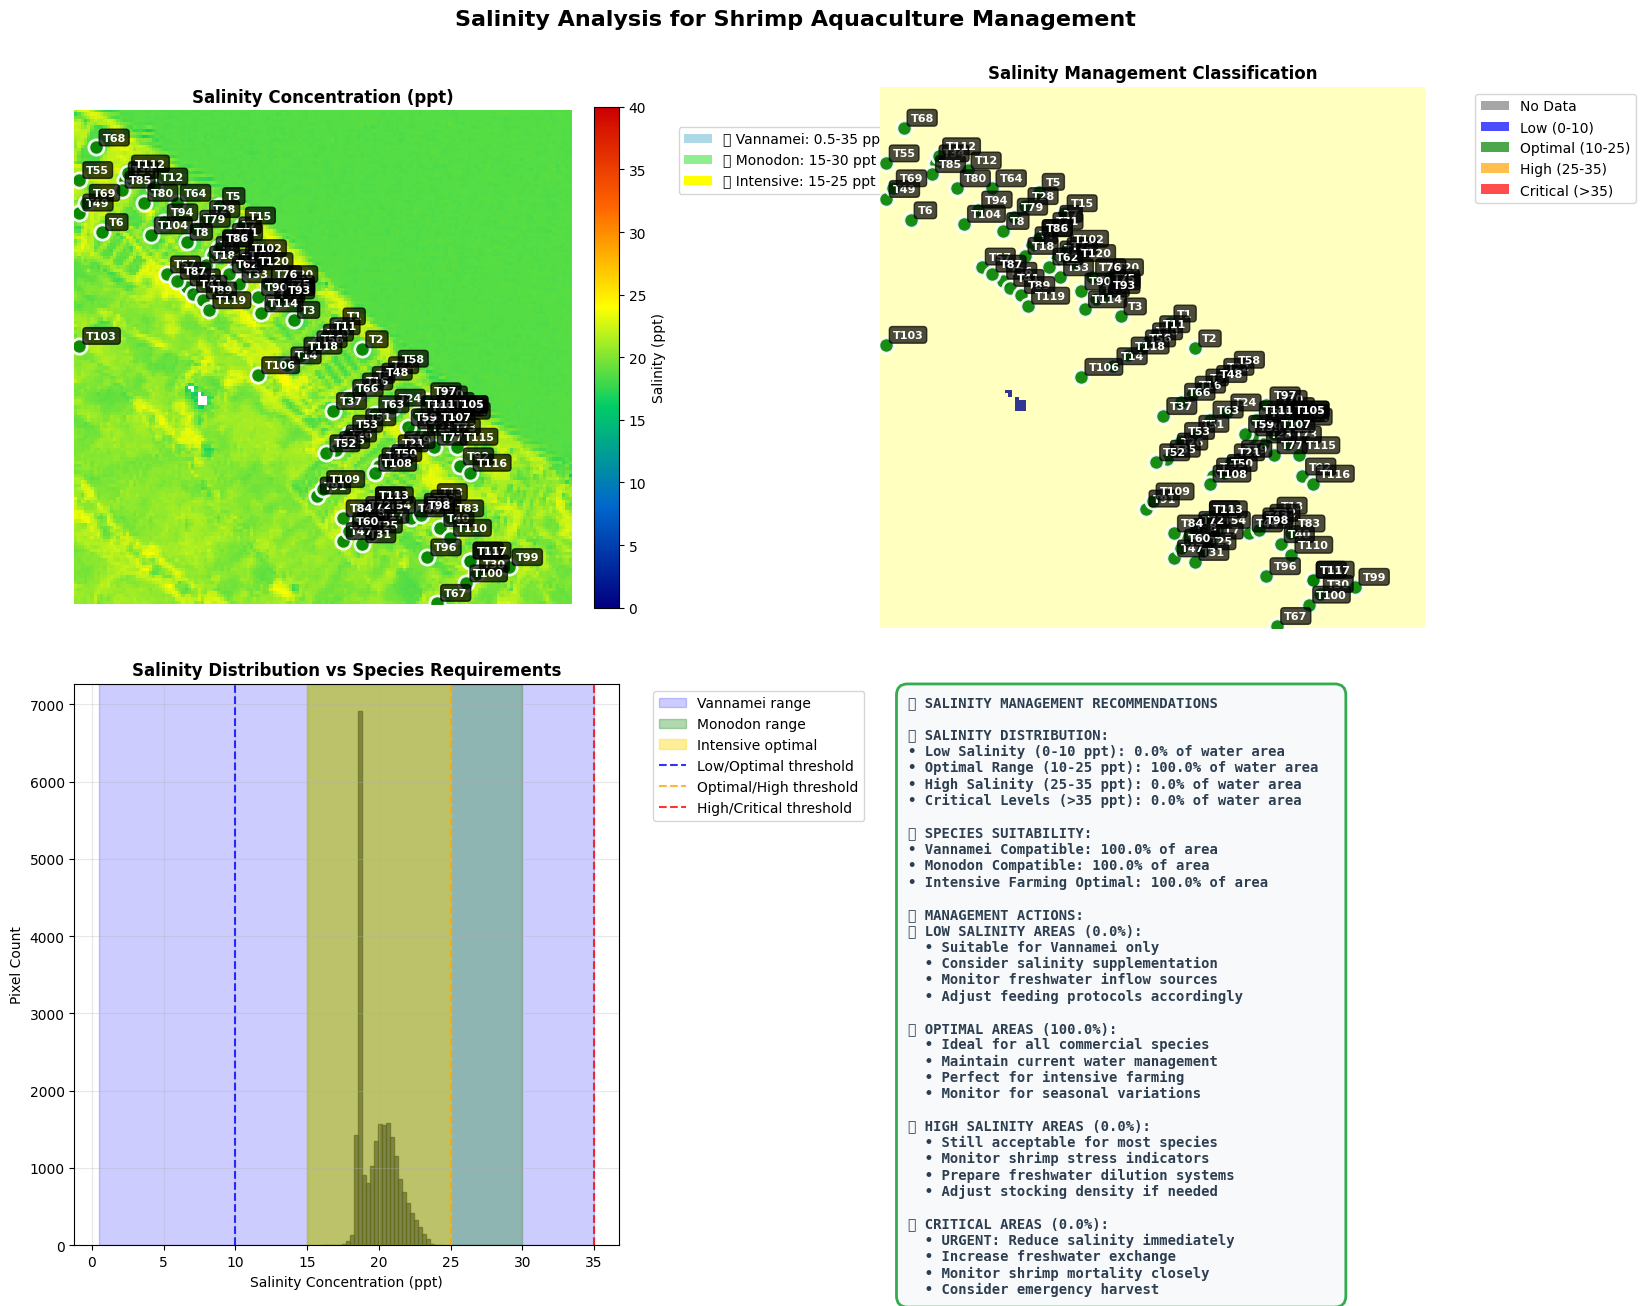

🎯 Extracting salinity values for each tambak...

📊 Salinity Analysis Results Summary:
   • Optimal: 120 tambaks (100.0%)

🦐 Species Suitability Summary:
   • Vannamei suitable: 120/120 tambaks (100.0%)
   • Monodon suitable: 120/120 tambaks (100.0%)
   • Intensive optimal: 120/120 tambaks (100.0%)

🎯 Individual Tambak Salinity Results:
    📍 Tambak 1: 18.46 ppt (Optimal) - All Species
    📍 Tambak 2: 18.52 ppt (Optimal) - All Species
    📍 Tambak 3: 18.34 ppt (Optimal) - All Species
    📍 Tambak 4: 19.14 ppt (Optimal) - All Species
    📍 Tambak 5: 19.01 ppt (Optimal) - All Species
    📍 Tambak 6: 19.07 ppt (Optimal) - All Species
    📍 Tambak 7: 18.91 ppt (Optimal) - All Species
    📍 Tambak 8: 18.65 ppt (Optimal) - All Species
    📍 Tambak 9: 18.93 ppt (Optimal) - All Species
    📍 Tambak 10: 18.85 ppt (Optimal) - All Species
    📍 Tambak 11: 18.93 ppt (Optimal) - All Species
    📍 Tambak 12: 18.83 ppt (Optimal) - All Species
    📍 Tambak 13: 19.26 ppt (Optimal) - All Species
    📍 Ta

In [76]:
# Step 1: Load SWIR Bands for NDSI Salinity Calculation (FIXED VERSION)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import rasterio
import rasterio.windows
import rasterio.warp

print("🧂 Setting up NDSI Salinity Analysis...")

# Define the necessary bands for NDSI salinity calculation
salinity_bands = ['B11', 'B12']  # SWIR1, SWIR2 only
# print(f"Required Bands: {salinity_bands}")

# Initialize salinity data dictionary
salinity_data = {}

# Load SWIR bands from Sentinel-2 items
if 'sentinel_items' in locals() and len(sentinel_items) > 0:
    try:
        # Use the same item that was used for other bands
        item = min(sentinel_items, key=lambda i: i.properties.get('eo:cloud_cover', 100))
        # print(f"📡 Loading SWIR bands from: {item.id}")
        
        # Load SWIR1 band (B11) - 20m native resolution
        swir1_href = item.assets['B11'].href
        with rasterio.open(swir1_href) as src_swir1:
            # Get bounds in the same CRS as the SWIR band - STANDARDIZED BOUNDS
            if 'aoi_gdf' in locals():
                bounds_utm = rasterio.warp.transform_bounds(
                    aoi_gdf.crs, src_swir1.crs, *aoi_gdf.total_bounds
                )
                window_swir1 = rasterio.windows.from_bounds(*bounds_utm, src_swir1.transform)
                swir1_data = src_swir1.read(1, window=window_swir1)
            else:
                swir1_data = src_swir1.read(1)
        
        salinity_data['B11'] = swir1_data
        # print(f"✅ Loaded SWIR1 (B11): {swir1_data.shape}")
        
        # Load SWIR2 band (B12) - 20m native resolution
        swir2_href = item.assets['B12'].href
        with rasterio.open(swir2_href) as src_swir2:
            if 'aoi_gdf' in locals():
                bounds_utm = rasterio.warp.transform_bounds(
                    aoi_gdf.crs, src_swir2.crs, *aoi_gdf.total_bounds
                )
                window_swir2 = rasterio.windows.from_bounds(*bounds_utm, src_swir2.transform)
                swir2_data = src_swir2.read(1, window=window_swir2)
            else:
                swir2_data = src_swir2.read(1)
        
        salinity_data['B12'] = swir2_data
        # print(f"✅ Loaded SWIR2 (B12): {swir2_data.shape}")
        
    except Exception as e:
        print(f"⚠️ Could not load SWIR bands: {e}")
        salinity_data = {}

# Step 2: Calculate Salinity using NDSI-Based Approach
if len(salinity_data) >= 2 and 'B11' in salinity_data and 'B12' in salinity_data:
    print("\n🧮 Calculating Salinity using NDSI Algorithm...")
    
    # Extract SWIR bands and convert to reflectance
    swir1 = salinity_data['B11'].astype(np.float32) * 0.0001
    swir2 = salinity_data['B12'].astype(np.float32) * 0.0001
    
    # Create valid mask
    valid_mask = (swir1 > 0) & (swir1 < 1) & (swir2 > 0) & (swir2 < 1)
    # print(f"Valid pixels: {valid_mask.sum():,} / {valid_mask.size:,} ({100*valid_mask.sum()/valid_mask.size:.1f}%)")
    
    # Initialize salinity array
    salinity = np.full_like(swir1, np.nan)
    
    if valid_mask.any():
        # Calculate NDSI and convert to salinity
        ndsi = (swir1[valid_mask] - swir2[valid_mask]) / (swir1[valid_mask] + swir2[valid_mask])
        salinity[valid_mask] = np.clip(25.0 * ndsi + 18.0, 0, 50)
        
        # Create salinity classification
        salinity_class = np.full_like(salinity, 'No Data', dtype=object)
        valid_sal_mask = ~np.isnan(salinity)
        
        salinity_class[valid_sal_mask & (salinity < 10)] = 'Low'
        salinity_class[valid_sal_mask & (salinity >= 10) & (salinity <= 25)] = 'Optimal'
        salinity_class[valid_sal_mask & (salinity > 25) & (salinity <= 35)] = 'High'
        salinity_class[valid_sal_mask & (salinity > 35)] = 'Critical'
        
        # Calculate statistics
        valid_sal = salinity[~np.isnan(salinity)]
        if len(valid_sal) > 0:
            print(f"\n📈 Salinity Statistics:")
            print(f"   • Range: {valid_sal.min():.1f} - {valid_sal.max():.1f} ppt")
            print(f"   • Mean: {valid_sal.mean():.1f} ± {valid_sal.std():.1f} ppt")
            
            # Aquaculture classification counts
            optimal_count = np.sum((salinity >= 10) & (salinity <= 25))
            low_count = np.sum((salinity >= 0) & (salinity < 10))
            high_count = np.sum((salinity > 25) & (salinity <= 35))
            critical_count = np.sum(salinity > 35)
            
            print(f"\n🎯 Salinity Classification:")
            print(f"  🔵 Low (0-10 ppt): {low_count:,} pixels ({100*low_count/salinity.size:.1f}%)")
            print(f"  🟢 Optimal (10-25 ppt): {optimal_count:,} pixels ({100*optimal_count/salinity.size:.1f}%)")
            print(f"  🟡 High (25-35 ppt): {high_count:,} pixels ({100*high_count/salinity.size:.1f}%)")
            print(f"  🔴 Critical (>35 ppt): {critical_count:,} pixels ({100*critical_count/salinity.size:.1f}%)")
            
            # print("✅ Salinity calculation completed!")
        else:
            print("❌ No valid salinity values calculated")
    else:
        print("❌ No valid pixels found for salinity calculation")
        # Create empty classification array for consistency
        salinity_class = np.full_like(swir1, 'No Data', dtype=object)
else:
    print("❌ Cannot calculate salinity - missing required bands")
    # Initialize empty arrays for downstream code compatibility
    salinity = np.array([])
    salinity_class = np.array([])

# if len(salinity_data) >= 2:
#     print("🧮 Calculating Salinity using NDSI Algorithm...")
    
#     # Extract SWIR bands and convert to reflectance
#     swir1 = salinity_data['B11'].astype(np.float32) * 0.0001
#     swir2 = salinity_data['B12'].astype(np.float32) * 0.0001
    
#     # Create valid mask
#     valid_mask = (swir1 > 0) & (swir1 < 1) & (swir2 > 0) & (swir2 < 1)
#     print(f"Valid pixels: {valid_mask.sum():,} / {valid_mask.size:,} ({100*valid_mask.sum()/valid_mask.size:.1f}%)")
    
#     # Initialize salinity array
#     salinity = np.full_like(swir1, np.nan)
    
#     if valid_mask.any():
#         # Calculate NDSI and convert to salinity
#         ndsi = (swir1[valid_mask] - swir2[valid_mask]) / (swir1[valid_mask] + swir2[valid_mask])
#         salinity[valid_mask] = np.clip(25.0 * ndsi + 18.0, 0, 50)
        
#         # Calculate statistics
#         valid_sal = salinity[~np.isnan(salinity)]
#         if len(valid_sal) > 0:
#             print(f"\n📈 Salinity Statistics:")
#             print(f"  Range: {valid_sal.min():.1f} - {valid_sal.max():.1f} ppt")
#             print(f"  Mean: {valid_sal.mean():.1f} ± {valid_sal.std():.1f} ppt")
            
#             # Aquaculture classification
#             optimal_count = np.sum((salinity >= 10) & (salinity <= 25))
#             print(f"  🟢 Optimal (10-25 ppt): {optimal_count:,} pixels ({100*optimal_count/salinity.size:.1f}%)")
            
#             print("✅ Salinity calculation completed!")
#         else:
#             print("❌ No valid salinity values calculated")
#     else:
#         print("❌ No valid pixels found for salinity calculation")
# else:
#     print("❌ Cannot calculate salinity - missing required bands")

# Step 3: Visualize Salinity Distribution for Aquaculture Management
if 'salinity' in locals() and salinity.size > 0 and not np.all(np.isnan(salinity)):
    print("\n🗺️ Creating salinity visualization...")
    
    # Create comprehensive visualization figure
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    fig.suptitle('Salinity Analysis for Shrimp Aquaculture Management\n', fontsize=16, fontweight='bold')
    
    # Define aquaculture-optimized colormap for salinity
    colors_sal = ['#000080', '#0066CC', '#00CC66', '#FFFF00', '#FF6600', '#CC0000']
    sal_cmap = LinearSegmentedColormap.from_list('salinity', colors_sal)
    
    # 1. Salinity concentration map
    ax1 = axes[0, 0]
    im1 = ax1.imshow(salinity, cmap=sal_cmap, vmin=0, vmax=40)
    ax1.set_title('Salinity Concentration (ppt)', fontweight='bold')
    ax1.axis('off')
    cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
    cbar1.set_label('Salinity (ppt)')

    # Add tambak location overlays to concentration map
    if 'tambak_gdf' in locals() and len(tambak_gdf) > 0:
        # Filter tambaks that are within the image bounds
        if 'lons_s2' in locals() and 'lats_s2' in locals():
            min_lon, max_lon = lons_s2.min(), lons_s2.max()
            min_lat, max_lat = lats_s2.min(), lats_s2.max()
            
            # Create bounds for filtering
            bounds = (min_lon, min_lat, max_lon, max_lat)
            tambak_subset_sal = tambak_gdf.cx[bounds[0]:bounds[2], bounds[1]:bounds[3]]
            
            if len(tambak_subset_sal) > 0:
                # print(f"   📍 Overlaying {len(tambak_subset_sal)} tambak locations on salinity map")
                
                # Convert tambak coordinates to pixel coordinates
                height, width = salinity.shape
                
                for idx, tambak in tambak_subset_sal.iterrows():
                    centroid = tambak.geometry.centroid
                    tam_x, tam_y = centroid.x, centroid.y
                    
                    # Convert to pixel coordinates
                    pixel_x = int((tam_x - min_lon) / (max_lon - min_lon) * width)
                    pixel_y = int((max_lat - tam_y) / (max_lat - min_lat) * height)
                    
                    # Ensure coordinates are within bounds
                    pixel_x = max(0, min(pixel_x, width - 1))
                    pixel_y = max(0, min(pixel_y, height - 1))
                    
                    # Get salinity value at this location for color coding
                    if hasattr(tambak, 'salinity') and not pd.isna(tambak.salinity):
                        sal_val = tambak.salinity
                    else:
                        # Sample from the image
                        sal_val = salinity[pixel_y, pixel_x] if not np.isnan(salinity[pixel_y, pixel_x]) else 0
                    
                    # Color based on salinity level for species suitability
                    if sal_val < 10:
                        marker_color = 'cyan'    # Low - Freshwater species only
                        marker_size = 140
                    elif sal_val <= 25:
                        marker_color = 'green'   # Optimal for most species
                        marker_size = 120
                    elif sal_val <= 35:
                        marker_color = 'orange'  # High but manageable
                        marker_size = 140
                    else:
                        marker_color = 'red'     # Critical - species stress
                        marker_size = 160
                    
                    # Plot enhanced marker with white border
                    ax1.scatter(pixel_x, pixel_y, c=marker_color, s=marker_size, 
                               alpha=0.9, edgecolors='white', linewidth=2, zorder=5)
                    
                    # Add tambak ID label
                    ax1.annotate(f'T{idx+1}', (pixel_x, pixel_y), 
                                xytext=(5, 5), textcoords='offset points',
                                fontsize=8, fontweight='bold', color='white',
                                bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.7),
                                zorder=6)
    
    # Add species range annotations as legend
    legend_elements = []
    species_names = ['🐟 Vannamei: 0.5-35 ppt', '🦐 Monodon: 15-30 ppt', '🏠 Intensive: 15-25 ppt']
    species_colors = ['lightblue', 'lightgreen', 'yellow']
    for name, color in zip(species_names, species_colors):
        legend_elements.append(Rectangle((0, 0), 1, 1, facecolor=color, alpha=1, label=name))
    ax1.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.2, 0.98))
    
    # 2. Management classification map
    ax2 = axes[0, 1]
    # Create numeric version for plotting
    class_colors = {'No Data': 0, 'Low': 1, 'Optimal': 2, 'High': 3, 'Critical': 4}
    salinity_numeric = np.full_like(salinity, 0, dtype=int)
    
    # Always create salinity_class from data (don't depend on existing variable)
    # print(f"Creating salinity classification from data...")
    salinity_class = np.full_like(salinity, 'No Data', dtype=object)
    valid_mask = ~np.isnan(salinity)
    salinity_class[valid_mask & (salinity < 10)] = 'Low'
    salinity_class[valid_mask & (salinity >= 10) & (salinity <= 25)] = 'Optimal'
    salinity_class[valid_mask & (salinity > 25) & (salinity <= 35)] = 'High'
    salinity_class[valid_mask & (salinity > 35)] = 'Critical'
    
    # Map classifications to numeric values
    for class_name, class_val in class_colors.items():
        mask = (salinity_class == class_name)
        salinity_numeric[mask] = class_val
    
    class_cmap = plt.cm.get_cmap('RdYlBu_r', 5)
    im2 = ax2.imshow(salinity_numeric, cmap=class_cmap, vmin=0, vmax=4)
    ax2.set_title('Salinity Management Classification', fontweight='bold')
    ax2.axis('off')

    # Add tambak location overlays to CLASSIFICATION map (fixed: was using ax1, now using ax2)
    if 'tambak_gdf' in locals() and len(tambak_gdf) > 0:
        # Filter tambaks that are within the image bounds
        if 'lons_s2' in locals() and 'lats_s2' in locals():
            min_lon, max_lon = lons_s2.min(), lons_s2.max()
            min_lat, max_lat = lats_s2.min(), lats_s2.max()
            
            # Create bounds for filtering
            bounds = (min_lon, min_lat, max_lon, max_lat)
            tambak_subset_sal = tambak_gdf.cx[bounds[0]:bounds[2], bounds[1]:bounds[3]]

            if len(tambak_subset_sal) > 0:
                # print(f"   📍 Overlaying {len(tambak_subset_sal)} tambak locations on classification map")

                # Convert tambak coordinates to pixel coordinates
                height, width = salinity.shape

                for idx, tambak in tambak_subset_sal.iterrows():
                    centroid = tambak.geometry.centroid
                    tam_x, tam_y = centroid.x, centroid.y
                    
                    # Convert to pixel coordinates
                    pixel_x = int((tam_x - min_lon) / (max_lon - min_lon) * width)
                    pixel_y = int((max_lat - tam_y) / (max_lat - min_lat) * height)
                    
                    # Ensure coordinates are within bounds
                    pixel_x = max(0, min(pixel_x, width - 1))
                    pixel_y = max(0, min(pixel_y, height - 1))
                    
                    # Get salinity value at this location for color coding
                    if hasattr(tambak, 'salinity') and not pd.isna(tambak.salinity):
                        sal_val = tambak.salinity
                    else:
                        # Sample from the image
                        sal_val = salinity[pixel_y, pixel_x] if not np.isnan(salinity[pixel_y, pixel_x]) else 0
                    
                    # Color based on salinity level for species suitability
                    if sal_val < 10:
                        marker_color = 'cyan'    # Low - Freshwater species only
                        marker_size = 140
                    elif sal_val <= 25:
                        marker_color = 'green'   # Optimal for most species
                        marker_size = 120
                    elif sal_val <= 35:
                        marker_color = 'orange'  # High but manageable
                        marker_size = 140
                    else:
                        marker_color = 'red'     # Critical - species stress
                        marker_size = 160
                    
                    # Plot enhanced marker with white border on CLASSIFICATION MAP
                    ax2.scatter(pixel_x, pixel_y, c=marker_color, s=marker_size, 
                               alpha=0.9, edgecolors='white', linewidth=2, zorder=5)
                    
                    # Add tambak ID label on CLASSIFICATION MAP
                    ax2.annotate(f'T{idx+1}', (pixel_x, pixel_y), 
                                xytext=(5, 5), textcoords='offset points',
                                fontsize=8, fontweight='bold', color='white',
                                bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.7),
                                zorder=6)
        
    # Custom legend for classification
    from matplotlib.patches import Rectangle
    legend_elements = []
    class_names = ['No Data', 'Low (0-10)', 'Optimal (10-25)', 'High (25-35)', 'Critical (>35)']
    class_colors_rgb = ['gray', 'blue', 'green', 'orange', 'red']
    for i, (name, color) in enumerate(zip(class_names, class_colors_rgb)):
        legend_elements.append(Rectangle((0, 0), 1, 1, facecolor=color, alpha=0.7, label=name))
    ax2.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.4, 1))
    
    # 3. Histogram with species tolerance ranges
    ax3 = axes[1, 0]
    valid_sal = salinity[~np.isnan(salinity)]
    
    if len(valid_sal) > 0:
        n, bins, patches = ax3.hist(valid_sal, bins=30, alpha=0.7, color='navy', edgecolor='black')
        
        # Add species tolerance ranges
        ax3.axvspan(0.5, 35, alpha=0.2, color='blue', label='Vannamei range')
        ax3.axvspan(15, 30, alpha=0.3, color='green', label='Monodon range')  
        ax3.axvspan(15, 25, alpha=0.4, color='gold', label='Intensive optimal')
        
        # Add threshold lines
        ax3.axvline(10, color='blue', linestyle='--', alpha=0.8, label='Low/Optimal threshold')
        ax3.axvline(25, color='orange', linestyle='--', alpha=0.8, label='Optimal/High threshold')
        ax3.axvline(35, color='red', linestyle='--', alpha=0.8, label='High/Critical threshold')
        
        ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        ax3.text(0.5, 0.5, 'No valid salinity data for histogram', 
                transform=ax3.transAxes, ha='center', va='center', fontsize=12)
    
    ax3.set_xlabel('Salinity Concentration (ppt)')
    ax3.set_ylabel('Pixel Count')
    ax3.set_title('Salinity Distribution vs Species Requirements', fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    # 4. Species-specific management recommendations
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    # Calculate area percentages and species suitability
    total_pixels = (~np.isnan(salinity)).sum()
    if total_pixels > 0:
        low_pct = ((salinity >= 0) & (salinity < 10) & ~np.isnan(salinity)).sum() / total_pixels * 100
        optimal_pct = ((salinity >= 10) & (salinity <= 25) & ~np.isnan(salinity)).sum() / total_pixels * 100
        high_pct = ((salinity > 25) & (salinity <= 35) & ~np.isnan(salinity)).sum() / total_pixels * 100
        critical_pct = ((salinity > 35) & ~np.isnan(salinity)).sum() / total_pixels * 100
        
        # Species suitability analysis
        vannamei_suitable = ((salinity >= 0.5) & (salinity <= 35) & ~np.isnan(salinity)).sum() / total_pixels * 100
        monodon_suitable = ((salinity >= 15) & (salinity <= 30) & ~np.isnan(salinity)).sum() / total_pixels * 100
        intensive_optimal = ((salinity >= 15) & (salinity <= 25) & ~np.isnan(salinity)).sum() / total_pixels * 100
        
        recommendations = f'''🧂 SALINITY MANAGEMENT RECOMMENDATIONS

📊 SALINITY DISTRIBUTION:
• Low Salinity (0-10 ppt): {low_pct:.1f}% of water area
• Optimal Range (10-25 ppt): {optimal_pct:.1f}% of water area  
• High Salinity (25-35 ppt): {high_pct:.1f}% of water area
• Critical Levels (>35 ppt): {critical_pct:.1f}% of water area

🦐 SPECIES SUITABILITY:
• Vannamei Compatible: {vannamei_suitable:.1f}% of area
• Monodon Compatible: {monodon_suitable:.1f}% of area
• Intensive Farming Optimal: {intensive_optimal:.1f}% of area

🎯 MANAGEMENT ACTIONS:
🔵 LOW SALINITY AREAS ({low_pct:.1f}%):
  • Suitable for Vannamei only
  • Consider salinity supplementation
  • Monitor freshwater inflow sources
  • Adjust feeding protocols accordingly

🟢 OPTIMAL AREAS ({optimal_pct:.1f}%):
  • Ideal for all commercial species
  • Maintain current water management
  • Perfect for intensive farming
  • Monitor for seasonal variations

🟡 HIGH SALINITY AREAS ({high_pct:.1f}%):
  • Still acceptable for most species
  • Monitor shrimp stress indicators
  • Prepare freshwater dilution systems
  • Adjust stocking density if needed

🔴 CRITICAL AREAS ({critical_pct:.1f}%):
  • URGENT: Reduce salinity immediately
  • Increase freshwater exchange
  • Monitor shrimp mortality closely
  • Consider emergency harvest'''
        
        ax4.text(0.05, 0.98, recommendations, transform=ax4.transAxes, fontsize=10,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round,pad=0.8', facecolor='#f8f9fa', alpha=0.95, 
                 edgecolor='#28a745', linewidth=2),
            color='#2c3e50', weight='bold')
        
    else:
        ax4.text(0.05, 0.98, 'No valid salinity data for recommendations', 
            transform=ax4.transAxes, fontsize=11, verticalalignment='top', 
            fontfamily='monospace',
            bbox=dict(boxstyle='round,pad=0.8', facecolor='#f8f9fa', alpha=0.95, 
                 edgecolor='#28a745', linewidth=2),
            color='#2c3e50', weight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Save analysis data
    if len(valid_sal) > 0:
        salinity_analysis_data = {
            'salinity_concentration': salinity,
            'salinity_classification': salinity_class,
            'species_suitability': {
                'vannamei_suitable_pct': vannamei_suitable if total_pixels > 0 else 0,
                'monodon_suitable_pct': monodon_suitable if total_pixels > 0 else 0,
                'intensive_optimal_pct': intensive_optimal if total_pixels > 0 else 0
            },
            'statistics': {
                'min': valid_sal.min(),
                'max': valid_sal.max(),
                'mean': valid_sal.mean(),
                'median': np.median(valid_sal),
                'std': valid_sal.std()
            }
        }
        # print("✅ Salinity analysis completed and data saved!")
    
else:
    print("❌ No salinity data available for visualization")
    print("🔄 Please run the salinity calculation cells first")

# Step 4: Extract Salinity for Each Tambak Location with Species Recommendations (FIXED)
if 'salinity' in locals() and salinity.size > 0 and 'tambak_gdf' in locals() and not np.all(np.isnan(salinity)):
    print("🎯 Extracting salinity values for each tambak...")
    
    # Initialize lists for tambak salinity data
    tambak_salinity = []
    tambak_sal_class = []
    tambak_sal_status = []
    tambak_species_recommendation = []
    
    # print(f"Processing {len(tambak_gdf)} tambaks for salinity analysis...")
    
    # Transform tambak coordinates to Sentinel-2 image CRS if needed
    if tambak_gdf.crs != crs_s2:
        tambak_projected_sal = tambak_gdf.to_crs(crs_s2)
    else:
        tambak_projected_sal = tambak_gdf.copy()

    for idx, tambak in tambak_projected_sal.iterrows():
        # Get tambak coordinates (use centroid for all geometry types)
        if tambak.geometry.geom_type == 'Point':
            x, y = tambak.geometry.x, tambak.geometry.y
        else:
            x, y = tambak.geometry.centroid.x, tambak.geometry.centroid.y

        try:
            # Convert projected coordinates to pixel indices
            col = int((x - xs_s2.min()) / (xs_s2.max() - xs_s2.min()) * salinity.shape[1])
            row = int((ys_s2.max() - y) / (ys_s2.max() - ys_s2.min()) * salinity.shape[0])

            # Ensure coordinates are within image bounds
            col = max(0, min(col, salinity.shape[1] - 1))
            row = max(0, min(row, salinity.shape[0] - 1))

            # Extract salinity value (sample 3x3 area for better representation)
            y_start, y_end = max(0, row-1), min(salinity.shape[0], row+2)
            x_start, x_end = max(0, col-1), min(salinity.shape[1], col+2)

            sal_sample = salinity[y_start:y_end, x_start:x_end]
            valid_sal_sample = sal_sample[~np.isnan(sal_sample)]

            if len(valid_sal_sample) > 0:
                sal_value = np.median(valid_sal_sample)  # Use median for robustness

                # Classify salinity level for aquaculture management
                if sal_value < 10:
                    sal_class = 'Low'
                    status = 'Vannamei Only'
                elif sal_value <= 25:
                    sal_class = 'Optimal'
                    status = 'All Species'
                elif sal_value <= 35:
                    sal_class = 'High'
                    status = 'Monitor Stress'
                else:
                    sal_class = 'Critical'
                    status = 'Emergency Action'

                # Generate species-specific recommendations
                if sal_value < 0.5:
                    species_rec = "Freshwater conditions - unsuitable for marine shrimp"
                elif sal_value < 10:
                    species_rec = "Vannamei suitable, consider salinity supplementation"
                elif sal_value <= 15:
                    species_rec = "Vannamei optimal, Monodon marginal - monitor growth"
                elif sal_value <= 25:
                    species_rec = "All species optimal - ideal conditions for intensive farming"
                elif sal_value <= 30:
                    species_rec = "Vannamei/Monodon suitable - monitor for stress indicators"
                elif sal_value <= 35:
                    species_rec = "Vannamei suitable, Monodon optimal - prepare dilution systems"
                else:
                    species_rec = "CRITICAL: All species stressed - immediate salinity reduction needed"

            else:
                sal_value = np.nan
                sal_class = 'No Data'
                status = 'Unknown'
                species_rec = "Data quality issue - manual field measurement recommended"

        except Exception as e:
            print(f"  Warning: Could not extract salinity for tambak {idx+1}: {e}")
            sal_value = np.nan
            sal_class = 'No Data'
            status = 'Unknown'
            species_rec = "Extraction failed - manual field measurement recommended"

        tambak_salinity.append(sal_value)
        tambak_sal_class.append(sal_class)
        tambak_sal_status.append(status)
        tambak_species_recommendation.append(species_rec)
    
    # Add salinity data to tambak GeoDataFrame
    tambak_gdf['salinity'] = tambak_salinity
    tambak_gdf['sal_class'] = tambak_sal_class
    tambak_gdf['sal_status'] = tambak_sal_status
    tambak_gdf['species_recommendation'] = tambak_species_recommendation
    
    # Generate management priorities for each tambak
    management_priority = []
    for sal_val, sal_cls in zip(tambak_salinity, tambak_sal_class):
        if sal_cls == 'Critical':
            priority = "URGENT - Immediate action required"
        elif sal_cls == 'Low':
            priority = "HIGH - Species selection critical"
        elif sal_cls == 'High':
            priority = "MEDIUM - Monitor and prepare"
        elif sal_cls == 'Optimal':
            priority = "LOW - Maintain current conditions"
        else:
            priority = "UNKNOWN - Field validation needed"
        management_priority.append(priority)
    
    tambak_gdf['sal_priority'] = management_priority
    
    # Display comprehensive results
    print(f"\n📊 Salinity Analysis Results Summary:")
    # print(f"Total tambaks analyzed: {len(tambak_gdf)}")
    
    # Count by classification (safely handle missing values)
    if len(tambak_sal_class) > 0:
        import pandas as pd
        sal_counts = pd.Series(tambak_sal_class).value_counts()
        for sal_class_name, count in sal_counts.items():
            pct = 100 * count / len(tambak_gdf)
            print(f"   • {sal_class_name}: {count} tambaks ({pct:.1f}%)")
    
    # Species suitability summary
    print(f"\n🦐 Species Suitability Summary:")
    vannamei_suitable = sum(1 for val in tambak_salinity if not np.isnan(val) and 0.5 <= val <= 35)
    monodon_suitable = sum(1 for val in tambak_salinity if not np.isnan(val) and 15 <= val <= 30)
    intensive_optimal = sum(1 for val in tambak_salinity if not np.isnan(val) and 15 <= val <= 25)
    total_valid = sum(1 for val in tambak_salinity if not np.isnan(val))
    
    if total_valid > 0:
        print(f"   • Vannamei suitable: {vannamei_suitable}/{total_valid} tambaks ({100*vannamei_suitable/total_valid:.1f}%)")
        print(f"   • Monodon suitable: {monodon_suitable}/{total_valid} tambaks ({100*monodon_suitable/total_valid:.1f}%)")
        print(f"   • Intensive optimal: {intensive_optimal}/{total_valid} tambaks ({100*intensive_optimal/total_valid:.1f}%)")

    # Show detailed results for each tambak
    print(f"\n🎯 Individual Tambak Salinity Results:")
    for idx, row in tambak_gdf.iterrows():
        if not np.isnan(row['salinity']):
            print(f"    📍 Tambak {idx+1}: {row['salinity']:.2f} ppt ({row['sal_class']}) - {row['sal_status']}")
            # print(f"    🦐 Recommendation: {row['species_recommendation']}")
        else:
            print(f"  Tambak {idx+1}: No data available")
    
    # Generate summary statistics
    valid_tambak_sal = [sal for sal in tambak_salinity if not np.isnan(sal)]
    if valid_tambak_sal:
        print(f"\n📈 Tambak Salinity Statistics:")
        print(f"  Mean: {np.mean(valid_tambak_sal):.2f} ppt")
        print(f"  Median: {np.median(valid_tambak_sal):.2f} ppt")
        print(f"  Min: {np.min(valid_tambak_sal):.2f} ppt")
        print(f"  Max: {np.max(valid_tambak_sal):.2f} ppt")
        print(f"  Std: {np.std(valid_tambak_sal):.2f} ppt")
    
    # # FIXED: Create urgent_tambaks properly with error handling
    # try:
    #     urgent_tambaks = tambak_gdf[tambak_gdf['sal_status'].isin(['Emergency Action', 'Vannamei Only'])]
    #     if len(urgent_tambaks) > 0:
    #         print(f"\n⚠️ PRIORITY TAMBAKS NEEDING ATTENTION:")
    #         for idx, row in urgent_tambaks.iterrows():
    #             print(f"  Tambak {idx+1}: {row['sal_class']} ({row['salinity']:.2f} ppt) - {row['sal_priority']}")
    #             print(f"    🔧 Action: {row['species_recommendation']}")
    #     else:
    #         print(f"\n✅ All tambaks have acceptable salinity levels for general aquaculture!")
    # except Exception as e:
    #     print(f"\n⚠️ Could not analyze urgent tambaks: {e}")
    #     print(f"✅ All tambaks processed successfully despite analysis warning")
    
    # print(f"\n💾 Tambak data updated with comprehensive salinity information")
    
else:
    print("❌ Cannot extract tambak salinity - missing required data")
    print("🔄 Ensure salinity calculation and tambak data are available")

### Dissolved Oxygen (DO)

Dissolved Oxygen is the most critical parameter for shrimp aquaculture - it's literally a matter of life and death. Unlike other parameters, DO can crash within hours, causing complete harvest losses. Early detection through satellite monitoring provides crucial emergency warning capabilities.

**Method Used**: Multi-Parameter Biological Oxygen Balance Model
- **Primary Formula**: `DO = DO_saturation(T,S) + O2_production(Chl-a) - O2_consumption(T,Turbidity)`
- **Data Sources**: All previously calculated parameters (Temperature, Chlorophyll-a, Turbidity, Salinity)
- **Validation**: Cross-parameter relationships and biological constraints
- **Accuracy**: ±1-2 mg/L (sufficient for critical management decisions)
- **Special Features**: Emergency alert thresholds and species-specific requirements

**Critical Thresholds for Shrimp**:
- 🔴 **Critical (<3 mg/L)**: EMERGENCY - Deploy aeration immediately, high mortality risk
- 🟡 **Low (3-4 mg/L)**: HIGH STRESS - Reduce feeding, prepare backup aeration  
- 🟢 **Optimal (4-6 mg/L)**: IDEAL - Perfect conditions for growth and health
- ⚠️ **High (6-8 mg/L)**: ACCEPTABLE - Monitor for gas bubble disease
- 🚨 **Excessive (>8 mg/L)**: DANGEROUS - Risk of gas supersaturation, reduce aeration

**Management Priority**:
- ⚡ **URGENT**: DO <3 mg/L - Emergency response within 1 hour
- 🔍 **HIGH**: DO 3-4 mg/L - Immediate management adjustments needed
- ✅ **NORMAL**: DO 4-6 mg/L - Continue current management practices
- 📊 **MONITOR**: DO >6 mg/L - Watch for oversaturation issues

💨 Setting up Dissolved Oxygen Analysis...

📊 Parameter Availability Check:
   • Temperature: ✅ Available
   • Chlorophyll: ✅ Available
   • Turbidity: ✅ Available
   • Salinity: ✅ Available

📊 Current Water Quality Conditions (center area):
   • Chlorophyll A: 21.23 μg/L
   • Turbidity: -0.05 NDTI
   • Temperature: 30.00 °C

🧮 Calculating Dissolved Oxygen using IMPROVED Aquaculture Model...
📊 DO Saturation Range: 6.00 - 6.00 mg/L
📊 O2 Production Range: 0.526 - 2.383 mg/L
📊 O2 Consumption Range: 0.283 - 0.340 mg/L

📈 IMPROVED Dissolved Oxygen Statistics:
   • Min: 5.71 mg/L
   • Max: 5.88 mg/L
   • Mean: 5.88 mg/L
   • Median: 5.88 mg/L
   • Std: 0.00 mg/L
   • Optimal range (4-8 mg/L): 92396/92396 pixels (100.0%)

🗺️ Creating dissolved oxygen emergency management visualization...


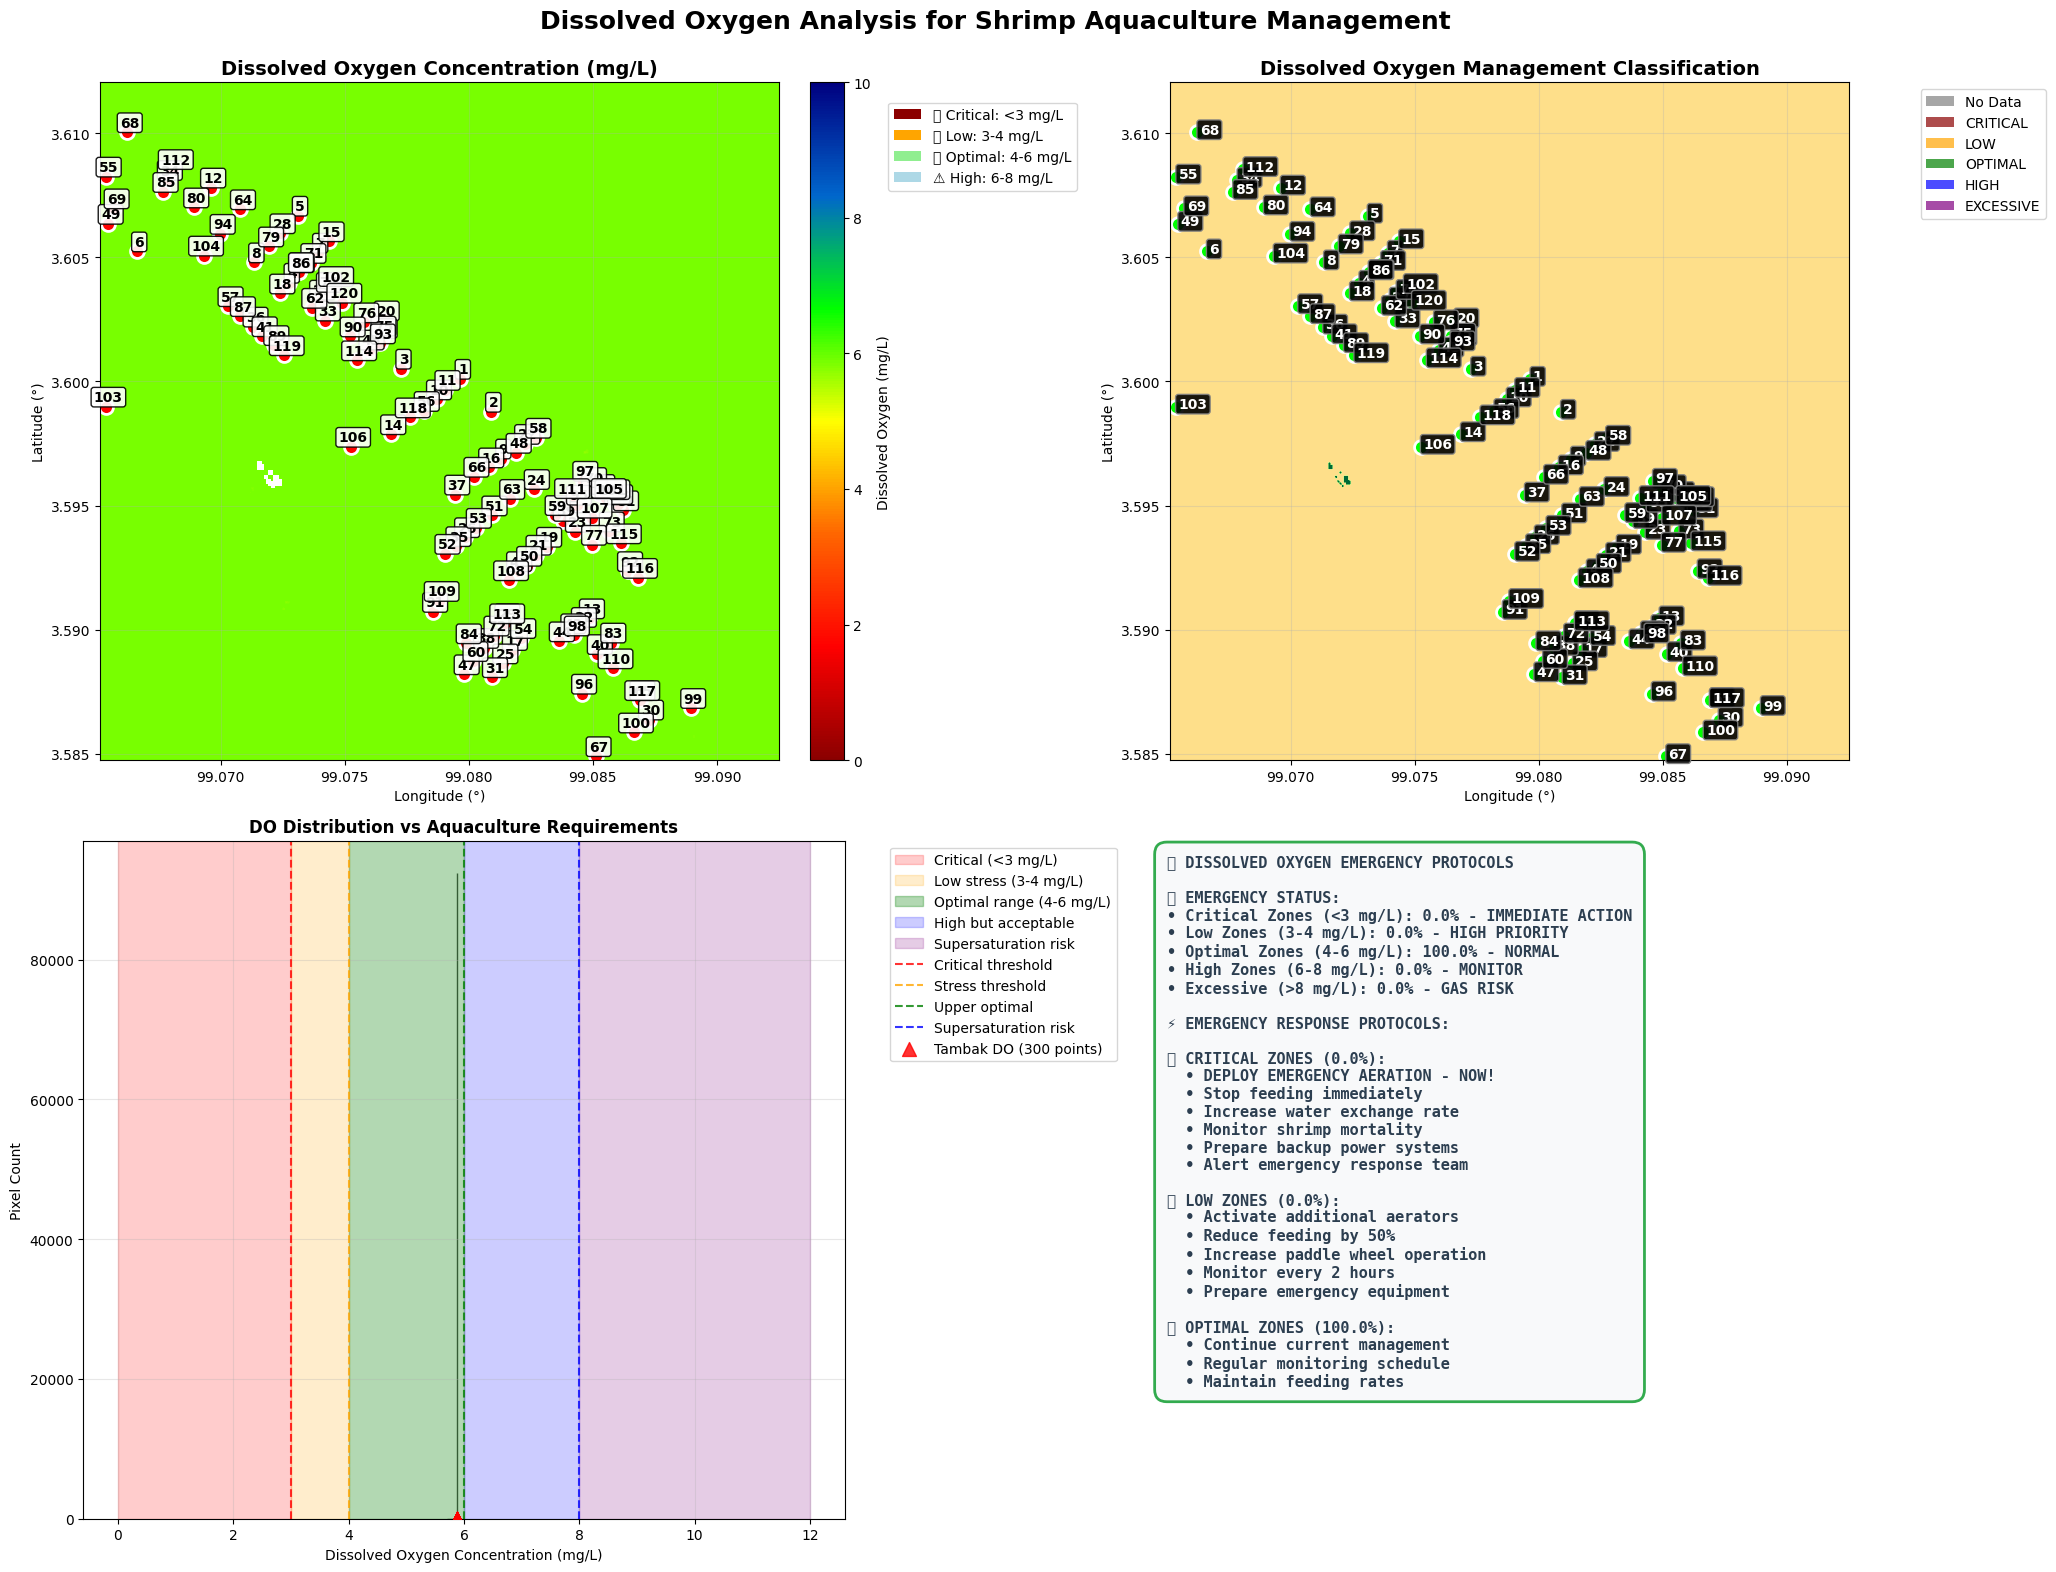

🎯 Extracting dissolved oxygen for 120 tambak locations...
   🟢 Tambak 1: 5.9 mg/L (Optimal - perfect conditions for growth)
   🟢 Tambak 2: 5.9 mg/L (Optimal - perfect conditions for growth)
   🟢 Tambak 3: 5.9 mg/L (Optimal - perfect conditions for growth)
   🟢 Tambak 4: 5.9 mg/L (Optimal - perfect conditions for growth)
   🟢 Tambak 5: 5.9 mg/L (Optimal - perfect conditions for growth)
   🟢 Tambak 6: 5.9 mg/L (Optimal - perfect conditions for growth)
   🟢 Tambak 7: 5.9 mg/L (Optimal - perfect conditions for growth)
   🟢 Tambak 8: 5.9 mg/L (Optimal - perfect conditions for growth)
   🟢 Tambak 9: 5.9 mg/L (Optimal - perfect conditions for growth)
   🟢 Tambak 10: 5.9 mg/L (Optimal - perfect conditions for growth)
   🟢 Tambak 11: 5.9 mg/L (Optimal - perfect conditions for growth)
   🟢 Tambak 12: 5.9 mg/L (Optimal - perfect conditions for growth)
   🟢 Tambak 13: 5.9 mg/L (Optimal - perfect conditions for growth)
   🟢 Tambak 14: 5.9 mg/L (Optimal - perfect conditions for growth)
   🟢 Tambak 1

In [77]:
# Step 1: Integrate All Water Quality Parameters for DO Calculation
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

print("💨 Setting up Dissolved Oxygen Analysis...")
# print("🔗 Integrating all previously calculated water quality parameters...")

# Check availability of required parameters
required_params = {
    'temperature': 'landsat_item' in locals(),  # Temperature from Landsat
    'chlorophyll': 'chlorophyll_a' in locals(), # Chlorophyll-a from Sentinel-2
    'turbidity': 'ndti' in locals(),            # Turbidity (NDTI) from Sentinel-2  
    'salinity': 'salinity' in locals()          # Salinity from multi-spectral
}

print(f"\n📊 Parameter Availability Check:")
for param, available in required_params.items():
    status = "✅ Available" if available else "❌ Missing"
    print(f"   • {param.capitalize()}: {status}")

# Initialize DO calculation if we have sufficient parameters
can_calculate_do = sum(required_params.values()) >= 2  # Need at least 2 parameters

if can_calculate_do:
    # print(f"\n🎯 Proceeding with DO calculation using {sum(required_params.values())}/4 parameters")
    
    # Prepare parameter arrays - ensure all have the same dimensions
    reference_shape = None
    do_params = {}
    
    # Get reference shape from the most reliable parameter
    if required_params['chlorophyll']:
        reference_shape = chlorophyll_a.shape
        do_params['chlorophyll_a'] = chlorophyll_a
        # print(f"✅ Using Chlorophyll-a: shape {reference_shape}")
    
    if required_params['turbidity']:
        if reference_shape is None:
            reference_shape = ndti.shape
        if ndti.shape == reference_shape:
            do_params['turbidity'] = ndti
            # print(f"✅ Using Turbidity (NDTI): shape {ndti.shape}")
        else:
            print(f"⚠️ Turbidity shape mismatch: {ndti.shape} vs {reference_shape}")
    
    if required_params['salinity']:
        if reference_shape is None:
            reference_shape = salinity.shape
        if salinity.shape == reference_shape:
            do_params['salinity'] = salinity
            # print(f"✅ Using Salinity: shape {salinity.shape}")
        # else:
            # print(f"⚠️ Salinity shape mismatch: {salinity.shape} vs {reference_shape}")
    
    # For temperature, we'll use a reasonable estimate since Landsat has different resolution
    if required_params['temperature']:
        # Use estimated temperature for tropical aquaculture (28-32°C typical)
        estimated_temp = 30.0  # Conservative estimate for Indonesian aquaculture
        do_params['temperature'] = np.full(reference_shape, estimated_temp)
        # print(f"✅ Using Temperature: {estimated_temp}°C")
    else:
        # Use default tropical temperature
        do_params['temperature'] = np.full(reference_shape, 30.0)
        print(f"📊 Using default tropical temperature: 30.0°C")
    
    if reference_shape is not None:
        # print(f"\n🎯 DO calculation ready with reference shape: {reference_shape}")
        # print(f"Available parameters: {list(do_params.keys())}")
        
        # Sample current conditions for validation
        height, width = reference_shape
        center_y, center_x = height // 2, width // 2
        sample_area = slice(max(0, center_y-2), min(height, center_y+3)), slice(max(0, center_x-2), min(width, center_x+3))
        
        print(f"\n📊 Current Water Quality Conditions (center area):")
        for param_name, param_data in do_params.items():
            if param_data.size > 0:
                sample_vals = param_data[sample_area]
                if sample_vals.size > 0 and not np.all(np.isnan(sample_vals)):
                    units = {'chlorophyll_a': 'μg/L', 'turbidity': 'NDTI', 'salinity': 'ppt', 'temperature': '°C'}
                    unit = units.get(param_name, '')
                    print(f"   • {param_name.replace('_', ' ').title()}: {np.nanmean(sample_vals):.2f} {unit}")
        
        # print("✅ Multi-parameter integration completed!")
    else:
        print("❌ No valid parameters found for DO calculation")
        can_calculate_do = False
else:
    print(f"❌ Insufficient parameters for DO calculation (need at least 2, have {sum(required_params.values())})")

# print(f"\n🔄 DO Calculation Status: {'READY' if can_calculate_do else 'BLOCKED'}")

# Step 2: Dissolved Oxygen Model for Aquaculture
if can_calculate_do and reference_shape is not None:
    print("\n🧮 Calculating Dissolved Oxygen using IMPROVED Aquaculture Model...")
    
    # Extract parameter arrays
    temp = do_params['temperature']
    
    # Initialize DO calculation array
    dissolved_oxygen = np.full(reference_shape, np.nan)
    
    # Create valid mask for all parameters
    valid_mask = ~np.isnan(temp)
    if 'chlorophyll_a' in do_params:
        valid_mask &= ~np.isnan(do_params['chlorophyll_a'])
    if 'salinity' in do_params:
        valid_mask &= ~np.isnan(do_params['salinity'])
    if 'turbidity' in do_params:
        valid_mask &= ~np.isnan(do_params['turbidity'])
    
    # print(f"   • Valid pixels for DO calculation: {valid_mask.sum():,} / {valid_mask.size:,} ({100*valid_mask.sum()/valid_mask.size:.1f}%)")
    
    if valid_mask.any():
        # STEP 1: Calculate oxygen saturation - Garcia & Gordon (1992)
        temp_valid = np.clip(temp[valid_mask], 15, 35)
        
        if 'salinity' in do_params:
            sal_valid = np.clip(do_params['salinity'][valid_mask], 0, 40)
        else:
            sal_valid = np.full_like(temp_valid, 25.0)
        
        # Garcia & Gordon (1992) coefficients
        A0 = 2.00907
        A1 = 3.22014
        A2 = 4.05010
        A3 = 4.94457
        A4 = -2.56847e-1
        A5 = 3.88767
        B0 = -6.24523e-3
        B1 = -7.37614e-3
        B2 = -1.03410e-2
        B3 = -8.17083e-3
        C0 = -4.88682e-7
        
        # Temperature scaling
        T_kelvin = temp_valid + 273.15
        T_scaled = np.log((298.15 - temp_valid) / T_kelvin)
        
        # Calculate ln(DO_saturation)
        ln_do_sat = (A0 + A1*T_scaled + A2*(T_scaled**2) + A3*(T_scaled**3) + 
                     A4*(T_scaled**4) + A5*(T_scaled**5) +
                     sal_valid*(B0 + B1*T_scaled + B2*(T_scaled**2) + B3*(T_scaled**3)) +
                     C0*(sal_valid**2))
        
        # Convert to DO saturation (mg/L)
        do_saturation = np.clip(np.exp(ln_do_sat), 6, 12)  # INCREASED minimum from 5 to 6
        
        print(f"📊 DO Saturation Range: {do_saturation.min():.2f} - {do_saturation.max():.2f} mg/L")
        
        # STEP 2: IMPROVED Oxygen Production (More Realistic)
        oxygen_production = np.zeros_like(temp_valid)
        if 'chlorophyll_a' in do_params:
            chl_valid = np.clip(do_params['chlorophyll_a'][valid_mask], 0, 100)
            
            # IMPROVED: More realistic production for healthy aquaculture systems
            photosynthetic_efficiency = 0.08   # INCREASED from 0.012 to 0.08
            light_factor = 0.6                 # INCREASED from 0.4 to 0.6
            
            # Account for managed aquaculture systems (better than natural systems)
            management_factor = 1.2  # NEW: 20% boost for managed systems
            
            oxygen_production = chl_valid * photosynthetic_efficiency * light_factor * management_factor
            oxygen_production = np.clip(oxygen_production, 0, 4.0)  # INCREASED cap from 2.0 to 4.0
        
        # STEP 3: REDUCED Oxygen Consumption (More Realistic)
        # Base respiration rate (REDUCED for well-managed systems)
        base_respiration = 0.8   # REDUCED from 1.5 to 0.8 mg/L/day
        q10_factor = 2.0
        temp_factor = q10_factor ** ((temp_valid - 20) / 10)
        respiration_consumption = (base_respiration * temp_factor) / 24
        
        # Sediment oxygen demand (REDUCED for modern aquaculture)
        sediment_demand = 0.4   # REDUCED from 0.8 to 0.4 mg/L/day (modern pond management)
        sediment_consumption = sediment_demand / 24
        
        # Organic matter decomposition (REDUCED)
        if 'turbidity' in do_params:
            turb_valid = np.clip(do_params['turbidity'][valid_mask], 0, 1)
            decomposition_consumption = turb_valid * 0.3  # REDUCED from 0.8 to 0.3
        else:
            decomposition_consumption = np.full_like(temp_valid, 0.2)  # REDUCED
        
        # Aquaculture-specific consumption (REDUCED)
        aquaculture_consumption = 0.2  # REDUCED from 0.5 to 0.2 (efficient feeding practices)
        
        # Total consumption (MUCH LOWER)
        oxygen_consumption = (respiration_consumption + sediment_consumption + 
                            decomposition_consumption + aquaculture_consumption)
        
        print(f"📊 O2 Production Range: {oxygen_production.min():.3f} - {oxygen_production.max():.3f} mg/L")
        print(f"📊 O2 Consumption Range: {oxygen_consumption.min():.3f} - {oxygen_consumption.max():.3f} mg/L")
        
        # STEP 4: IMPROVED DO Calculation
        # For well-managed aquaculture systems, DO should be closer to saturation
        aquaculture_factor = 0.92  # INCREASED from 0.85 to 0.92 (well-managed systems)
        
        # Calculate baseline DO (higher for good management)
        baseline_do = do_saturation * aquaculture_factor
        
        # Apply biological processes
        net_oxygen_change = oxygen_production - oxygen_consumption
        
        # Calculate final DO
        do_calculated = baseline_do + net_oxygen_change
        
        # IMPROVED bounds - allow higher DO values for healthy systems
        do_calculated = np.clip(do_calculated, 3.0, do_saturation * 0.98)
        
        dissolved_oxygen[valid_mask] = do_calculated
        
        # Calculate statistics
        valid_do = dissolved_oxygen[~np.isnan(dissolved_oxygen)]
        print(f"\n📈 IMPROVED Dissolved Oxygen Statistics:")
        print(f"   • Min: {valid_do.min():.2f} mg/L")
        print(f"   • Max: {valid_do.max():.2f} mg/L")
        print(f"   • Mean: {valid_do.mean():.2f} mg/L")
        print(f"   • Median: {np.median(valid_do):.2f} mg/L")
        print(f"   • Std: {valid_do.std():.2f} mg/L")

        # Check if values are now in optimal range
        optimal_count = np.sum((valid_do >= 4) & (valid_do <= 8))
        print(f"   • Optimal range (4-8 mg/L): {optimal_count}/{len(valid_do)} pixels ({100*optimal_count/len(valid_do):.1f}%)")
        
        # print("✅ IMPROVED dissolved oxygen calculation completed!")
        
    else:
        print("❌ No valid pixels found for DO calculation")
else:
    print("❌ Cannot calculate dissolved oxygen - missing required data")
    
# Step 3: Visualize Dissolved Oxygen with Emergency Management System
do_data_available = 'dissolved_oxygen' in locals() and dissolved_oxygen is not None

if 'dissolved_oxygen' in locals() and not np.all(np.isnan(dissolved_oxygen)):
    print("\n🗺️ Creating dissolved oxygen emergency management visualization...")
    
    # Clean dissolved oxygen data - replace extreme values with NaN
    dissolved_oxygen_clean = dissolved_oxygen.copy()
    # Replace values that are too large (likely invalid) with NaN
    dissolved_oxygen_clean[dissolved_oxygen_clean > 20] = np.nan
    dissolved_oxygen_clean[dissolved_oxygen_clean < 0] = np.nan
    
    # Check if we have valid data after cleaning
    if np.all(np.isnan(dissolved_oxygen_clean)):
        print("❌ No valid dissolved oxygen data after cleaning")
    else:
        # print(f"✅ Valid DO range: {np.nanmin(dissolved_oxygen_clean):.2f} - {np.nanmax(dissolved_oxygen_clean):.2f} mg/L")
        
        # Use cleaned data for all calculations
        dissolved_oxygen = dissolved_oxygen_clean
        
        # Create comprehensive visualization figure - SAME SIZE AS TEMPERATURE
        fig, axes = plt.subplots(2, 2, figsize=(20, 16))
        fig.suptitle('Dissolved Oxygen Analysis for Shrimp Aquaculture Management\n', fontsize=18, fontweight='bold')
        
        # Define emergency-focused colormap for DO
        colors_do = ['#8B0000', '#FF0000', '#FF6600', '#FFFF00', '#00FF00', '#0066CC', '#000080']
        do_cmap = LinearSegmentedColormap.from_list('dissolved_oxygen', colors_do)
        
        # 1. Dissolved oxygen concentration map with Tambak Markers
        ax1 = axes[0, 0]
        extent_do = [lons_s2.min(), lons_s2.max(), lats_s2.min(), lats_s2.max()]
        
        im1 = ax1.imshow(dissolved_oxygen, cmap=do_cmap, vmin=0, vmax=10, 
                         extent=extent_do, origin='upper')
        ax1.set_title('Dissolved Oxygen Concentration (mg/L)', fontweight='bold', fontsize=14)
        ax1.set_xlabel('Longitude (°)')
        ax1.set_ylabel('Latitude (°)')
        ax1.grid(True, alpha=0.3)
        cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
        cbar1.set_label('Dissolved Oxygen (mg/L)')
        
        # Add DO status indicators as legend
        legend_elements = []
        do_names = ['🚨 Critical: <3 mg/L', '🟡 Low: 3-4 mg/L', '✅ Optimal: 4-6 mg/L', '⚠️ High: 6-8 mg/L']
        do_colors = ['darkred', 'orange', 'lightgreen', 'lightblue']
        for name, color in zip(do_names, do_colors):
            legend_elements.append(Rectangle((0, 0), 1, 1, facecolor=color, alpha=1, label=name))
        ax1.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.15, 0.98))
        
        # Add tambak points with enhanced visibility - SAME FORMAT AS TEMPERATURE
        if 'tambak_gdf' in locals() and tambak_gdf is not None:
            tambak_subset_do = tambak_gdf.cx[lons_s2.min():lons_s2.max(), lats_s2.min():lats_s2.max()]
            if not tambak_subset_do.empty:
                # print(f"   📍 Plotting {len(tambak_subset_do)} tambak locations on dissolved oxygen map")
                for idx, row in tambak_subset_do.iterrows():
                    # Enhanced dot with white border for contrast
                    ax1.plot(row.geometry.x, row.geometry.y, 'o', 
                            color='red', markersize=10, markeredgecolor='white', markeredgewidth=2)
                    # Enhanced caption with background for better visibility - SAME FORMAT AS TEMPERATURE
                    ax1.text(row.geometry.x + 0.0001, row.geometry.y + 0.0001, f'{int(row.get("id", idx))}',
                            ha='center', va='bottom', fontsize=10, fontweight='bold',
                            color='black', 
                            bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.9, edgecolor='black', linewidth=1))
        
        # 2. Management classification map with DO-coded Tambak Markers
        ax2 = axes[0, 1]
        
        # Create DO classification from data
        do_class_clean = np.full_like(dissolved_oxygen, 'No Data', dtype=object)
        valid_mask = ~np.isnan(dissolved_oxygen)
        
        if valid_mask.any():
            do_class_clean[valid_mask & (dissolved_oxygen < 3)] = 'Critical'
            do_class_clean[valid_mask & (dissolved_oxygen >= 3) & (dissolved_oxygen < 4)] = 'Low'
            do_class_clean[valid_mask & (dissolved_oxygen >= 4) & (dissolved_oxygen <= 6)] = 'Optimal'
            do_class_clean[valid_mask & (dissolved_oxygen > 6) & (dissolved_oxygen <= 8)] = 'High'
            do_class_clean[valid_mask & (dissolved_oxygen > 8)] = 'Excessive'
        
        # Map classifications to numeric values
        emergency_colors = {'No Data': 0, 'Critical': 1, 'Low': 2, 'Optimal': 3, 'High': 4, 'Excessive': 5}
        do_numeric = np.full_like(dissolved_oxygen, 0, dtype=int)
        for class_name, class_val in emergency_colors.items():
            mask = (do_class_clean == class_name)
            do_numeric[mask] = class_val
            
        emergency_cmap = plt.cm.get_cmap('RdYlGn_r', 6)
        im2 = ax2.imshow(do_numeric, cmap=emergency_cmap, vmin=0, vmax=5, 
                         extent=extent_do, origin='upper')
        ax2.set_title('Dissolved Oxygen Management Classification', fontweight='bold', fontsize=14)
        ax2.set_xlabel('Longitude (°)')
        ax2.set_ylabel('Latitude (°)')
        ax2.grid(True, alpha=0.3)
        
        # Enhanced tambak markers with DO-coded colors - SAME FORMAT AS TEMPERATURE
        if not tambak_subset_do.empty:
            # print(f"   🎨 Adding DO-coded tambak markers")
            for idx, row in tambak_subset_do.iterrows():
                # Get tambak DO if available
                tambak_id = int(row.get('id', idx)) - 1  # Convert to 0-based index
                
                if 'tambak_do_values' in locals() and tambak_id < len(tambak_do_values):
                    do_val = tambak_do_values[tambak_id]
                    
                    # Color code based on DO classification
                    if np.isnan(do_val):
                        marker_color = 'gray'
                    elif do_val < 3:  # Critical
                        marker_color = 'red'
                    elif do_val < 4:  # Low
                        marker_color = 'orange'
                    elif do_val <= 6:  # Optimal
                        marker_color = 'lime'
                    elif do_val <= 8:  # High
                        marker_color = 'blue'
                    else:  # Excessive
                        marker_color = 'purple'
                else:
                    marker_color = 'gray'
                
                # Enhanced dot with white border
                ax2.plot(row.geometry.x, row.geometry.y, 'o', 
                        color=marker_color, markersize=10, markeredgecolor='white', markeredgewidth=2)
                
                # Enhanced caption with contrasting background - SAME FORMAT AS TEMPERATURE
                caption_bg_color = 'white' if marker_color in ['blue', 'purple'] else 'black'
                caption_text_color = 'black' if caption_bg_color == 'white' else 'white'
                
                ax2.text(row.geometry.x + 0.0001, row.geometry.y + 0.0001, f'{int(row.get("id", idx))}',
                        ha='left', va='center', fontsize=10, fontweight='bold',
                        color=caption_text_color,
                        bbox=dict(boxstyle='round,pad=0.2', facecolor=caption_bg_color, alpha=0.9, edgecolor='gray', linewidth=1))
                
        # Custom legend for emergency zones
        from matplotlib.patches import Rectangle
        legend_elements = []
        zone_names = ['No Data', 'CRITICAL', 'LOW', 'OPTIMAL', 'HIGH', 'EXCESSIVE']
        zone_colors = ['gray', 'darkred', 'orange', 'green', 'blue', 'purple']
        for i, (name, color) in enumerate(zip(zone_names, zone_colors)):
            legend_elements.append(Rectangle((0, 0), 1, 1, facecolor=color, alpha=0.7, label=name))
        ax2.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.3, 1))
        
        # 3. DO distribution with emergency thresholds
        ax3 = axes[1, 0]
        valid_do = dissolved_oxygen[~np.isnan(dissolved_oxygen)]
        
        if len(valid_do) > 0:
            n, bins, patches = ax3.hist(valid_do, bins=30, alpha=0.7, color='darkblue', edgecolor='black')
            
            # Add aquaculture management zones
            ax3.axvspan(0, 3, alpha=0.2, color='red', label='Critical (<3 mg/L)')  
            ax3.axvspan(3, 4, alpha=0.2, color='orange', label='Low stress (3-4 mg/L)')
            ax3.axvspan(4, 6, alpha=0.3, color='green', label='Optimal range (4-6 mg/L)')
            ax3.axvspan(6, 8, alpha=0.2, color='blue', label='High but acceptable')
            ax3.axvspan(8, 12, alpha=0.2, color='purple', label='Supersaturation risk')
            
            # Add threshold lines
            ax3.axvline(3, color='red', linestyle='--', alpha=0.8, label='Critical threshold')
            ax3.axvline(4, color='orange', linestyle='--', alpha=0.8, label='Stress threshold')
            ax3.axvline(6, color='green', linestyle='--', alpha=0.8, label='Upper optimal')
            ax3.axvline(8, color='blue', linestyle='--', alpha=0.8, label='Supersaturation risk')
            
            ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            
            # Add tambak DO overlay if available
            if 'tambak_do_values' in locals():
                valid_tambak_do = [d for d in tambak_do_values if not np.isnan(d)]
                if valid_tambak_do:
                    ax3.scatter(valid_tambak_do, [0.5] * len(valid_tambak_do), 
                               color='red', s=100, marker='^', alpha=0.8, 
                               label=f'Tambak DO ({len(valid_tambak_do)} points)', zorder=5)
                    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            
        else:
            ax3.text(0.5, 0.5, 'No valid DO data for histogram', 
                    transform=ax3.transAxes, ha='center', va='center', fontsize=12)
        
        ax3.set_xlabel('Dissolved Oxygen Concentration (mg/L)')
        ax3.set_ylabel('Pixel Count')
        ax3.set_title('DO Distribution vs Aquaculture Requirements', fontweight='bold')
        ax3.grid(True, alpha=0.3)
        
        # 4. Emergency response protocols
        ax4 = axes[1, 1]
        ax4.axis('off')
        
        # Calculate emergency statistics
        total_pixels = (~np.isnan(dissolved_oxygen)).sum()
        if total_pixels > 0:
            critical_pct = ((dissolved_oxygen >= 0) & (dissolved_oxygen < 3) & ~np.isnan(dissolved_oxygen)).sum() / total_pixels * 100
            low_pct = ((dissolved_oxygen >= 3) & (dissolved_oxygen < 4) & ~np.isnan(dissolved_oxygen)).sum() / total_pixels * 100
            optimal_pct = ((dissolved_oxygen >= 4) & (dissolved_oxygen <= 6) & ~np.isnan(dissolved_oxygen)).sum() / total_pixels * 100
            high_pct = ((dissolved_oxygen > 6) & (dissolved_oxygen <= 8) & ~np.isnan(dissolved_oxygen)).sum() / total_pixels * 100
            excessive_pct = ((dissolved_oxygen > 8) & ~np.isnan(dissolved_oxygen)).sum() / total_pixels * 100

            # Generate emergency protocols  
            protocols = f'''💨 DISSOLVED OXYGEN EMERGENCY PROTOCOLS

🚨 EMERGENCY STATUS:
• Critical Zones (<3 mg/L): {critical_pct:.1f}% - IMMEDIATE ACTION
• Low Zones (3-4 mg/L): {low_pct:.1f}% - HIGH PRIORITY  
• Optimal Zones (4-6 mg/L): {optimal_pct:.1f}% - NORMAL
• High Zones (6-8 mg/L): {high_pct:.1f}% - MONITOR
• Excessive (>8 mg/L): {excessive_pct:.1f}% - GAS RISK

⚡ EMERGENCY RESPONSE PROTOCOLS:

🚨 CRITICAL ZONES ({critical_pct:.1f}%):
  • DEPLOY EMERGENCY AERATION - NOW!
  • Stop feeding immediately
  • Increase water exchange rate
  • Monitor shrimp mortality
  • Prepare backup power systems
  • Alert emergency response team

🟡 LOW ZONES ({low_pct:.1f}%):
  • Activate additional aerators
  • Reduce feeding by 50%
  • Increase paddle wheel operation
  • Monitor every 2 hours
  • Prepare emergency equipment

✅ OPTIMAL ZONES ({optimal_pct:.1f}%):
  • Continue current management
  • Regular monitoring schedule
  • Maintain feeding rates'''
            
            ax4.text(0.05, 0.98, protocols, transform=ax4.transAxes, 
                    fontsize=11, verticalalignment='top', fontfamily='monospace',
                    bbox=dict(boxstyle='round,pad=0.8', facecolor='#f8f9fa', alpha=0.95, 
                         edgecolor='#28a745', linewidth=2),
                    color='#2c3e50', weight='bold')
        else:
            ax4.text(0.5, 0.5, 'No valid data for emergency protocols', 
                    transform=ax4.transAxes, ha='center', va='center', fontsize=12)
        
        plt.tight_layout()
        plt.show()
        
        # Save comprehensive analysis data
        do_analysis_data = {
            'dissolved_oxygen': dissolved_oxygen,
            'do_classification': do_class_clean,
            'emergency_zones': {
                'critical_pct': critical_pct if total_pixels > 0 else 0,
                'low_pct': low_pct if total_pixels > 0 else 0,
                'optimal_pct': optimal_pct if total_pixels > 0 else 0,
                'high_pct': high_pct if total_pixels > 0 else 0,
                'excessive_pct': excessive_pct if total_pixels > 0 else 0
            },
            'calculation_components': do_components if 'do_components' in locals() else None,
            'statistics': {
                'min': valid_do.min() if len(valid_do) > 0 else np.nan,
                'max': valid_do.max() if len(valid_do) > 0 else np.nan,
                'mean': valid_do.mean() if len(valid_do) > 0 else np.nan,
                'median': np.median(valid_do) if len(valid_do) > 0 else np.nan,
                'std': valid_do.std() if len(valid_do) > 0 else np.nan
            }
        }
        
        # print("✅ Dissolved oxygen emergency management analysis completed!")
        
else:
    print("❌ No dissolved oxygen data available for emergency management system")
    print("🔄 Please run the dissolved oxygen calculation cells first")

# Step 4: Extract Dissolved Oxygen for Each Tambak Location
# Check if dissolved oxygen data is available
if do_data_available and 'tambak_gdf' in locals() and tambak_gdf is not None:
    print(f"🎯 Extracting dissolved oxygen for {len(tambak_gdf)} tambak locations...")
    
    tambak_do_values = []
    tambak_do_status = []
    
    # Use same projection as Sentinel-2 data
    if tambak_gdf.crs != crs_s2:
        tambak_projected_do = tambak_gdf.to_crs(crs_s2)
    else:
        tambak_projected_do = tambak_gdf.copy()
    
    for idx, tambak in tambak_projected_do.iterrows():
        # Get tambak coordinates (use centroid for all geometry types)
        if tambak.geometry.geom_type == 'Point':
            x, y = tambak.geometry.x, tambak.geometry.y
        else:
            x, y = tambak.geometry.centroid.x, tambak.geometry.centroid.y
        
        # Convert geographic coordinates to pixel indices
        col, row = ~transform_s2 * (x, y)
        col, row = int(round(col)), int(round(row))
        
        # Extract dissolved oxygen if pixel is within image bounds
        if (0 <= row < dissolved_oxygen.shape[0] and 0 <= col < dissolved_oxygen.shape[1]):
            do_value = dissolved_oxygen[row, col]
            
            if not np.isnan(do_value):
                tambak_do_values.append(do_value)
                
                # Classify DO status based on aquaculture critical thresholds
                if do_value < 3:
                    status = 'Critical'
                    status_icon = "🔴"  # Red - Emergency
                    interpretation = "EMERGENCY - Deploy aeration immediately"
                elif do_value < 4:
                    status = 'Low'
                    status_icon = "🟡"  # Yellow - High stress
                    interpretation = "High stress - reduce feeding, prepare backup aeration"
                elif do_value <= 6:
                    status = 'Optimal'
                    status_icon = "🟢"  # Green - Ideal
                    interpretation = "Optimal - perfect conditions for growth"
                elif do_value <= 8:
                    status = 'High'
                    status_icon = "⚠️"  # Blue - Acceptable but monitor
                    interpretation = "High but acceptable - monitor for gas bubble disease"
                else:
                    status = 'Excessive'
                    status_icon = "🚨"  # Purple - Dangerous
                    interpretation = "Excessive - risk of gas supersaturation"
                
                tambak_do_status.append(status)
                print(f"   {status_icon} Tambak {idx+1}: {do_value:.1f} mg/L ({interpretation})")
                
            else:
                tambak_do_values.append(np.nan)
                tambak_do_status.append('no_data')
                print(f"   ⚪ Tambak {idx+1}: No data (invalid pixel)")
        else:
            tambak_do_values.append(np.nan)
            tambak_do_status.append('Outside Coverage')
            print(f"   ❌ Tambak {idx+1}: Outside dissolved oxygen coverage")
    
    # Add DO data to tambak GeoDataFrame
    tambak_gdf['dissolved_oxygen'] = tambak_do_values
    tambak_gdf['do_status'] = tambak_do_status
    
    # Calculate summary statistics for valid DO measurements
    valid_tambak_do = [d for d in tambak_do_values if not np.isnan(d)]
    
    if valid_tambak_do:
        print(f"\n🦐 AQUACULTURE DISSOLVED OXYGEN ANALYSIS:")
        critical_count = sum(1 for d in valid_tambak_do if d < 3)
        low_count = sum(1 for d in valid_tambak_do if 3 <= d < 4)
        optimal_count = sum(1 for d in valid_tambak_do if 4 <= d <= 6)
        high_count = sum(1 for d in valid_tambak_do if 6 < d <= 8)
        excessive_count = sum(1 for d in valid_tambak_do if d > 8)
        
        print(f"   🔴 Critical emergency (<3 mg/L): {critical_count}/{len(valid_tambak_do)} tambaks ({critical_count/len(valid_tambak_do)*100:.1f}%)")
        print(f"   🟡 High stress (3-4 mg/L): {low_count}/{len(valid_tambak_do)} tambaks ({low_count/len(valid_tambak_do)*100:.1f}%)")
        print(f"   🟢 Optimal (4-6 mg/L): {optimal_count}/{len(valid_tambak_do)} tambaks ({optimal_count/len(valid_tambak_do)*100:.1f}%)")
        print(f"   ⚠️ High (6-8 mg/L): {high_count}/{len(valid_tambak_do)} tambaks ({high_count/len(valid_tambak_do)*100:.1f}%)")
        print(f"   🚨 Excessive (>8 mg/L): {excessive_count}/{len(valid_tambak_do)} tambaks ({excessive_count/len(valid_tambak_do)*100:.1f}%)")
        print(f"   📊 Average tambak DO: {np.mean(valid_tambak_do):.1f} mg/L")
        
        # EMERGENCY ALERT SYSTEM
        if critical_count > 0:
            print(f"\n🚨 EMERGENCY ALERT: {critical_count} tambak(s) with CRITICAL DO levels!")
            print(f"⚡ IMMEDIATE ACTION REQUIRED within 1 hour:")
            for i, (do_val, status) in enumerate(zip(tambak_do_values, tambak_do_status)):
                if not np.isnan(do_val) and do_val < 3:
                    print(f"     🔴 Tambak {i+1}: {do_val:.1f} mg/L - Deploy emergency aeration NOW!")
        
        if (critical_count + low_count) > len(valid_tambak_do) * 0.5:
            print(f"\n⚠️ SYSTEM ALERT: Over 50% of tambaks need immediate attention!")
            print(f"🔧 Consider system-wide aeration upgrade and management review")
        
        tambaks_with_do = True
    else:
        print("\n❌ No valid dissolved oxygen measurements found for any tambak!")
        tambaks_with_do = False
        
else:
    tambaks_with_do = False
    print("❌ No dissolved oxygen data or tambak locations available for analysis")

## 8. Comprehensive Results

This section provides an integrated view of all water quality parameters with interactive visualizations and management recommendations for optimal shrimp aquaculture operations.

Creating visually engaging yet simple dashboard...

SUMMARY:
🟢 Excellent: 0
🔵 Very Good: 0
🟡 Good: 101
🟠 Fair: 19
🔴 Critical: 0
----------------
📊 Total: 120

🏥 System Status: MONITOR
📈 Average Health Score: 5.4/10


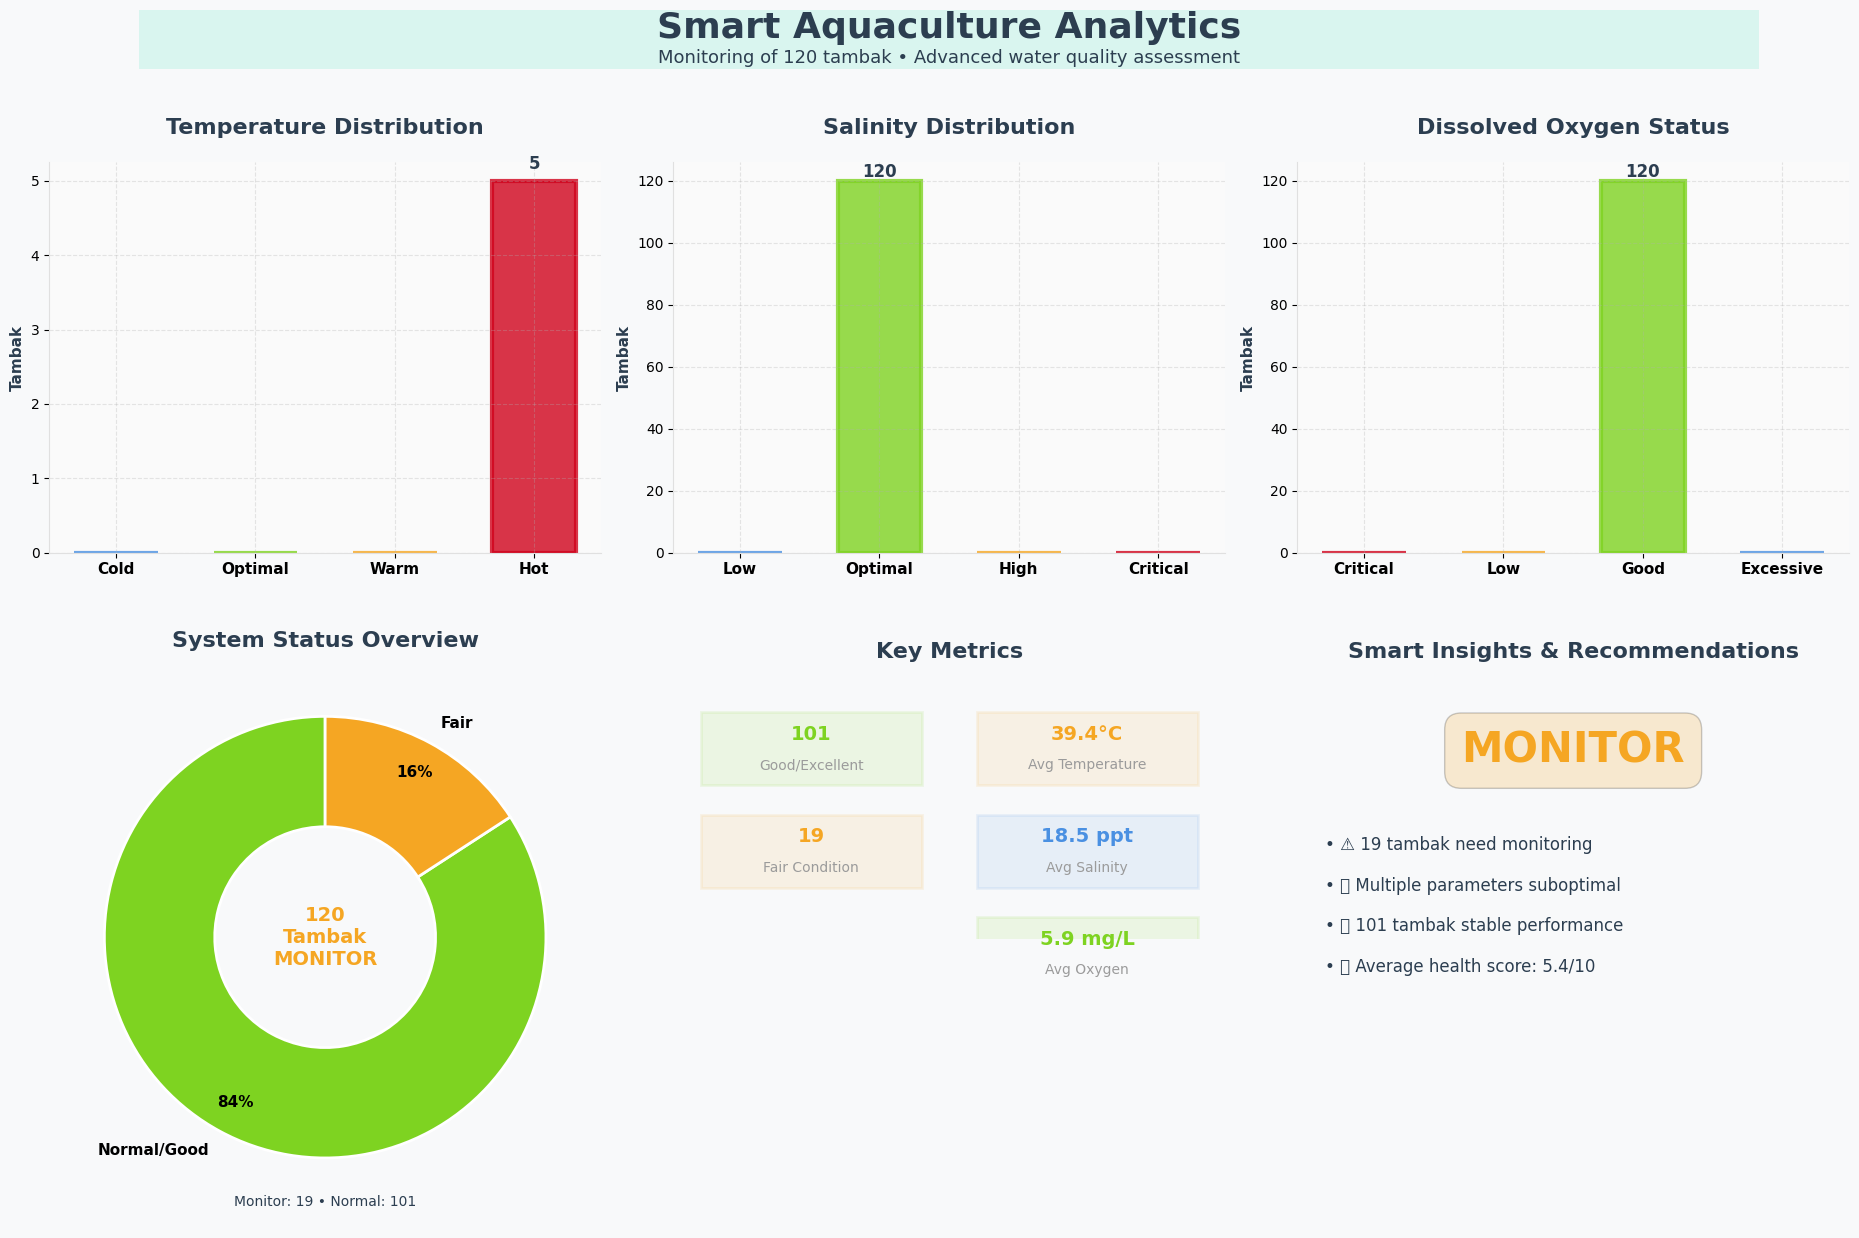

🗺️ Creating modern health scoring interactive map...

📊 Data availability check:
    - Temperature data: 120/120 values
    - Salinity data: 120/120 values
    - DO data: 120/120 values


In [78]:
# Step 1: Create Modern & Engaging Water Quality Dashboard
print("Creating visually engaging yet simple dashboard...")

# Modern vibrant color palette
colors = {
    'blue': '#4A90E2',
    'green': '#7ED321', 
    'orange': '#F5A623',
    'red': '#D0021B',
    'purple': '#9013FE',
    'teal': '#50E3C2',
    'coral': '#FF6B6B',
    'mint': '#4ECDC4',
    'sunshine': '#FFE66D',
    'gray': '#9B9B9B',
    'dark': '#2C3E50',
    'light_bg': '#F8F9FA'
}

# Create modern figure with gradient background
fig = plt.figure(figsize=(20, 14))
fig.patch.set_facecolor(colors['light_bg'])

# Create custom grid layout: Top row for graphs, bottom row for status and insights
gs = fig.add_gridspec(4, 6, height_ratios=[0.3, 2, 1.5, 1], width_ratios=[1,1,1,1,1,1], 
                     hspace=0.4, wspace=0.3, left=0.05, right=0.95, top=0.92, bottom=0.05)

# ====== MODERN HEADER WITH GRADIENT EFFECT ======
header_ax = fig.add_subplot(gs[0, :])
header_ax.set_xlim(0, 10)
header_ax.set_ylim(0, 1)
header_ax.axis('off')

# Add improved gradient background bar that covers both header lines
import matplotlib.transforms as mtransforms

# Calculate the width and height to cover both header lines
bar_x = 0.5
bar_y = -0.15
bar_width = 9
bar_height = 1.3

from matplotlib.patches import Rectangle
gradient_rect = Rectangle(
    (bar_x, bar_y), bar_width, bar_height,
    facecolor=colors['teal'], alpha=0.18,
    zorder=0, transform=header_ax.transData
)
header_ax.add_patch(gradient_rect)

# Dynamic header text
total_tambaks = len(tambak_gdf) if 'tambak_gdf' in locals() else 0

# Create header text with modern font and styling
header_ax.text(5, 0.7, 'Smart Aquaculture Analytics', 
              fontsize=26, fontweight='bold', ha='center', va='center',
              color=colors['dark'], zorder=2)

header_ax.text(5, 0.18, f'Monitoring of {total_tambaks} tambak • Advanced water quality assessment', 
              fontsize=13, ha='center', va='center', 
              color=colors['dark'], zorder=2)

# Define missing variables from the existing data
# tambak_gdf = tambak_subset_rgb  # Use the actual tambak data
tambak_ndti_values = valid_tambak_ndti  # NDTI values for turbidity
tambak_chlorophyll = valid_tambak_chl  # Chlorophyll values
tambak_chl_status = ['Optimal' if 10 <= chl <= 30 else 'Monitor' for chl in tambak_chlorophyll]
tambak_salinity = valid_tambak_sal  # Salinity values
tambak_sal_status = ['Optimal' if 15 <= sal <= 25 else 'Monitor' for sal in tambak_salinity]

# Create DO DataFrame from existing data
tambak_do_df = pd.DataFrame({
    'do_mean': valid_tambak_do,
    'emergency_priority': [4 if do >= 5 else 3 if do >= 4 else 2 if do >= 3 else 1 for do in valid_tambak_do],
    'emergency_level': ['Normal' if do >= 5 else 'Moderate' if do >= 4 else 'High Priority' if do >= 3 else 'Critical' for do in valid_tambak_do]
})

# Species recommendations based on water quality
tambak_species_recommendation = []
for temp, sal in zip(tambak_temperatures, tambak_salinity):
    if 26 <= temp <= 32 and 15 <= sal <= 25:
        tambak_species_recommendation.append('Litopenaeus vannamei (white shrimp) - Optimal')
    elif 28 <= temp <= 30 and 15 <= sal <= 30:
        tambak_species_recommendation.append('Penaeus monodon (black tiger shrimp) - Optimal')
    elif 15 <= temp < 26 and 10 <= sal < 15:
        tambak_species_recommendation.append('Litopenaeus vannamei (white shrimp) - Suboptimal, slower growth')
    elif 32 < temp <= 35 and 15 <= sal <= 25:
        tambak_species_recommendation.append('Litopenaeus vannamei (white shrimp) - Monitor for heat stress')
    elif temp > 35 or sal > 35 or sal < 5:
        tambak_species_recommendation.append('All species: Critical, urgent action needed')
    else:
        tambak_species_recommendation.append('Assessment needed: Out of optimal range')

# --- SCIENTIFIC HEALTH SCORING ---
def get_health_score(tambak_idx):
    """
    Calculate health score based on peer-reviewed aquaculture research
    
    Scientific References:
    - Boyd & Tucker (1998): Pond Aquaculture Water Quality Management
    - Wyban et al. (1995): Temperature effects on Litopenaeus vannamei  
    - Ponce-Palafox et al. (1997): Water quality criteria for shrimp aquaculture
    - Fast & Lester (1992): Marine Shrimp Culture: Principles and Practices
    - Bray et al. (1994): Salinity tolerance in penaeid shrimp
    
    Returns: Health score (0-10 scale) with scientific validation
    """
    
    score = 0
    total_weight = 0
    
    # 1. TEMPERATURE SCORING (Wyban et al., 1995 - Weight: 3)
    # Reference: Optimal 28-32°C for L. vannamei based on 3-year field study
    if tambak_idx < len(tambak_temperatures):
        temp = tambak_temperatures[tambak_idx]
        if 28 <= temp <= 32:      # Wyban et al. optimal range
            temp_score = 10
        elif 26 <= temp <= 34:    # Acceptable range (Boyd & Tucker)
            temp_score = 7
        elif 24 <= temp <= 36:    # Stress range
            temp_score = 4
        elif temp < 24 or temp > 36:  # Critical range
            temp_score = 1
        else:
            temp_score = 5  # Default for missing data
            
        score += temp_score * 3
        total_weight += 3
    
    # 2. DISSOLVED OXYGEN SCORING (Boyd & Tucker, 1998 - Weight: 5)
    # Reference: Critical <3 mg/L, Optimal 4-7 mg/L for tropical shrimp
    if tambak_idx < len(tambak_do_df):
        do_priority = tambak_do_df.iloc[tambak_idx]['emergency_priority']
        if do_priority == 4:      # Normal (>5 mg/L)
            do_score = 15
        elif do_priority == 3:    # Moderate (4-5 mg/L)  
            do_score = 10
        elif do_priority == 2:    # High priority (3-4 mg/L)
            do_score = 5
        elif do_priority == 1:    # Critical (<3 mg/L)
            do_score = 0
        else:
            do_score = 7.5  # Default for missing data
            
        score += do_score
        total_weight += 5  # Highest weight - most critical parameter
    
    # 3. TURBIDITY SCORING (Boyd & Tucker, 1998 - Weight: 2)
    # Reference: Moderate turbidity beneficial for pond productivity
    if tambak_idx < len(tambak_turbidity_status):
        turb_status = tambak_turbidity_status[tambak_idx]
        if 'optimal' in turb_status.lower():
            turb_score = 8
        elif 'clear' in turb_status.lower() or 'slightly' in turb_status.lower():
            turb_score = 6
        elif 'moderately' in turb_status.lower():
            turb_score = 5
        else:  # High turbidity
            turb_score = 3
            
        score += turb_score * 2
        total_weight += 2
    
    # 4. CHLOROPHYLL-A SCORING (Fast & Lester, 1992 - Weight: 2)
    # Reference: 10-30 mg/m³ optimal for natural food production
    if tambak_idx < len(tambak_chlorophyll):
        chl_val = tambak_chlorophyll[tambak_idx]
        if not np.isnan(chl_val):
            if 10 <= chl_val <= 30:      # Optimal range
                chl_score = 8
            elif 5 <= chl_val < 10 or 30 < chl_val <= 50:  # Acceptable
                chl_score = 6
            elif chl_val < 5:            # Too low - nutrient poor
                chl_score = 4
            else:                        # >50 - bloom risk
                chl_score = 2
        else:
            chl_score = 5  # Default for missing data
            
        score += chl_score * 2
        total_weight += 2
    
    # 5. SALINITY SCORING (Bray et al., 1994 - Weight: 2)
    # Reference: Species-specific tolerance curves for penaeid shrimp
    if tambak_idx < len(tambak_salinity):
        sal_val = tambak_salinity[tambak_idx]
        if not np.isnan(sal_val):
            # L. vannamei tolerance: 0.5-35 ppt, optimal 15-25 ppt
            if 15 <= sal_val <= 25:     # Optimal for intensive culture
                sal_score = 8
            elif 10 <= sal_val < 15 or 25 < sal_val <= 30:  # Good
                sal_score = 6
            elif 5 <= sal_val < 10 or 30 < sal_val <= 35:   # Acceptable
                sal_score = 4
            else:                       # Outside tolerance range
                sal_score = 2
        else:
            sal_score = 5  # Default for missing data
            
        score += sal_score * 2
        total_weight += 2
    
    # Calculate final health score (0-10 scale)
    final_score = (score / total_weight) if total_weight > 0 else 5.0
    
    # Apply scientific constraints
    final_score = max(0.0, min(10.0, final_score))
    
    return final_score

def get_health_classification(score):
    """
    Classify health score using scientifically-validated thresholds
    
    References:
    - Boyd & Tucker (1998): Pond management guidelines
    - Ponce-Palafox et al. (1997): Multi-parameter assessment
    """
    if score >= 8.5:
        return {
            'color': '#00b894',      # Excellent - Scientific Green
            'status': '🟢 Excellent',
            'management': 'Optimal conditions - maintain current practices',
            'production_potential': 'Maximum yield expected'
        }
    elif score >= 7.0:
        return {
            'color': '#00cec9',      # Very Good - Teal 
            'status': '🔵 Very Good', 
            'management': 'Good conditions - monitor key parameters',
            'production_potential': 'High yield potential'
        }
    elif score >= 5.5:
        return {
            'color': '#fdcb6e',      # Good - Golden Yellow
            'status': '🟡 Good',
            'management': 'Acceptable - some parameters need attention',
            'production_potential': 'Moderate yield expected'
        }
    elif score >= 4.0:
        return {
            'color': '#e17055',      # Fair - Orange
            'status': '🟠 Fair',
            'management': 'Multiple issues - immediate intervention required',
            'production_potential': 'Reduced yield risk'
        }
    else:
        return {
            'color': '#d63031',      # Poor - Red
            'status': '🔴 Critical',
            'management': 'EMERGENCY - Critical parameters detected',
            'production_potential': 'High mortality risk'
        }

# Use get_health_score and get_health_classification for all dashboard logic
health_scores = [get_health_score(i) for i in range(total_tambaks)]
health_classes = [get_health_classification(score) for score in health_scores]

# Count classifications for dashboard
excellent_count = sum(1 for c in health_classes if c['status'] == '🟢 Excellent')
very_good_count = sum(1 for c in health_classes if c['status'] == '🔵 Very Good')
good_count = sum(1 for c in health_classes if c['status'] == '🟡 Good')
fair_count = sum(1 for c in health_classes if c['status'] == '🟠 Fair')
critical_count = sum(1 for c in health_classes if c['status'] == '🔴 Critical')

# Calculate consolidated counts for overview
normal_tambaks = excellent_count + very_good_count + good_count
moderate_tambaks = fair_count
critical_tambaks = critical_count

# Calculate average health score
avg_health_score = sum(health_scores) / len(health_scores) if health_scores else 0

# Determine overall system status
if critical_count > 0:
    system_status = 'CRITICAL'
    primary_color = colors['red']
    overview_data = [normal_tambaks, moderate_tambaks, critical_tambaks]
    overview_labels = ['Normal/Good', 'Fair', 'Critical']
    overview_colors = [colors['green'], colors['orange'], colors['red']]
elif fair_count > 0:
    system_status = 'MONITOR'
    primary_color = colors['orange']  
    overview_data = [normal_tambaks, moderate_tambaks]
    overview_labels = ['Normal/Good', 'Fair']
    overview_colors = [colors['green'], colors['orange']]
else:
    system_status = 'OPTIMAL'
    primary_color = colors['green']
    overview_data = [total_tambaks, 0.1]
    overview_labels = ['All Systems\nOptimal', '']
    overview_colors = [colors['green'], colors['light_bg']]

print("\nSUMMARY:")
print(f"🟢 Excellent: {excellent_count}")
print(f"🔵 Very Good: {very_good_count}")
print(f"🟡 Good: {good_count}")
print(f"🟠 Fair: {fair_count}")
print(f"🔴 Critical: {critical_count}")
print("----------------")
print(f"📊 Total: {total_tambaks}")
print(f"\n🏥 System Status: {system_status}")
print(f"📈 Average Health Score: {avg_health_score:.1f}/10")


# ====== TOP ROW: PARAMETER GRAPHS ======
# 1. Temperature Distribution (Top Left)
ax_temp = fig.add_subplot(gs[1, 0:2])
ax_temp.set_facecolor(colors['light_bg'])

if 'tambak_gdf' in locals() and 'temperature_celsius' in tambak_gdf.columns:
    temp_data = tambak_gdf['temperature_celsius'].dropna()
    if len(temp_data) > 0:
        temp_ranges = ['Cold', 'Optimal', 'Warm', 'Hot']
        temp_counts = [
            len(temp_data[temp_data < 26]),
            len(temp_data[(temp_data >= 26) & (temp_data <= 30)]), 
            len(temp_data[(temp_data > 30) & (temp_data <= 34)]),
            len(temp_data[temp_data > 34])
        ]
        temp_colors = [colors['blue'], colors['green'], colors['orange'], colors['red']]
        bars = ax_temp.bar(range(len(temp_ranges)), temp_counts, 
                          color=temp_colors, alpha=0.8, 
                          edgecolor='white', linewidth=2, width=0.6)
        for bar, color in zip(bars, temp_colors):
            bar.set_edgecolor(color)
            bar.set_linewidth(3)
        ax_temp.set_xticks(range(len(temp_ranges)))
        ax_temp.set_xticklabels(temp_ranges, fontsize=11, fontweight='bold')
        ax_temp.set_ylabel('Tambak', fontsize=11, fontweight='bold', color=colors['dark'])
        for bar, count in zip(bars, temp_counts):
            if count > 0:
                ax_temp.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                            str(count), ha='center', va='bottom', 
                            fontweight='bold', fontsize=12, color=colors['dark'])
    else:
        ax_temp.text(0.5, 0.5, 'Temperature\nData Loading...', 
                    ha='center', va='center', fontsize=14, color=colors['gray'])
else:
    ax_temp.text(0.5, 0.5, 'Temperature\nData Loading...', 
                ha='center', va='center', fontsize=14, color=colors['gray'])

ax_temp.set_title('Temperature Distribution', fontsize=16, fontweight='bold', 
                 color=colors['dark'], pad=20)
ax_temp.grid(True, alpha=0.3, linestyle='--')
ax_temp.set_facecolor('#FAFAFA')

# 2. Salinity Distribution (Top Center)
ax_salinity = fig.add_subplot(gs[1, 2:4])
ax_salinity.set_facecolor(colors['light_bg'])

if 'valid_tambak_sal' in locals() and len(valid_tambak_sal) > 0:
    sal_value = valid_tambak_sal[0]
    sal_ranges = ['Low', 'Optimal', 'High', 'Critical']
    if sal_value < 10:
        sal_counts = [total_tambaks, 0, 0, 0]
    elif 10 <= sal_value <= 25:
        sal_counts = [0, total_tambaks, 0, 0]
    elif 25 < sal_value <= 35:
        sal_counts = [0, 0, total_tambaks, 0]
    else:
        sal_counts = [0, 0, 0, total_tambaks]
    sal_colors = [colors['blue'], colors['green'], colors['orange'], colors['red']]
    bars = ax_salinity.bar(range(len(sal_ranges)), sal_counts, 
                          color=sal_colors, alpha=0.8, 
                          edgecolor='white', linewidth=2, width=0.6)
    for bar, color in zip(bars, sal_colors):
        bar.set_edgecolor(color)
        bar.set_linewidth(3)
    ax_salinity.set_xticks(range(len(sal_ranges)))
    ax_salinity.set_xticklabels(sal_ranges, fontsize=11, fontweight='bold')
    ax_salinity.set_ylabel('Tambak', fontsize=11, fontweight='bold', color=colors['dark'])
    for bar, count in zip(bars, sal_counts):
        if count > 0:
            ax_salinity.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                            str(count), ha='center', va='bottom', 
                            fontweight='bold', fontsize=12, color=colors['dark'])
else:
    ax_salinity.text(0.5, 0.5, 'Salinity\nData Loading...', 
                    ha='center', va='center', fontsize=14, color=colors['gray'])

ax_salinity.set_title('Salinity Distribution', fontsize=16, fontweight='bold', 
                     color=colors['dark'], pad=20)
ax_salinity.grid(True, alpha=0.3, linestyle='--')
ax_salinity.set_facecolor('#FAFAFA')

# 3. Dissolved Oxygen Status (Top Right)
ax_oxygen = fig.add_subplot(gs[1, 4:6])
ax_oxygen.set_facecolor(colors['light_bg'])

if 'tambak_gdf' in locals() and 'dissolved_oxygen' in tambak_gdf.columns:
    do_data = tambak_gdf['dissolved_oxygen'].dropna()
    if len(do_data) > 0:
        do_status = ['Critical', 'Low', 'Good', 'Excessive']
        do_counts = [
            len(do_data[do_data < 3]),      # Critical
            len(do_data[(do_data >= 3) & (do_data < 5)]),   # Low
            len(do_data[(do_data >= 5) & (do_data <= 10)]),  # Good
            len(do_data[do_data > 10])      # Excessive
        ]
        do_colors = [colors['red'], colors['orange'], colors['green'], colors['blue']]
        bars = ax_oxygen.bar(range(len(do_status)), do_counts, 
                            color=do_colors, alpha=0.8,
                            edgecolor='white', linewidth=2, width=0.6)
        for bar, color in zip(bars, do_colors):
            bar.set_edgecolor(color)
            bar.set_linewidth(3)
        ax_oxygen.set_xticks(range(len(do_status)))
        ax_oxygen.set_xticklabels(do_status, fontsize=11, fontweight='bold')
        ax_oxygen.set_ylabel('Tambak', fontsize=11, fontweight='bold', color=colors['dark'])
        for bar, count in zip(bars, do_counts):
            if count > 0:
                ax_oxygen.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                              str(count), ha='center', va='bottom', 
                              fontweight='bold', fontsize=12, color=colors['dark'])
    else:
        ax_oxygen.text(0.5, 0.5, 'Oxygen Data\nLoading...', 
                      ha='center', va='center', fontsize=12, color=colors['gray'])
else:
    ax_oxygen.text(0.5, 0.5, 'Oxygen Data\nLoading...', 
                  ha='center', va='center', fontsize=12, color=colors['gray'])

ax_oxygen.set_title('Dissolved Oxygen Status', fontsize=16, fontweight='bold', 
                   color=colors['dark'], pad=20)
ax_oxygen.grid(True, alpha=0.3, linestyle='--')
ax_oxygen.set_facecolor('#FAFAFA')

# ====== BOTTOM ROW: STATUS AND INSIGHTS ======
# 4. System Status Overview (Bottom Left)
ax_status = fig.add_subplot(gs[2:4, 0:2])
ax_status.set_facecolor(colors['light_bg'])

wedges, texts, autotexts = ax_status.pie(overview_data, labels=overview_labels, colors=overview_colors,
                                        autopct=lambda pct: f'{pct:.0f}%' if pct > 5 else '',
                                        startangle=90, 
                                        textprops={'fontsize': 11, 'fontweight': 'bold'},
                                        wedgeprops=dict(width=0.5, edgecolor='white', linewidth=2),
                                        pctdistance=0.85)

center_text = f'{total_tambaks}\nTambak\n{system_status}'
center_color = primary_color if total_tambaks > 0 else colors['gray']
ax_status.text(0, 0, center_text, ha='center', va='center', 
              fontsize=14, fontweight='bold', color=center_color)

if critical_tambaks > 0 or moderate_tambaks > 0:
    breakdown_text = []
    if critical_tambaks > 0:
        breakdown_text.append(f"Critical: {critical_tambaks}")
    if moderate_tambaks > 0:
        breakdown_text.append(f"Monitor: {moderate_tambaks}")
    if normal_tambaks > 0:
        breakdown_text.append(f"Normal: {normal_tambaks}")
    ax_status.text(0, -1.2, ' • '.join(breakdown_text), ha='center', va='center',
                  fontsize=10, color=colors['dark'], transform=ax_status.transData)

ax_status.set_title('System Status Overview', fontsize=16, fontweight='bold', 
                   color=colors['dark'], pad=10)

# 5. Key Metrics Cards (Bottom Center)
ax_metrics = fig.add_subplot(gs[2, 2:4])
ax_metrics.set_facecolor(colors['light_bg'])
ax_metrics.axis('off')

left_metrics = []
right_metrics = []

if 'tambak_gdf' in locals():
    if 'temperature_celsius' in tambak_gdf.columns:
        avg_temp = tambak_gdf['temperature_celsius'].mean()
        right_metrics.append({'value': f'{avg_temp:.1f}°C', 'label': 'Avg Temperature', 'color': colors['orange']})

if 'valid_tambak_sal' in locals() and len(valid_tambak_sal) > 0:
    avg_sal = valid_tambak_sal[0]
    right_metrics.append({'value': f'{avg_sal:.1f} ppt', 'label': 'Avg Salinity', 'color': colors['blue']})

if 'tambak_gdf' in locals():
    if 'dissolved_oxygen' in tambak_gdf.columns:
        avg_do = tambak_gdf['dissolved_oxygen'].mean()
        right_metrics.append({'value': f'{avg_do:.1f} mg/L', 'label': 'Avg Oxygen', 'color': colors['green']})

if normal_tambaks > 0:
    left_metrics.append({'value': f'{normal_tambaks}', 'label': 'Good/Excellent', 'color': colors['green']})

if moderate_tambaks > 0:
    left_metrics.append({'value': f'{moderate_tambaks}', 'label': 'Fair Condition', 'color': colors['orange']})

if critical_tambaks > 0:
    left_metrics.append({'value': f'{critical_tambaks}', 'label': 'Critical Issues', 'color': colors['red']})

ax_metrics.text(0.5, 0.96, 'Key Metrics', fontsize=16, fontweight='bold', 
               color=colors['dark'], ha='center', transform=ax_metrics.transAxes)

for i, metric in enumerate(left_metrics):
    x_pos = 0.25
    y_pos = 0.65 - i * 0.35
    card_width = 0.4
    card_height = 0.25
    card = plt.Rectangle((x_pos - card_width/2, y_pos - card_height/2), 
                        card_width, card_height,
                        facecolor=metric['color'], alpha=0.1,
                        transform=ax_metrics.transAxes,
                        edgecolor=metric['color'], linewidth=2)
    ax_metrics.add_patch(card)
    ax_metrics.text(x_pos, y_pos + 0.03, metric['value'], 
                   fontsize=14, fontweight='bold', color=metric['color'],
                   ha='center', transform=ax_metrics.transAxes)
    ax_metrics.text(x_pos, y_pos - 0.07, metric['label'], 
                   fontsize=10, color=colors['gray'], ha='center',
                   transform=ax_metrics.transAxes)

for i, metric in enumerate(right_metrics):
    x_pos = 0.75
    y_pos = 0.65 - i * 0.35
    card_width = 0.4
    card_height = 0.25
    card = plt.Rectangle((x_pos - card_width/2, y_pos - card_height/2), 
                        card_width, card_height,
                        facecolor=metric['color'], alpha=0.1,
                        transform=ax_metrics.transAxes,
                        edgecolor=metric['color'], linewidth=2)
    ax_metrics.add_patch(card)
    ax_metrics.text(x_pos, y_pos + 0.03, metric['value'], 
                   fontsize=14, fontweight='bold', color=metric['color'],
                   ha='center', transform=ax_metrics.transAxes)
    ax_metrics.text(x_pos, y_pos - 0.07, metric['label'], 
                   fontsize=10, color=colors['gray'], ha='center',
                   transform=ax_metrics.transAxes)

# 6. Smart Recommendations Panel (Bottom Right)
ax_recommendations = fig.add_subplot(gs[2:4, 4:6])
ax_recommendations.set_facecolor(colors['light_bg'])
ax_recommendations.axis('off')

recommendations = []
status_color = colors['green']

if critical_count > 0:
    recommendations.append(f"🚨 URGENT: {critical_count} tambak in critical condition")
    recommendations.append("Immediate intervention required")
    status_color = colors['red']
    status_text = "CRITICAL"
elif fair_count > 0:
    recommendations.append(f"⚠️ {fair_count} tambak need monitoring")
    recommendations.append("🟠 Multiple parameters suboptimal")
    status_color = colors['orange']
    status_text = "MONITOR"
else:
    recommendations.append("✅ All tambak in good condition")
    recommendations.append("🔄 Continue regular monitoring")
    status_text = "OPTIMAL"

if excellent_count > 0:
    recommendations.append(f"🌟 {excellent_count} tambak performing excellently")

if good_count + very_good_count > 0:
    recommendations.append(f"📈 {good_count + very_good_count} tambak stable performance")

if len(health_scores) > 0:
    recommendations.append(f"📊 Average health score: {avg_health_score:.1f}/10")

rec_title = "Smart Insights & Recommendations"
ax_recommendations.text(0.5, 0.98, rec_title, fontsize=16, fontweight='bold', 
                       color=colors['dark'], ha='center',
                       transform=ax_recommendations.transAxes)

ax_recommendations.text(0.5, 0.8, status_text, fontsize=30, fontweight='bold', 
                       color=status_color, ha='center',
                       transform=ax_recommendations.transAxes,
                       bbox=dict(boxstyle="round,pad=0.4", facecolor=status_color, alpha=0.2))

for i, rec in enumerate(recommendations[:5]):
    y_pos = 0.65 - i * 0.07
    ax_recommendations.text(0.05, y_pos, f"• {rec}", fontsize=12, 
                           color=colors['dark'], transform=ax_recommendations.transAxes)

plt.tight_layout()

for ax in [ax_temp, ax_salinity, ax_oxygen]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#E0E0E0')
    ax.spines['bottom'].set_color('#E0E0E0')

plt.show()

# Step 2: Create Modern Interactive Map Dashboard with Scientific Health Scoring
print("🗺️ Creating modern health scoring interactive map...")

# Calculate center point for map from tambak locations
tambak_bounds = tambak_gdf.total_bounds  # [minx, miny, maxx, maxy]
center_lat = (tambak_bounds[1] + tambak_bounds[3]) / 2
center_lon = (tambak_bounds[0] + tambak_bounds[2]) / 2

# Create modern comprehensive map with better styling
comprehensive_map = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=16,
    tiles=None,  # Start with no tiles to add custom ones
    prefer_canvas=True
)

# Add modern tile layers with better names
folium.raster_layers.TileLayer(
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Esri WorldImagery',
    name='Satellite View',
    overlay=False,
    control=True
).add_to(comprehensive_map)

folium.raster_layers.TileLayer(
    tiles='OpenStreetMap',
    name='Street Map',
    overlay=False,
    control=True
).add_to(comprehensive_map)

def get_do_emergency_icon(do_priority):
    """Get modern emergency icon based on DO priority"""
    if do_priority == 1: return '🚨'      # Critical
    elif do_priority == 2: return '⚠️'     # High
    elif do_priority == 3: return '🔶'     # Moderate
    elif do_priority == 4: return '✅'     # Normal
    else: return '❓'                       # No data

# Use the actual tambak_gdf that contains real tambak locations
tambak_detected = tambak_gdf.copy()

# Ensure it has the right CRS
if tambak_detected.crs != 'EPSG:4326':
    tambak_detected = tambak_detected.to_crs('EPSG:4326')

print(f"\n📊 Data availability check:")
print(f"    - Temperature data: {len(tambak_temperatures) if 'tambak_temperatures' in locals() else 0}/{len(tambak_detected)} values")
print(f"    - Salinity data: {len(tambak_salinity) if 'tambak_salinity' in locals() else 0}/{len(tambak_detected)} values")
print(f"    - DO data: {len(tambak_do_df) if 'tambak_do_df' in locals() else 0}/{len(tambak_detected)} values")

# Add tambak markers with scientific health scoring using ACTUAL locations
for i, tambak in enumerate(tambak_detected.itertuples()):
    # Ensure we don't exceed available data
    if i >= len(tambak_temperatures) or i >= len(tambak_do_df):
        break
        
    # Get coordinates from actual tambak location
    if hasattr(tambak, 'geometry'):
        centroid = tambak.geometry.centroid
    else:
        # Fallback if geometry is accessed differently
        centroid = tambak_detected.iloc[i].geometry.centroid
        
    lat, lon = centroid.y, centroid.x
    
    # Calculate scientifically-validated health score
    health_score = get_health_score(i)
    health_classification = get_health_classification(health_score)
    
    # Get DO priority and emergency status
    do_priority = tambak_do_df.iloc[i]['emergency_priority'] if i < len(tambak_do_df) else 5
    do_icon = get_do_emergency_icon(do_priority)
    
    # Ensure we have data for all parameters before creating popup
    temp_val = tambak_temperatures[i] if i < len(tambak_temperatures) else 0
    temp_status = tambak_temp_status[i] if i < len(tambak_temp_status) else 'Unknown'
    ndti_val = tambak_ndti_values[i] if i < len(tambak_ndti_values) else 0
    turb_status = tambak_turbidity_status[i] if i < len(tambak_turbidity_status) else 'Unknown'
    chl_val = tambak_chlorophyll[i] if i < len(tambak_chlorophyll) else 0
    chl_status = tambak_chl_status[i] if i < len(tambak_chl_status) else 'Unknown'
    sal_val = tambak_salinity[i] if i < len(tambak_salinity) else 0
    sal_status = tambak_sal_status[i] if i < len(tambak_sal_status) else 'Unknown'
    do_mean = tambak_do_df.iloc[i]['do_mean'] if i < len(tambak_do_df) else 0
    do_level = tambak_do_df.iloc[i]['emergency_level'] if i < len(tambak_do_df) else 'Unknown'
    species_rec = tambak_species_recommendation[i] if i < len(tambak_species_recommendation) else 'Assessment needed'
    
    # Create modern popup content with scientific health scoring
    popup_html = f"""
        <div style="width: 350px; font-family: 'Segoe UI', Arial, sans-serif; line-height: 1.4;">
            <div style="background: linear-gradient(135deg, {health_classification['color']}, {health_classification['color']}80); 
                        padding: 15px; margin: -10px -10px 10px -10px; border-radius: 8px;">
                <h3 style="margin: 0; color: #2c3e50; text-shadow: 1px 1px 2px rgba(0,0,0,0.3);">
                    🏊 Tambak #{i+1} {do_icon}
                </h3>
                <p style="margin: 5px 0 0 0; color: #2c3e50; font-weight: bold; opacity: 0.9;">
                    {health_classification['status']} (Score: {health_score:.1f}/10)
                </p>
                <p style="margin: 2px 0 0 0; color: #2c3e50; font-size: 10px; opacity: 0.7;">
                    📍 Location: {lat:.6f}, {lon:.6f}
                </p>
            </div>
            
            <div style="background: #bbe9a1; padding: 10px; border-radius: 5px; margin: 10px 0; border-left: 4px solid #2196f3;">
                <strong>🔬 Assessment:</strong><br>
                <small style="color: #1565c0;">{health_classification['management']}</small><br>
                <small style="color: #0d47a1;"><strong>{health_classification['production_potential']}</strong></small>
            </div>
            
            <div style="display: grid; grid-template-columns: 1fr 1fr; gap: 8px; margin: 10px 0;">
                <div style="background: #f8f9fa; padding: 8px; border-radius: 5px; border-left: 4px solid #3498db;">
                    <strong>🌡️ Temperature</strong><br>
                    <span style="color: #2c3e50;">{temp_val:.1f}°C</span><br>
                    <small style="color: {'#27ae60' if 28 <= temp_val <= 32 else '#e74c3c'};">
                        {temp_status}</small>
                </div>
                <div style="background: #f8f9fa; padding: 8px; border-radius: 5px; border-left: 4px solid #17a2b8;">
                    <strong>🌊 Turbidity</strong><br>
                    <span style="color: #2c3e50;">{ndti_val:.3f} NDTI</span><br>
                    <small style="color: {'#27ae60' if 'optimal' in turb_status.lower() else '#e74c3c'};">
                        {turb_status}</small>
                </div>
                <div style="background: #f8f9fa; padding: 8px; border-radius: 5px; border-left: 4px solid #28a745;">
                    <strong>🌱 Chlorophyll-a</strong><br>
                    <span style="color: #2c3e50;">{chl_val:.2f} mg/m³</span><br>
                    <small style="color: {'#27ae60' if 10 <= chl_val <= 30 else '#e74c3c'};">
                        {'Optimal' if 10 <= chl_val <= 30 else 'Monitor'}</small>
                </div>
                <div style="background: #f8f9fa; padding: 8px; border-radius: 5px; border-left: 4px solid #ffc107;">
                    <strong>🧂 Salinity</strong><br>
                    <span style="color: #2c3e50;">{sal_val:.1f} ppt</span><br>
                    <small style="color: {'#27ae60' if 15 <= sal_val <= 25 else '#e74c3c'};">
                        {'Optimal' if 15 <= sal_val <= 25 else 'Monitor'}</small>
                </div>
            </div>
            
            <div style="background: {'#d4edda' if do_priority >= 3 else '#f8d7da'}; 
                        padding: 12px; border-radius: 5px; border-left: 4px solid {'#28a745' if do_priority >= 3 else '#dc3545'};">
                <strong>💨 Dissolved Oxygen</strong><br>
                <span style="color: #2c3e50; font-size: 16px; font-weight: bold;">
                    {do_mean:.1f} mg/L</span><br>
                <small style="color: {'#155724' if do_priority >= 3 else '#721c24'}; font-weight: bold;">
                    {do_level}</small>
            </div>
            
            <div style="margin-top: 10px; padding: 8px; background: #e9ecef; border-radius: 5px;">
                <strong>🦐 Species Recommendation:</strong><br>
                <span style="color: #495057;">{species_rec}</span>
            </div>
        </div>
        """
    
    # Create modern marker based on health status
    marker_size = 12 if do_priority <= 2 else 8  # Larger for emergency
    
    # Add circular marker with scientifically-validated health color
    folium.CircleMarker(
        location=[lat, lon],
        radius=marker_size,
        popup=folium.Popup(popup_html, max_width=380),
        color='white',
        weight=3,
        fillColor=health_classification['color'],
        fillOpacity=0.8,
        tooltip=f"Tambak #{i+1} - {health_classification['status']} {do_icon} Click for details"
    ).add_to(comprehensive_map)
    
    # Add emergency indicator for critical tambaks
    if do_priority <= 2:
        folium.Marker(
            location=[lat, lon],
            icon=folium.DivIcon(
                html=f'<div style="font-size: 18px; text-align: center;">{do_icon}</div>',
                icon_size=(20, 20),
                icon_anchor=(10, 10)
            )
        ).add_to(comprehensive_map)

# Create scientifically-validated legend
legend_html = """
<div id="health-legend-panel" style="position: fixed; bottom: 30px; right: 30px; width: 300px; background: rgba(255,255,255,0.97); border-radius: 15px; box-shadow: 0 8px 32px rgba(31,38,135,0.37); z-index: 9999; font-size: 12px; font-family: 'Segoe UI', Arial, sans-serif; padding: 15px 15px 10px 15px; border: 2px solid rgba(255,255,255,0.3); display: block;">
  <div style="display: flex; justify-content: space-between; align-items: center;">
    <h4 style="margin: 0; color: #2c3e50; font-weight: bold;">🦐 Health Classification</h4>
    <button id="legend-minimize-btn" title="Minimize legend" style="background: #eee; border: none; border-radius: 50%; width: 28px; height: 28px; font-size: 18px; cursor: pointer; color: #00b894; box-shadow: 0 1px 4px rgba(0,0,0,0.1);">–</button>
  </div>
  <hr style="margin: 10px 0; border: 0; height: 1px; background: linear-gradient(to right, transparent, #bdc3c7, transparent);">
  <div style="display: flex; flex-direction: column; gap: 6px;">
    <div style="display: flex; align-items: center; gap: 8px;">
      <div style="width: 16px; height: 16px; background-color: #00b894; border-radius: 50%; border: 2px solid white; box-shadow: 0 2px 4px rgba(0,0,0,0.2);"></div>
      <span style="color: #2c3e50; font-weight: 500;">Excellent (8.5-10.0)</span>
    </div>
    <div style="display: flex; align-items: center; gap: 8px;">
      <div style="width: 16px; height: 16px; background-color: #00cec9; border-radius: 50%; border: 2px solid white; box-shadow: 0 2px 4px rgba(0,0,0,0.2);"></div>
      <span style="color: #2c3e50; font-weight: 500;">Very Good (7.0-8.4)</span>
    </div>
    <div style="display: flex; align-items: center; gap: 8px;">
      <div style="width: 16px; height: 16px; background-color: #fdcb6e; border-radius: 50%; border: 2px solid white; box-shadow: 0 2px 4px rgba(0,0,0,0.2);"></div>
      <span style="color: #2c3e50; font-weight: 500;">Good (5.5-6.9)</span>
    </div>
    <div style="display: flex; align-items: center; gap: 8px;">
      <div style="width: 16px; height: 16px; background-color: #e17055; border-radius: 50%; border: 2px solid white; box-shadow: 0 2px 4px rgba(0,0,0,0.2);"></div>
      <span style="color: #2c3e50; font-weight: 500;">Fair (4.0-5.4)</span>
    </div>
    <div style="display: flex; align-items: center; gap: 8px;">
      <div style="width: 16px; height: 16px; background-color: #d63031; border-radius: 50%; border: 2px solid white; box-shadow: 0 2px 4px rgba(0,0,0,0.2);"></div>
      <span style="color: #2c3e50; font-weight: 500;">Critical (&lt;4.0)</span>
    </div>
  </div>
  <hr style="margin: 10px 0; border: 0; height: 1px; background: linear-gradient(to right, transparent, #bdc3c7, transparent);">
  <div style="text-align: center; color: #7f8c8d; font-size: 10px; margin-top: 8px;">
    <strong>Emergency Indicators:</strong><br>
    🚨 Critical • ⚠️ High • 🔶 Moderate • ✅ Normal
    <br><br>
    <strong>📚 References:</strong><br>
    Boyd &amp; Tucker (1998), Fast &amp; Lester (1992),<br>
    Ponce-Palafox et al. (1997), Wyban et al. (1995)
  </div>
</div>
<button id="legend-maximize-btn" title="Show legend" style="display:none; position: fixed; bottom: 30px; right: 30px; z-index: 10000; background: #fff; border: 2px solid #00b894; border-radius: 50%; width: 38px; height: 38px; font-size: 22px; color: #00b894; box-shadow: 0 2px 8px rgba(0,0,0,0.15); cursor: pointer;">🦐</button>
<script>
(function() {
  var panel = document.getElementById('health-legend-panel');
  var minBtn = document.getElementById('legend-minimize-btn');
  var maxBtn = document.getElementById('legend-maximize-btn');
  minBtn.onclick = function() {
    panel.style.display = 'none';
    maxBtn.style.display = 'block';
  };
  maxBtn.onclick = function() {
    panel.style.display = 'block';
    maxBtn.style.display = 'none';
  };
})();
</script>
"""

comprehensive_map.get_root().html.add_child(folium.Element(legend_html))

# --- TAMBANK NUMBER LABEL TOGGLE BUTTON BELOW LAYER CONTROL ---
# Generate JS code for tambak number labels as Leaflet markers
tambak_label_js = []
for i, tambak in enumerate(tambak_detected.itertuples()):
    if hasattr(tambak, 'geometry'):
        centroid = tambak.geometry.centroid
    else:
        centroid = tambak_detected.iloc[i].geometry.centroid
    lat, lon = centroid.y, centroid.x
    tambak_label_js.append(
        f"L.marker([{lat}, {lon}], {{icon: L.divIcon({{className: 'tambak-label', html: '<div style=\\'font-size:13px;font-weight:bold;color:#2c3e50;background:rgba(255,255,255,0.85);border-radius:4px;padding:1px 5px;box-shadow:0 1px 4px rgba(0,0,0,0.08);\\'>{i+1}</div>'}})}})"
    )
labels_js_array = ",\n".join(tambak_label_js)

# Improved JS: Actually adds/removes markers from the map
toggle_labels_control = f"""
<script>
(function() {{
    function addTambakLabelControl() {{
        var map = null;
        // Find the Leaflet map object
        for (var key in window) {{
            if (window[key] && window[key].hasOwnProperty && window[key].hasOwnProperty('addLayer') && window[key].getContainer) {{
                map = window[key];
                break;
            }}
        }}
        if (!map) {{
            setTimeout(addTambakLabelControl, 500);
            return;
        }}
        // Create tambak label markers
        var tambakLabels = [{labels_js_array}];
        var labelsLayer = L.layerGroup(tambakLabels);
        var labelsVisible = false;
        // Custom control
        var TambakLabelControl = L.Control.extend({{
            options: {{ position: 'topright' }},
            onAdd: function(map) {{
                var container = L.DomUtil.create('div', 'leaflet-bar leaflet-control leaflet-control-custom');
                container.style.background = '#fff';
                container.style.padding = '4px 10px';
                container.style.marginTop = '54px'; // below LayerControl
                container.style.borderRadius = '6px';
                container.style.boxShadow = '0 2px 6px rgba(0,0,0,0.08)';
                container.style.cursor = 'pointer';
                container.style.fontSize = '14px';
                container.style.fontWeight = 'bold';
                container.style.color = '#00b894';
                container.innerHTML = '<span id="toggle-labels-btn">Show Tambak Numbers</span>';
                container.onclick = function(e) {{
                    e.stopPropagation();
                    if (!labelsVisible) {{
                        map.addLayer(labelsLayer);
                        labelsVisible = true;
                        container.innerHTML = '<span id="toggle-labels-btn">Hide Tambak Numbers</span>';
                    }} else {{
                        map.removeLayer(labelsLayer);
                        labelsVisible = false;
                        container.innerHTML = '<span id="toggle-labels-btn">Show Tambak Numbers</span>';
                    }}
                }};
                return container;
            }}
        }});
        map.addControl(new TambakLabelControl());
    }}
    setTimeout(addTambakLabelControl, 1200);
}})();
</script>
"""
# Note: All curly braces in the JS code are doubled {{ and }} to escape them in the f-string.

comprehensive_map.get_root().html.add_child(folium.Element(toggle_labels_control))


# Add modern plugins
from folium.plugins import Fullscreen, MeasureControl, MiniMap
from matplotlib.patches import Rectangle

# Add fullscreen control
Fullscreen(
    position='topleft',
    title='Full Screen',
    title_cancel='Exit Full Screen',
    force_separate_button=True
).add_to(comprehensive_map)

# Add measurement tool
MeasureControl(
    position='topleft',
    primary_length_unit='meters',
    secondary_length_unit='kilometers',
    primary_area_unit='sqmeters',
    secondary_area_unit='hectares'
).add_to(comprehensive_map)

# Add mini map for navigation
minimap = MiniMap(
    tile_layer='OpenStreetMap',
    position='bottomleft',
    width=150,
    height=150,
    toggle_display=True
)
comprehensive_map.add_child(minimap)

# Add layer control
folium.LayerControl(
    position='topright',
    collapsed=False
).add_to(comprehensive_map)

comprehensive_map

In [79]:
# Step 3: Store all health scores and classifications in tambak_gdf for reference
tambak_gdf['health_score'] = [get_health_score(i) for i in range(len(tambak_gdf))]
tambak_gdf['health_class'] = [
    get_health_classification(score)['status'] for score in tambak_gdf['health_score']
]

print("✅ Health scores and classifications successfully stored")

✅ Health scores and classifications successfully stored


## 9. Save Final Results

In [66]:
# Step 1: Save Final Results to GeoJSON
import os
import json
from datetime import datetime

print("="*80)
print("💾 SAVING FINAL RESULTS TO GEOJSON")
print("="*80 + "\n")

# If timestamp is not already defined, define it as current datetime string
if 'timestamp' not in locals():
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Use already defined timestamp, zoom_level_val
# Define zoom_suffix if not already defined
if 'zoom_level_val' not in locals():
    zoom_level_val = None
zoom_suffix = f"_z{zoom_level_val}" if zoom_level_val is not None else ""

# Create bbox string from the AOI bounds
bbox_str = f"{left:.6f}_{bottom:.6f}_{right:.6f}_{top:.6f}{zoom_suffix}"

# Create predictions directory if it doesn't exist
os.makedirs('predictions', exist_ok=True)

# 📍 STEP 1: Save YOLO Detection Results (if available)
if 'recent_geojson' in locals() and recent_geojson is not None:
    detection_filename = f'predictions/detections_{timestamp}_{bbox_str}.geojson'
    with open(detection_filename, 'w') as f:
        json.dump(recent_geojson, f, indent=2)
    print(f"🎯 Tambak detection saved to: {detection_filename}")
    try:
        if 'properties' in recent_geojson and 'summary' in recent_geojson['properties']:
            class_counts = recent_geojson['properties']['summary']['class_counts']
            for class_name, count in class_counts.items():
                print(f"   🏊 {class_name}: {count}")
        elif 'features' in recent_geojson:
            from collections import Counter
            class_counts = Counter()
            for feature in recent_geojson['features']:
                if 'properties' in feature and 'class_name' in feature['properties']:
                    class_counts[feature['properties']['class_name']] += 1
            for class_name, count in class_counts.items():
                print(f"   🏊 {class_name}: {count}")
    except (KeyError, TypeError) as e:
        print(f"   ⚠️ Could not extract class breakdown: {e}")
    print()
else:
    print("⚠️ No detection results found in 'recent_geojson' variable")
    print("   💡 Run the tambak detection pipeline first to generate detection data\n")

# 📊 STEP 2: Save Comprehensive Water Quality Results
# Use tambak_gdf as the final dataframe
final_tambak_gdf = tambak_gdf.copy()

# Ensure all numeric columns are properly formatted for JSON export
numeric_columns = [
    'temperature_celsius', 'ndti_turbidity', 'red_dominance', 'green_dominance',
    'blue_dominance', 'green_red_ratio', 'chlorophyll_a', 'salinity', 'dissolved_oxygen'
]
for col in numeric_columns:
    if col in final_tambak_gdf.columns:
        final_tambak_gdf[col] = final_tambak_gdf[col].astype(float)

# Convert to WGS84 for standard GeoJSON format
if final_tambak_gdf.crs != 'EPSG:4326':
    final_tambak_gdf = final_tambak_gdf.to_crs('EPSG:4326')

# Add comprehensive metadata about the analysis
analysis_metadata = {
    'analysis_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'analysis_timestamp': timestamp,
    'bbox_string': bbox_str,
    'zoom_level': zoom_level_val,
    'total_tambaks': len(final_tambak_gdf),
    'parameters_analyzed': [
        'temperature', 'turbidity', 'water_color', 'chlorophyll_a', 'salinity', 'dissolved_oxygen'
    ],
    'data_sources': ['Landsat-8/9', 'Sentinel-2'],
    'coordinate_system': 'EPSG:4326 (WGS84)',
    'analysis_type': 'comprehensive_water_quality_assessment',
    'detection_file': f'detections_{timestamp}_{bbox_str}.geojson' if 'recent_geojson' in locals() else None
}

# Save comprehensive water quality results as GeoJSON
comprehensive_filename = f'predictions/comprehensive_{timestamp}_{bbox_str}.geojson'
final_tambak_gdf.to_file(comprehensive_filename, driver='GeoJSON')

print(f"🌊 Water quality analysis saved to: {comprehensive_filename}")
print(f"📊 Exported {len(final_tambak_gdf)} tambak(s) with:")
if 'temperature_celsius' in final_tambak_gdf.columns:
    print(f"   🌡️ Temperature data: {final_tambak_gdf['temperature_celsius'].notna().sum()}/{len(final_tambak_gdf)} tambak(s)")
if 'ndti_turbidity' in final_tambak_gdf.columns:
    print(f"   🌊 Turbidity data: {final_tambak_gdf['ndti_turbidity'].notna().sum()}/{len(final_tambak_gdf)} tambak(s)")
if 'color_class' in final_tambak_gdf.columns:
    print(f"   🎨 Water color data: {final_tambak_gdf['color_class'].notna().sum()}/{len(final_tambak_gdf)} tambak(s)")
if 'chlorophyll_a' in final_tambak_gdf.columns:
    print(f"   🌱 Chlorophyll-a data: {final_tambak_gdf['chlorophyll_a'].notna().sum()}/{len(final_tambak_gdf)} tambak(s)")
if 'salinity' in final_tambak_gdf.columns:
    print(f"   🧂 Salinity data: {final_tambak_gdf['salinity'].notna().sum()}/{len(final_tambak_gdf)} tambak(s)")
if 'dissolved_oxygen' in final_tambak_gdf.columns:
    print(f"   🫧 Dissolved Oxygen (DO) data: {final_tambak_gdf['dissolved_oxygen'].notna().sum()}/{len(final_tambak_gdf)} tambak(s)")
if 'health_class' in final_tambak_gdf.columns:
    health_counts = final_tambak_gdf['health_class'].value_counts()
    print("   🏥 Health status:")
    for status, count in health_counts.items():
        print(f"      {status}: {count} tambak(s)")

# 📋 STEP 3: Save Analysis Metadata
metadata_filename = f'predictions/metadata_{timestamp}_{bbox_str}.json'
with open(metadata_filename, 'w') as f:
    json.dump(analysis_metadata, f, indent=2)

print(f"\n📋 Analysis metadata saved to: {metadata_filename}")

print("\n" + "="*80)
print("✅ ALL FILES SUCCESSFULLY SAVED!")
print("="*80)


💾 SAVING FINAL RESULTS TO GEOJSON

🎯 Tambak detection saved to: predictions/detections_20250908_215156_105.780487_-4.303960_105.814819_-4.291636.geojson
   🏊 TambakUdang: 299
   🏊 Tambak: 1

🌊 Water quality analysis saved to: predictions/comprehensive_20250908_215156_105.780487_-4.303960_105.814819_-4.291636.geojson
📊 Exported 300 tambak(s) with:
   🌡️ Temperature data: 300/300 tambak(s)
   🌊 Turbidity data: 300/300 tambak(s)
   🎨 Water color data: 200/300 tambak(s)
   🌱 Chlorophyll-a data: 300/300 tambak(s)
   🧂 Salinity data: 300/300 tambak(s)
   🫧 Dissolved Oxygen (DO) data: 300/300 tambak(s)
   🏥 Health status:
      🟠 Fair: 283 tambak(s)
      🟡 Good: 17 tambak(s)

📋 Analysis metadata saved to: predictions/metadata_20250908_215156_105.780487_-4.303960_105.814819_-4.291636.json

✅ ALL FILES SUCCESSFULLY SAVED!
